# Stargate SG1 Dialogue Text Analysis
Thomas Bowe

## Introduction
In this workbook I seek to explore the scripts of the episodes of Stargate SG1 up until the end of season 5. I will focus primarily on the main characters of Teal'c, Captain/Major Sam Carter, Colonel Jack O'Neill, and Dr. Daniel Jackson. Following on from the end of season 5 Daniel is replaced for a period by Jonas Quinn because he "ascends" and attends other business. That, and the scripts for anything past season 8 are not available on IMSDb.

I propose in this workbook the use of funnel plots as an effective method for detecting character outliers in text sentiment analysis using binary sentiment lexicons.

In my analysis I will explore the following topics:

**General Text Analysis**
* Episode writer frequency
* Top characters and their line frequency
* Trend of line frequency for main characters
* Correlation of character lines with character mentions

**Text Mining**
* Generation of n-grams
* Top unigrams and their frequency
* Top unigrams by favourite goodies
* Top unigrams by favourite baddies
* How many times did Teal'c say "Indeed" compared to other characters
* Top bigrams and their frequency
* Which chevron locked/encoded the most?
* Top trigrams and their frequency
* Top quadrigrams and their frequency
* Jack O'Neill one liners

**Sentiment Analysis**
* Binary positive vs negative analysis (BING Lexicon)
* Rated valence analysis (AFINN Lexicon)
* What made Learning Curve so positive?
* What made Cor-Ai so negative?
* Why was Sam Carter so positive in Prodigy?
* Character sentiment outlier detection using a funnel plot (BING Lexicon)
* Analysis of diverse sentiment - Trust, anger, anticipation, joy, fear, sadness, disgust, and surprise (NRC Lexicon)

In [1]:
install.packages("RWeka")
library(tidyverse)
library(scales)
library(tm)
library(tidytext)
library(RWeka)
library(DataCombine)
library(HelpersMG)
library(ggrepel)
library(grid)
library(knitr)
library(kableExtra)
library(IRdisplay)
library(tidytext)
library(reshape2)
library(ggthemes)
library(stats)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RWekajars’, ‘rJava’


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Loading required package: NLP


Attaching package: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate


The following object is masked from ‘package:httr’:

    content


Loading required package: lme4

Loading required package: Matrix


Attaching package: ‘Matrix’


The followi

In [41]:
# Create the figure height function for use in each plot
fig_height <- function(height) {
  options(repr.plot.width = 15, repr.plot.height = height)
}

# Create the core theme function
theme_tb <- function() {
  theme(
    panel.background = element_blank(),
    axis.ticks = element_blank(),    
    plot.title = element_text(size = 26, hjust = 0),                                                                        
    plot.subtitle = element_text(hjust = 0, size = 14),          
    plot.caption = element_text(size = 14, hjust = 1),                           
    axis.title = element_text(size = 18),             
    axis.text.y = element_text(size = 18),          
    axis.text.x = element_text(size = 18, margin = margin(5, b = 10)),
    strip.text = element_text(size = 16, hjust = 0, face = "bold"),
    strip.background = element_blank(),
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 14),
    legend.background = element_blank(),
    legend.key = element_blank(),
    plot.margin = unit(c(1,2,.5,.5), "cm")
  )
}

# Create the horizontal grid theme function
theme_tb_vert <- function() {
  theme( 
    panel.grid.major.x = element_line(colour = "grey", size = 0.2),
    panel.grid.major.y = element_blank(),
    panel.grid.minor = element_blank()
  )
}

# Create the vertical grid theme function
theme_tb_hori <- function() {
  theme( 
    panel.grid.major.y = element_line(colour = "grey", size = 0.2),
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank()
  )
}

# Create the blank grid theme function
theme_tb_blan <- function() {
  theme( 
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  )
}

# Create the both direction grid theme function
theme_tb_both <- function() {
  theme( 
    panel.grid.major = element_line(colour = "grey", size = 0.2)
  )
}

# Define the caption for each chart
capt <-
  "Source: The Internet Movie Script Database\n2021 | Data Visualisation by Tom Bowe"

# Define the top 6 characters that are often referenced
top_6_characters <- 
  c("jack","sam","daniel","tealc","hammond","janet")

### Read and Preview the Data
I take the chance here to remove the direction text from the data as I will be focusing entirely on dialogue.

In [3]:
# Read the Stargate script dataset
sg <-
  read.csv("../input/stargate-sg1-script-corpus/stargate_sg1_corpus.csv") %>%
  subset(character != "directions") %>%
# I note that Daniel's full name often appears as one word when spoken by Teal'c so I adjust here
  mutate(content = str_replace_all(content, "danieljackson", "daniel jackson"))
# Read the afinn lexicon dataset
afinn <-
  read.csv("../input/bing-nrc-afinn-lexicons/Afinn.csv")
# Read the nrc lexicon dataset
nrc <-
  read.csv("../input/bing-nrc-afinn-lexicons/NRC.csv")
# Preview the Stargate script dataset
head(sg) %>%
  kbl("html") %>%
  kable_minimal("hover") %>%
  as.character() %>%
  display_html()

index,season_number,episode_index,episode_number,episode_name,episode_writer,character,content
2,1,1,1,children of the gods,jonathan glassner and brad wright,airman,oh man this hands as lousy as this detail all right everybody ante up thats you too
4,1,1,1,children of the gods,jonathan glassner and brad wright,airman,seven to the deuce nothing there boss on the eight nothing happening queen to the king possible straight going there eight on the eight and the jack gets a box eights open
5,1,1,1,children of the gods,jonathan glassner and brad wright,female,arent you guys afraid of an officer coming down here or something
6,1,1,1,children of the gods,jonathan glassner and brad wright,officer,trust me nobody ever comes down here but us
8,1,1,1,children of the gods,jonathan glassner and brad wright,female,does that thing always do that
9,1,1,1,children of the gods,jonathan glassner and brad wright,airman,do what


# General Text Analysis
## Episode Writer Frequency Analysis
The transcribers responsible for the scripts on IMSDb were kind enough to provide the episode writer's name in each script. I pulled this information out and it is present in the dataset. I quickly did a simple plot below to gauge who wrote what in Stargate SG1:

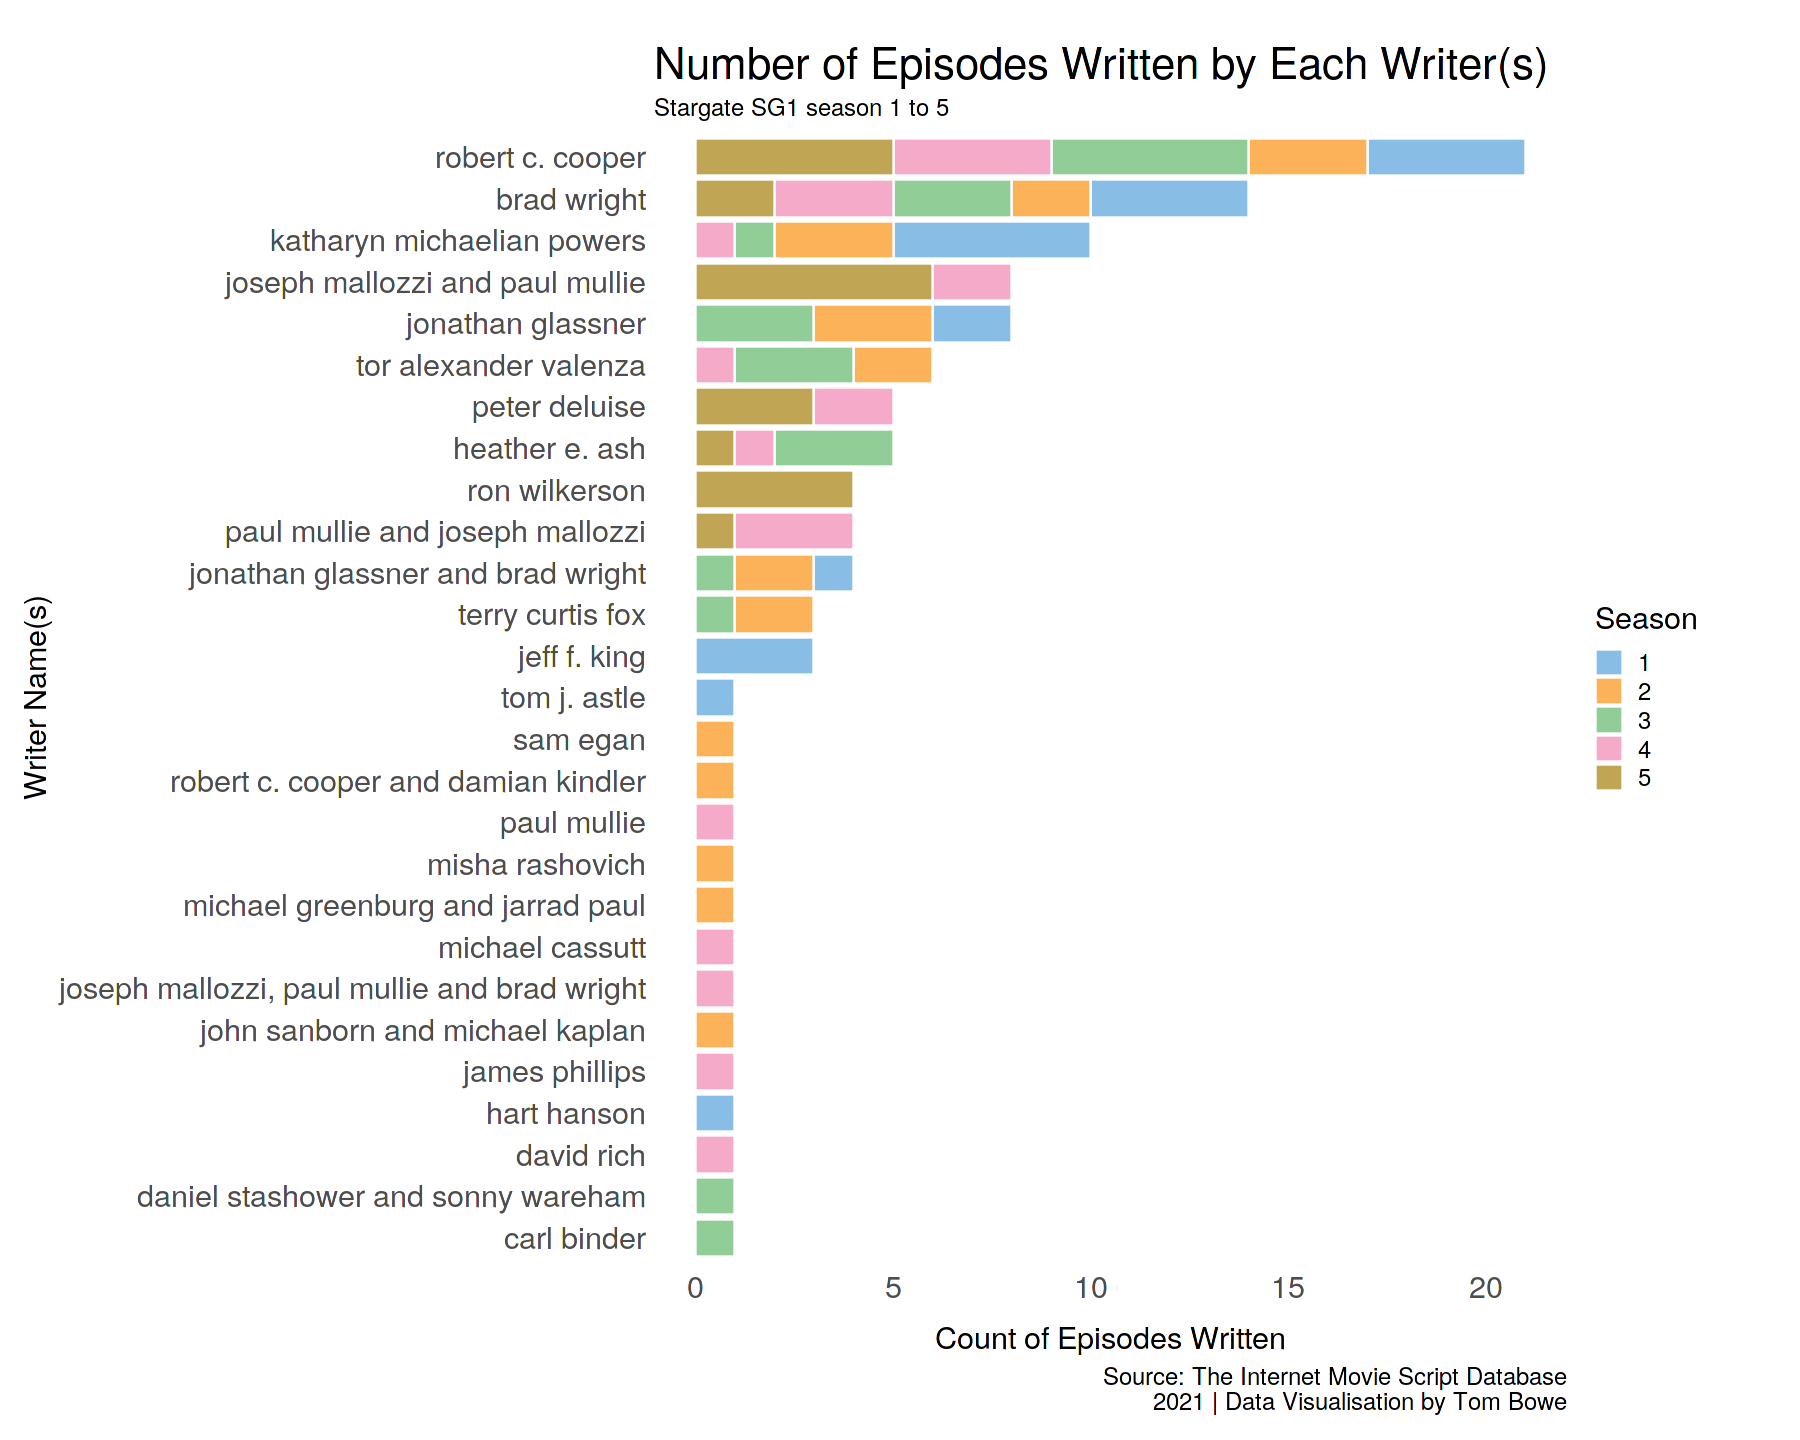

In [42]:
# Arrange the data:
sgwr <-
  group_by(sg, episode_writer, season_number) %>%
  count(episode_index) %>%
  tally() %>%
  mutate(season_number = as.character(season_number))

# Visualise:
fig_height(12)
ggplot(sgwr, aes(
  x = reorder(episode_writer, n, sum),
  y = n,
  fill = season_number
)) +
  geom_bar(stat = "identity",
           colour = "white") +
  theme_tb() +
  scale_fill_few(palette = "Light", 
                 name = "Season") +
  coord_flip() +
  labs(
    y = "Count of Episodes Written",
    x = "Writer Name(s)",
    title = "Number of Episodes Written by Each Writer(s)",
    subtitle = "Stargate SG1 season 1 to 5",
    caption = capt
  )

## Line Frequency of Top 40 Characters
Next, I take a look at who has the most lines in the show. Not surprisingly, Jack is the most talkative of all and Teal'c is a man of few words it would seem; he has less than half the lines compared to all other team members. Hammond is a close 5th to Teal'c and then the frequency of lines for other characters drops off quickly.

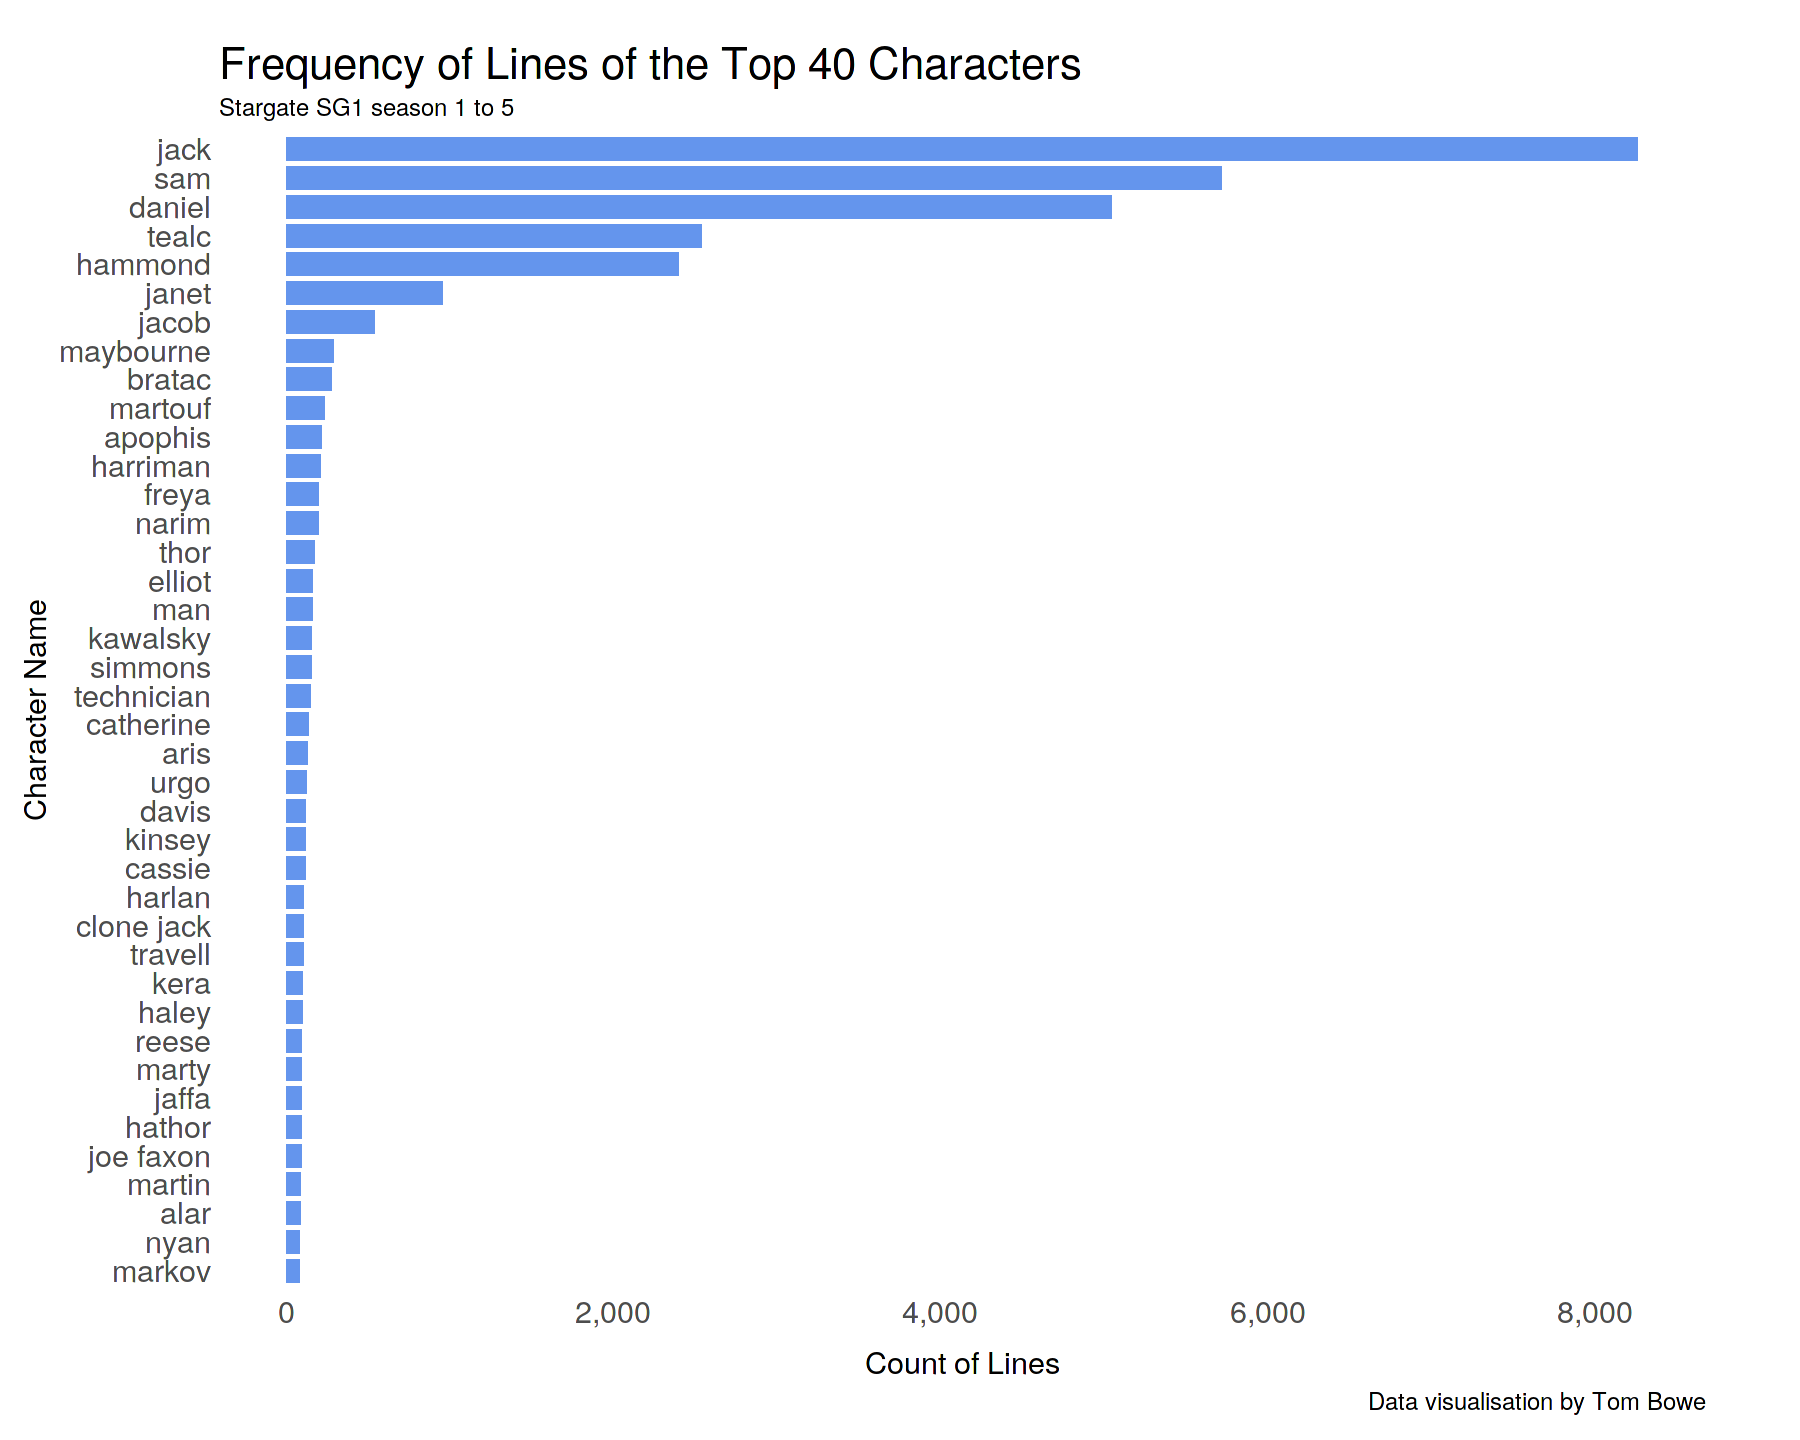

In [5]:
# Arrange the data:
sgc <-
  count(sg, character, sort = TRUE) %>%
  slice(1:40)

# Visualise:
fig_height(12)
ggplot(sgc, aes(x = reorder(character, n), y = n)) +
  scale_y_continuous(labels = comma) +
  geom_bar(stat = "identity",
           fill = "cornflowerblue",
           width = 0.8) +
  
  theme_tb() +
  coord_flip() +
  labs(
    y = "Count of Lines",
    x = "Character Name",
    title = "Frequency of Lines of the Top 40 Characters",
    subtitle = "Stargate SG1 season 1 to 5",
    caption = "Data visualisation by Tom Bowe"
  )

## Trend of Line Frequency for Main Characters
Lets take a look at how the top 7 character's lines present over time. I've plotted below each of these characters and the frequency of lines they had relative to each other over each episode from S01E01 to S05E22.

It is important to note from here on in that episode 1, season 1 "Children of the Gods" was a double episode. Therefore all frequencies here will be effectively doubled. Season 1 therefore technically has 21 episodes, while 2-5 have 22 each.

I immediately note that of all members of SG1, Daniel is the only one who occasionally has no lines at all:

* Season 2 Episode 16 "A Matter of Time" Daniel has two lines (almost looks like 0 on the plot!) at the end of the episode. He was with SG6 on a dig at P3X-808 for the majority of this time.
* Season 4 episode 19 "Prodigy" where Dr. Jackson is off world with SG11.
* Season 4 episode 21 "Double Jeopardy" is where most characters are replaced by clones and the real Daniel appears to have no lines at all.
* Season 5 episode 22 "Revelations" is the episode where Daniel ascends so naturally he has no lines. It is a bit difficult to see below as it is the last bar and it is absent.

Jack is fairly consistent throughout except for two episodes in particular:

* Season 3 Episode 1 "Into the Fire" is the episode where he is taken by a Goa'uld and is MIA for a period of time.
* Season 4 Episode 13 "The Curse" Jack is fishing in Minnesota with Teal'c and so has less lines compared to other episodes.

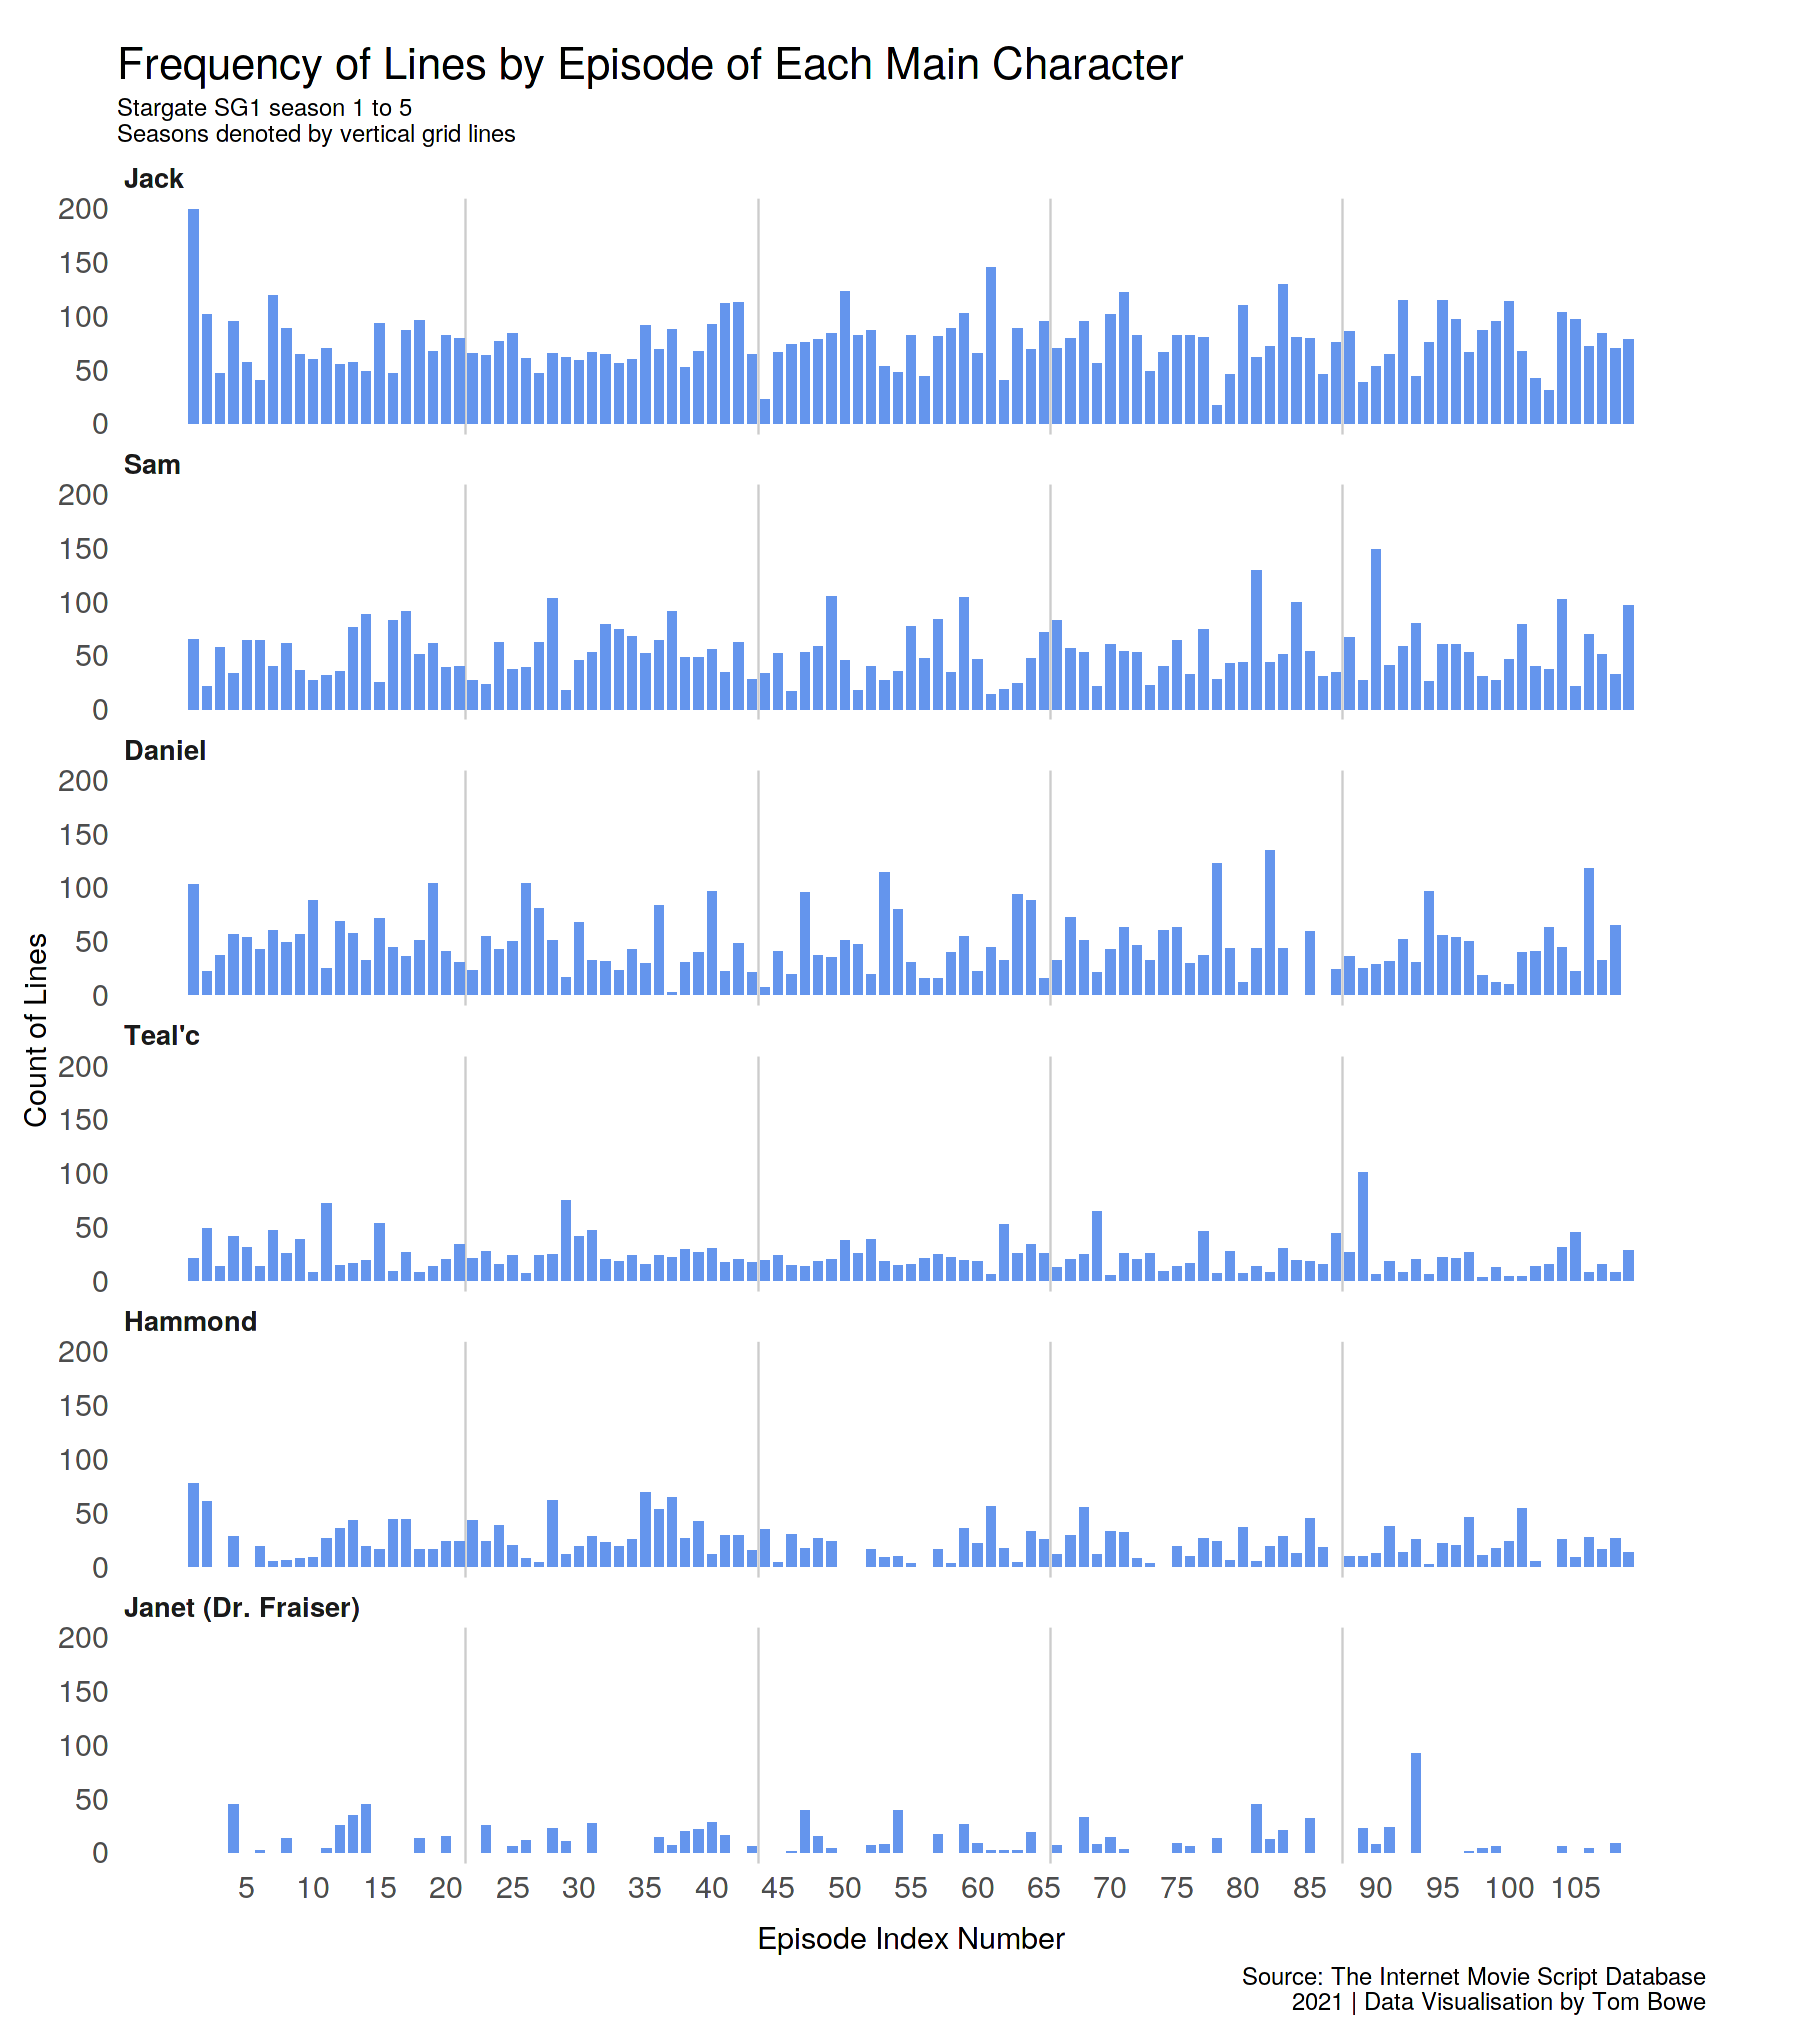

In [6]:
# Arrange the data:
sg1_main_characters_trend <-
  subset(sg, character %in% top_6_characters) %>%
  mutate(character = str_replace_all(character, "sam", "Sam")) %>%
  mutate(character = str_replace_all(character, "jack", "Jack")) %>%
  mutate(character = str_replace_all(character, "daniel", "Daniel")) %>%
  mutate(character = str_replace_all(character, "tealc", "Teal'c")) %>%
  mutate(character = str_replace_all(character, "hammond", "Hammond")) %>%
  mutate(character = str_replace_all(character, "janet", "Janet (Dr. Fraiser)")) %>%
  transform(character = factor(
    character,
    levels = c(
      "Jack",
      "Sam",
      "Daniel",
      "Teal'c",
      "Hammond",
      "Janet (Dr. Fraiser)"
    )
  ))

# Visualise:
fig_height(17)
ggplot(sg1_main_characters_trend, aes(x = episode_index)) +
  geom_vline(xintercept = 21.5,
             col = 1,
             alpha = .2) +
  geom_vline(xintercept = seq(43.5, 87.5, 22),
             col = 1,
             alpha = .2) +
  geom_bar(fill = "cornflowerblue", width = .7) +
  scale_x_continuous(breaks = seq(5, 105, 5)) +
  facet_wrap(~ character, ncol = 1) +
  theme_tb() +
  labs(
    y = "Count of Lines",
    x = "Episode Index Number",
    title = "Frequency of Lines by Episode of Each Main Character",
    subtitle = "Stargate SG1 season 1 to 5\nSeasons denoted by vertical grid lines",
    caption = capt
  )

## Mention Frequency
Next I take a look at who has the most mentions in the show. This is where another character references that character in dialogue in any way. 

It is important to be aware of the fact that a character may be referred to by a number of aliases so we need to do our best to accommodate  for this. I therefore sub in Jack instead of O'Neill and Sam instead of Carter etc etc.

I'm going to take a selection of characters for interest, both goodies and baddies, and then see where they fall on a scatter plot comparing mention frequency against total number of lines:

I expected there to be a vague correlation between dialogue mentions and lines and this is supported by the plot. I note an interesting outlier being Teal'c who features in the bottom right of the plot suggesting he is referred to in dialogue quite often but does not speak to the extent of the other main characters. Thor and Apophis both err to the right as well which I anticipated as they are heavily referenced by SG1 and co despite only appearing occasionally. Janet (Dr. Fraiser) and General Hammond seem to be on the other side of the spectrum, often speaking but not referenced as frequently. I would put this down to other characters referring to Fraiser as "Doctor" and Hammond as just "General", aliases which are difficult to account for. Jack's position is unsurprising to me as he has the highest number of lines overall and if he is always talking, then it limits how much time any other character gets to reference him.

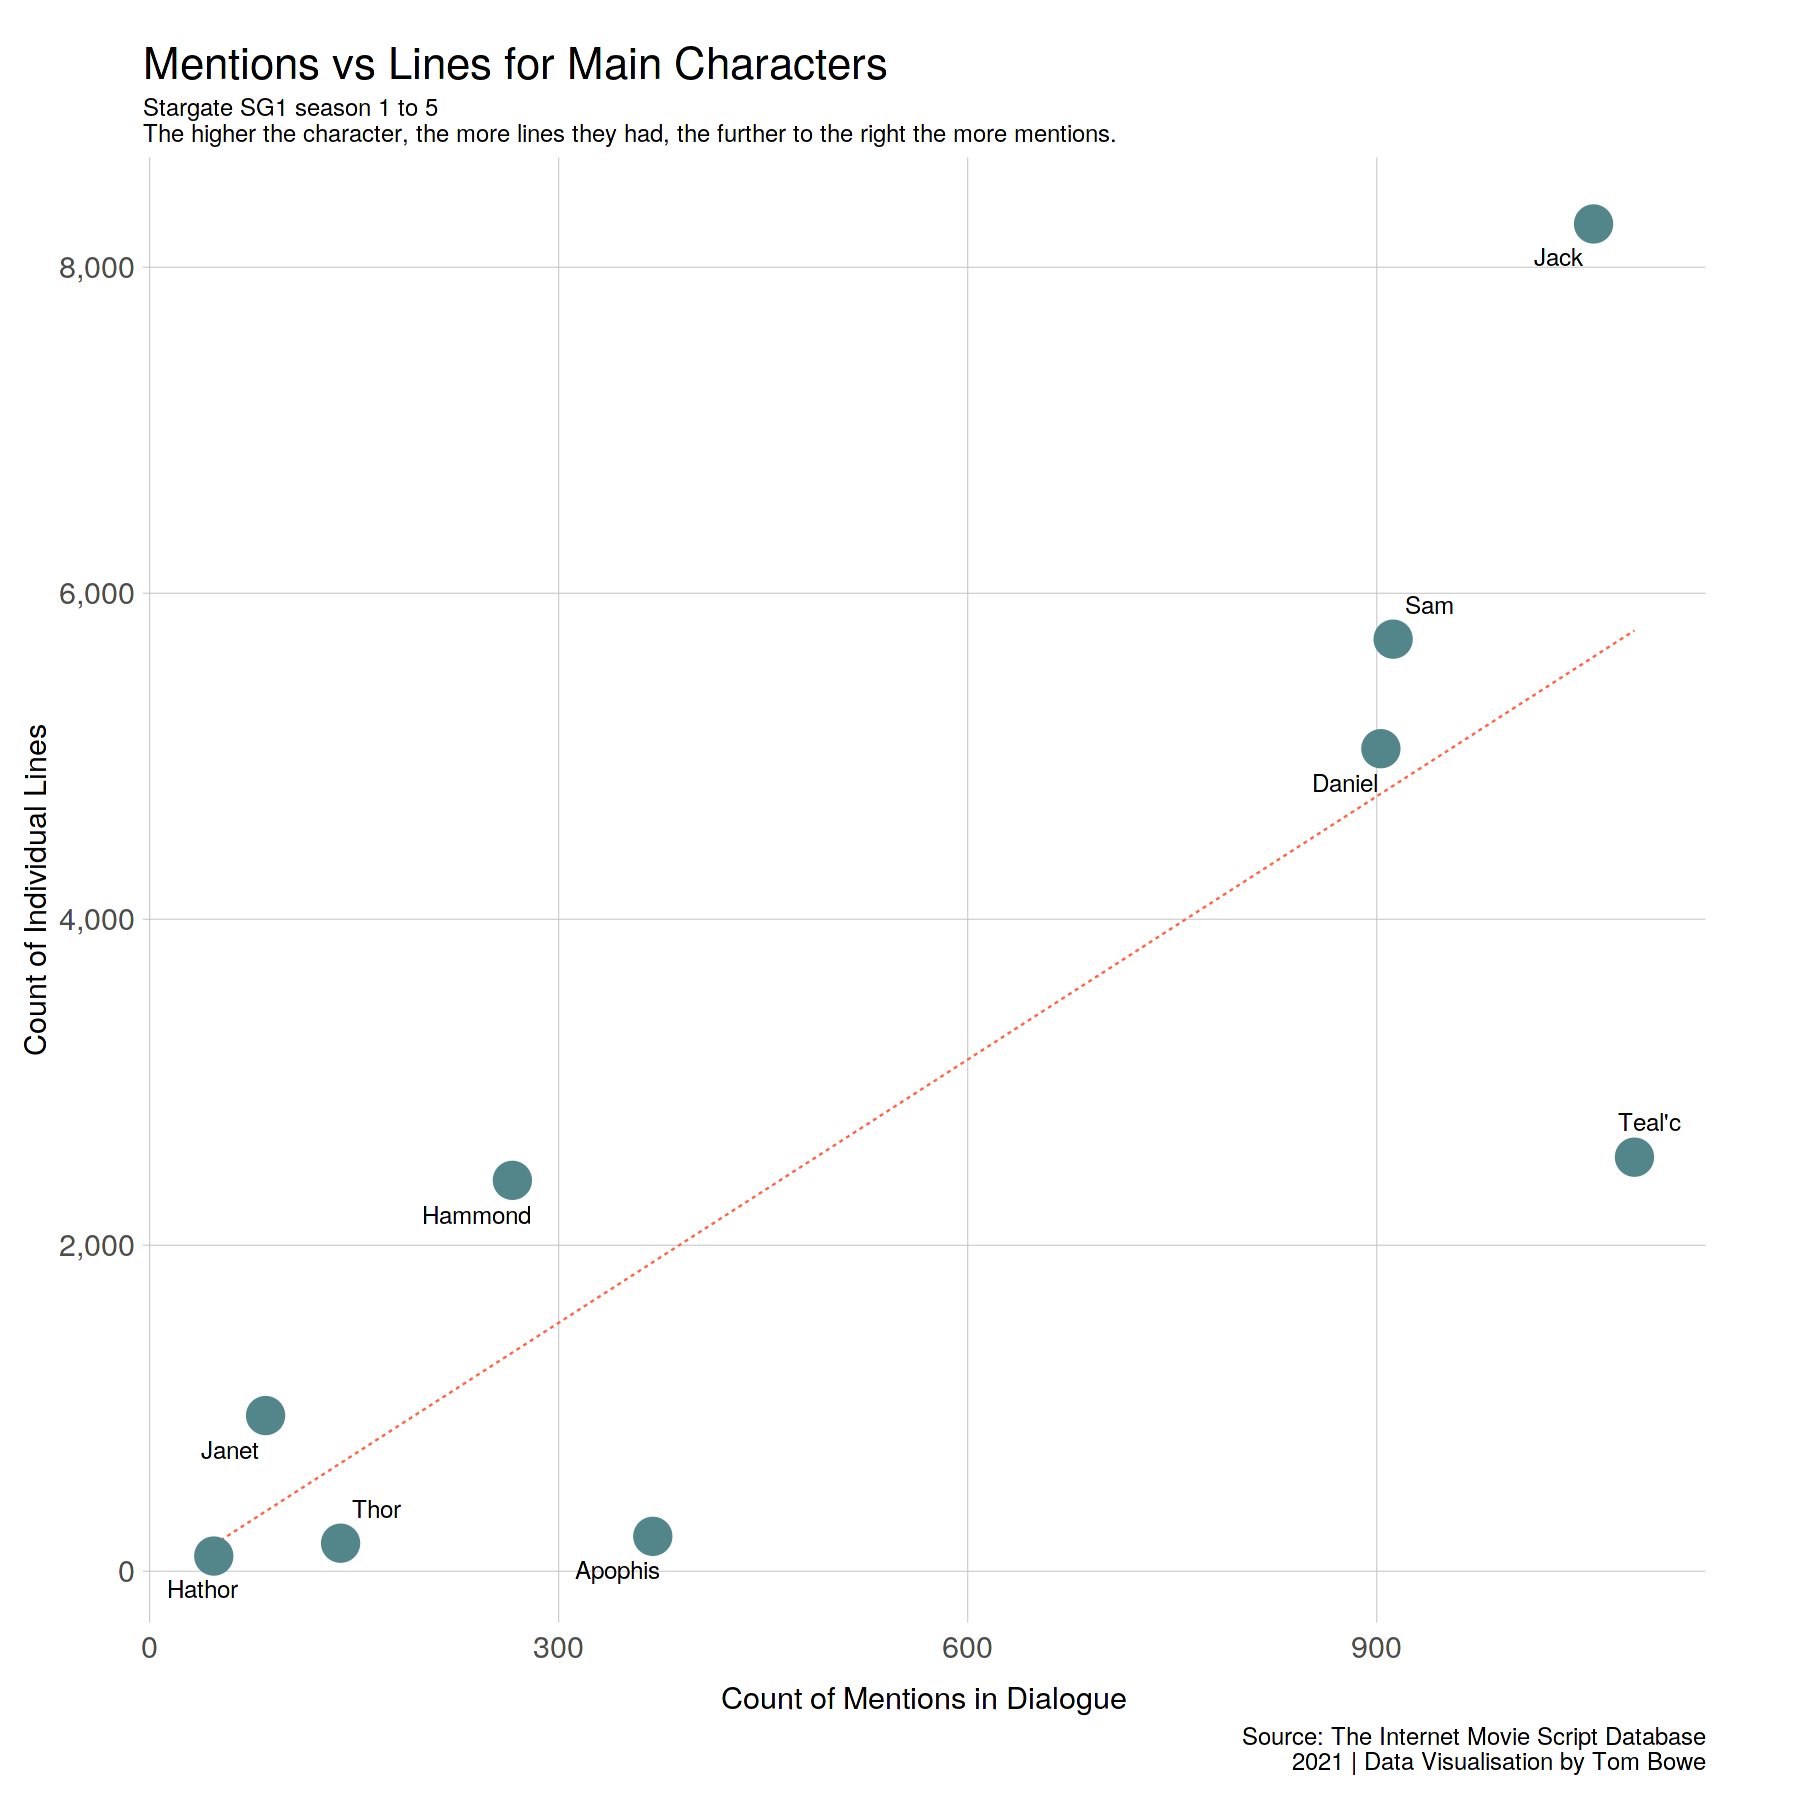

In [7]:
# Arrange the data:
sgm <-
  mutate(sg, content = as.character(content)) %>%
  mutate(content = str_squish(content)) %>%
  mutate(content = stripWhitespace(str_trim(content, side = "both"))) %>%
  mutate(content = str_replace_all(content, "jack oneill", "jack")) %>%
  mutate(content = str_replace_all(content, "danieljackson", "daniel")) %>%
  mutate(content = str_replace_all(content, "fraiser", "janet")) %>%
  mutate(content = str_replace_all(content, "general hammond", "hammond")) %>%
  mutate(content = str_replace_all(content, "captaincarter", "sam")) %>%
  mutate(content = str_replace_all(content, "majorcarter", "sam")) %>%
  mutate(content = str_replace_all(content, "oneill", "jack")) %>%
  mutate(content = str_replace_all(content, "carter", "sam")) %>%
  mutate(content = str_replace_all(content, "danny", "daniel")) %>%
  mutate(content = str_replace_all(content, "jacks", "jack")) %>%
  mutate(content = str_replace_all(content, "sams", "sam")) %>%
  mutate(content = str_replace_all(content, "daniels", "daniel")) %>%
  mutate(content = str_replace_all(content, "tealcs", "tealc")) %>%
  mutate(content = str_replace_all(content, "hammonds", "hammond")) %>%
  mutate(content = str_replace_all(content, "janets", "janet")) %>%
  mutate(content = str_replace_all(content, "thors", "thor")) %>%
  mutate(content = str_replace_all(content, "hathors", "hathor")) %>%
  mutate(content = str_replace_all(content, "apophiss", "apophis")) %>%
  separate_rows(content, sep = " ") %>%
  subset(content != "") %>%
  subset(
    content %in% c(
      "jack",
      "sam",
      "daniel",
      "tealc",
      "hammond",
      "janet",
      "thor",
      "hathor",
      "apophis"
    )
  ) %>%
  group_by(content) %>%
  tally(sort = TRUE) %>%
  rename(mentions = n, character = content) %>%
  inner_join(sgc, by = c("character" = "character")) %>%
  mutate(character = str_replace_all(character, "sam", "Sam")) %>%
  mutate(character = str_replace_all(character, "jack", "Jack")) %>%
  mutate(character = str_replace_all(character, "daniel", "Daniel")) %>%
  mutate(character = str_replace_all(character, "tealc", "Teal'c")) %>%
  mutate(character = str_replace_all(character, "hammond", "Hammond")) %>%
  mutate(character = str_replace_all(character, "janet", "Janet")) %>%
  mutate(character = str_replace_all(character, "thor", "Thor")) %>%
  mutate(character = str_replace_all(character, "haThor", "Hathor")) %>%
  mutate(character = str_replace_all(character, "apophis", "Apophis"))

# Visualise:
fig_height(15)
ggplot(sgm, aes(mentions, n, label = character)) +
  scale_y_continuous(labels = comma) +
  scale_x_continuous(labels = comma) +
  geom_smooth(
    method = 'lm',
    se = FALSE,
    colour = "tomato",
    lty = 2,
    lwd = .5,
    formula = y ~ x
  ) +
  geom_point(size = 10, colour = "cadetblue4") +
  geom_text_repel(size = 5,
                  box.padding = 1,
                  segment.alpha = 0) +
  theme_tb() +
  theme_tb_both() +
  labs(
    y = "Count of Individual Lines",
    x = "Count of Mentions in Dialogue",
    title = "Mentions vs Lines for Main Characters",
    subtitle = "Stargate SG1 season 1 to 5\nThe higher the character, the more lines they had, the further to the right the more mentions.",
    caption = capt
  )

# Text Mining
## n-Gram Generation
I now do some very basic text mining I.e. I will look at n-gram frequency and explore some of the insights. I first tidy the data and then generate my n-gram subsets.

In [8]:
# Unigram generation
# Arrange the data:
sg1clean <-
  mutate(sg, content = as.character(content)) %>%
  mutate(content = removeWords(content, stopwords("en"))) %>%
  mutate(content = removeWords(
    content,
    c(
      "thats",
      "weve",
      "hes",
      "theres",
      "ive",
      "im",
      "will",
      "can",
      "cant",
      "dont",
      "youve",
      "us",
      "youre",
      "youll",
      "theyre",
      "whats",
      "didnt",
      "id"
    )
  )) %>%
  mutate(content = str_squish(content)) %>%
  mutate(content = stripWhitespace(str_trim(content, side = "both")))

# Create a table of unigrams
sg1tokenised <-
  separate_rows(sg1clean, content, sep = " ") %>%
  subset(content != "") %>%
  mutate(content = str_replace_all(content, "cree", "kree"))

In [9]:
# Create table counting frequency of the word "nice"
nice <-
  subset(sg1tokenised, content == "nice") %>%
  count(character, sort = TRUE)

In [10]:
# Bigram generation
# Arrange the data:
# This subset removes the character names so as to stop them from polluting our bigram analysis
sg1cleanbigrams <-
  mutate(sg1clean, content = removeWords(content, c("oneill", "hammond", "jackson", "carter")))

In [11]:
# Generate a table of bigrams
# Bigram tokenizer
tokenizer_2 <- function(x){
  NGramTokenizer(x, Weka_control(min=2, max=2))
}
# Bigram function 
frequentBigrams <- function(text){
  s.cor <- VCorpus(VectorSource(text))
  s.cor.cl <- (s.cor)
  s.tdm <- TermDocumentMatrix(s.cor.cl, control=list(tokenize=tokenizer_2))
  s.tdm <- removeSparseTerms(s.tdm, 0.999)
  m <- as.matrix(s.tdm)
  word_freqs <- sort(rowSums(m), decreasing=T)
  dm <- data.frame(word=names(word_freqs), freq=word_freqs)
  
  return(dm)
}
# Generate bigrams
bigrams <- frequentBigrams(sg1cleanbigrams$content)[1:20, ]

In [12]:
# Arrange the data:
# Note that Trigrams and above do not have the same problem as unigrams have with stop words, nor the same problem that bigrams have with character names. I therefore add back all stop words and character names for trigram and quadrigram generation.
sg1cleantrigrams <- 
  mutate(sg, content = as.character(content)) %>%
  mutate(content = str_squish(content)) %>%
  mutate(content = stripWhitespace(str_trim(content, side = "both")))

In [13]:
# Generate a table of trigrams
# Trigram tokenizer
tokenizer_3 <- function(x){
  NGramTokenizer(x, Weka_control(min=3, max=3))
}
# Trigram function 
frequentTrigrams <- function(text){
  s.cor <- VCorpus(VectorSource(text))
  s.cor.cl <- (s.cor)
  s.tdm <- TermDocumentMatrix(s.cor.cl, control=list(tokenize=tokenizer_3))
  s.tdm <- removeSparseTerms(s.tdm, 0.999)
  m <- as.matrix(s.tdm)
  word_freqs <- sort(rowSums(m), decreasing=T)
  dm <- data.frame(word=names(word_freqs), freq=word_freqs)
  
  return(dm)
}
# Generate trigrams
trigrams <- frequentTrigrams(sg1cleantrigrams$content)[1:20, ]

In [14]:
# Generate a table of quadrigrams
# Quadrigram tokenizer
tokenizer_4 <- function(x){
  NGramTokenizer(x, Weka_control(min=4, max=4))
}
# Quadrigram function 
frequentQuadrigrams <- function(text){
  s.cor <- VCorpus(VectorSource(text))
  s.cor.cl <- (s.cor)
  s.tdm <- TermDocumentMatrix(s.cor.cl, control=list(tokenize=tokenizer_4))
  s.tdm <- removeSparseTerms(s.tdm, 0.999)
  m <- as.matrix(s.tdm)
  word_freqs <- sort(rowSums(m), decreasing=T)
  dm <- data.frame(word=names(word_freqs), freq=word_freqs)
  
  return(dm)
}
# Generate quadrigrams
quadrigrams <- frequentQuadrigrams(sg1cleantrigrams$content)[1:5, ]

## Frequency of the Top 40 Unigrams
So, I have tidied up the data removing any stop words and other junk that will pollute the insights. Now I first take a look at the most common unigrams (single words) that are contained in dialogue in the SG1 script:

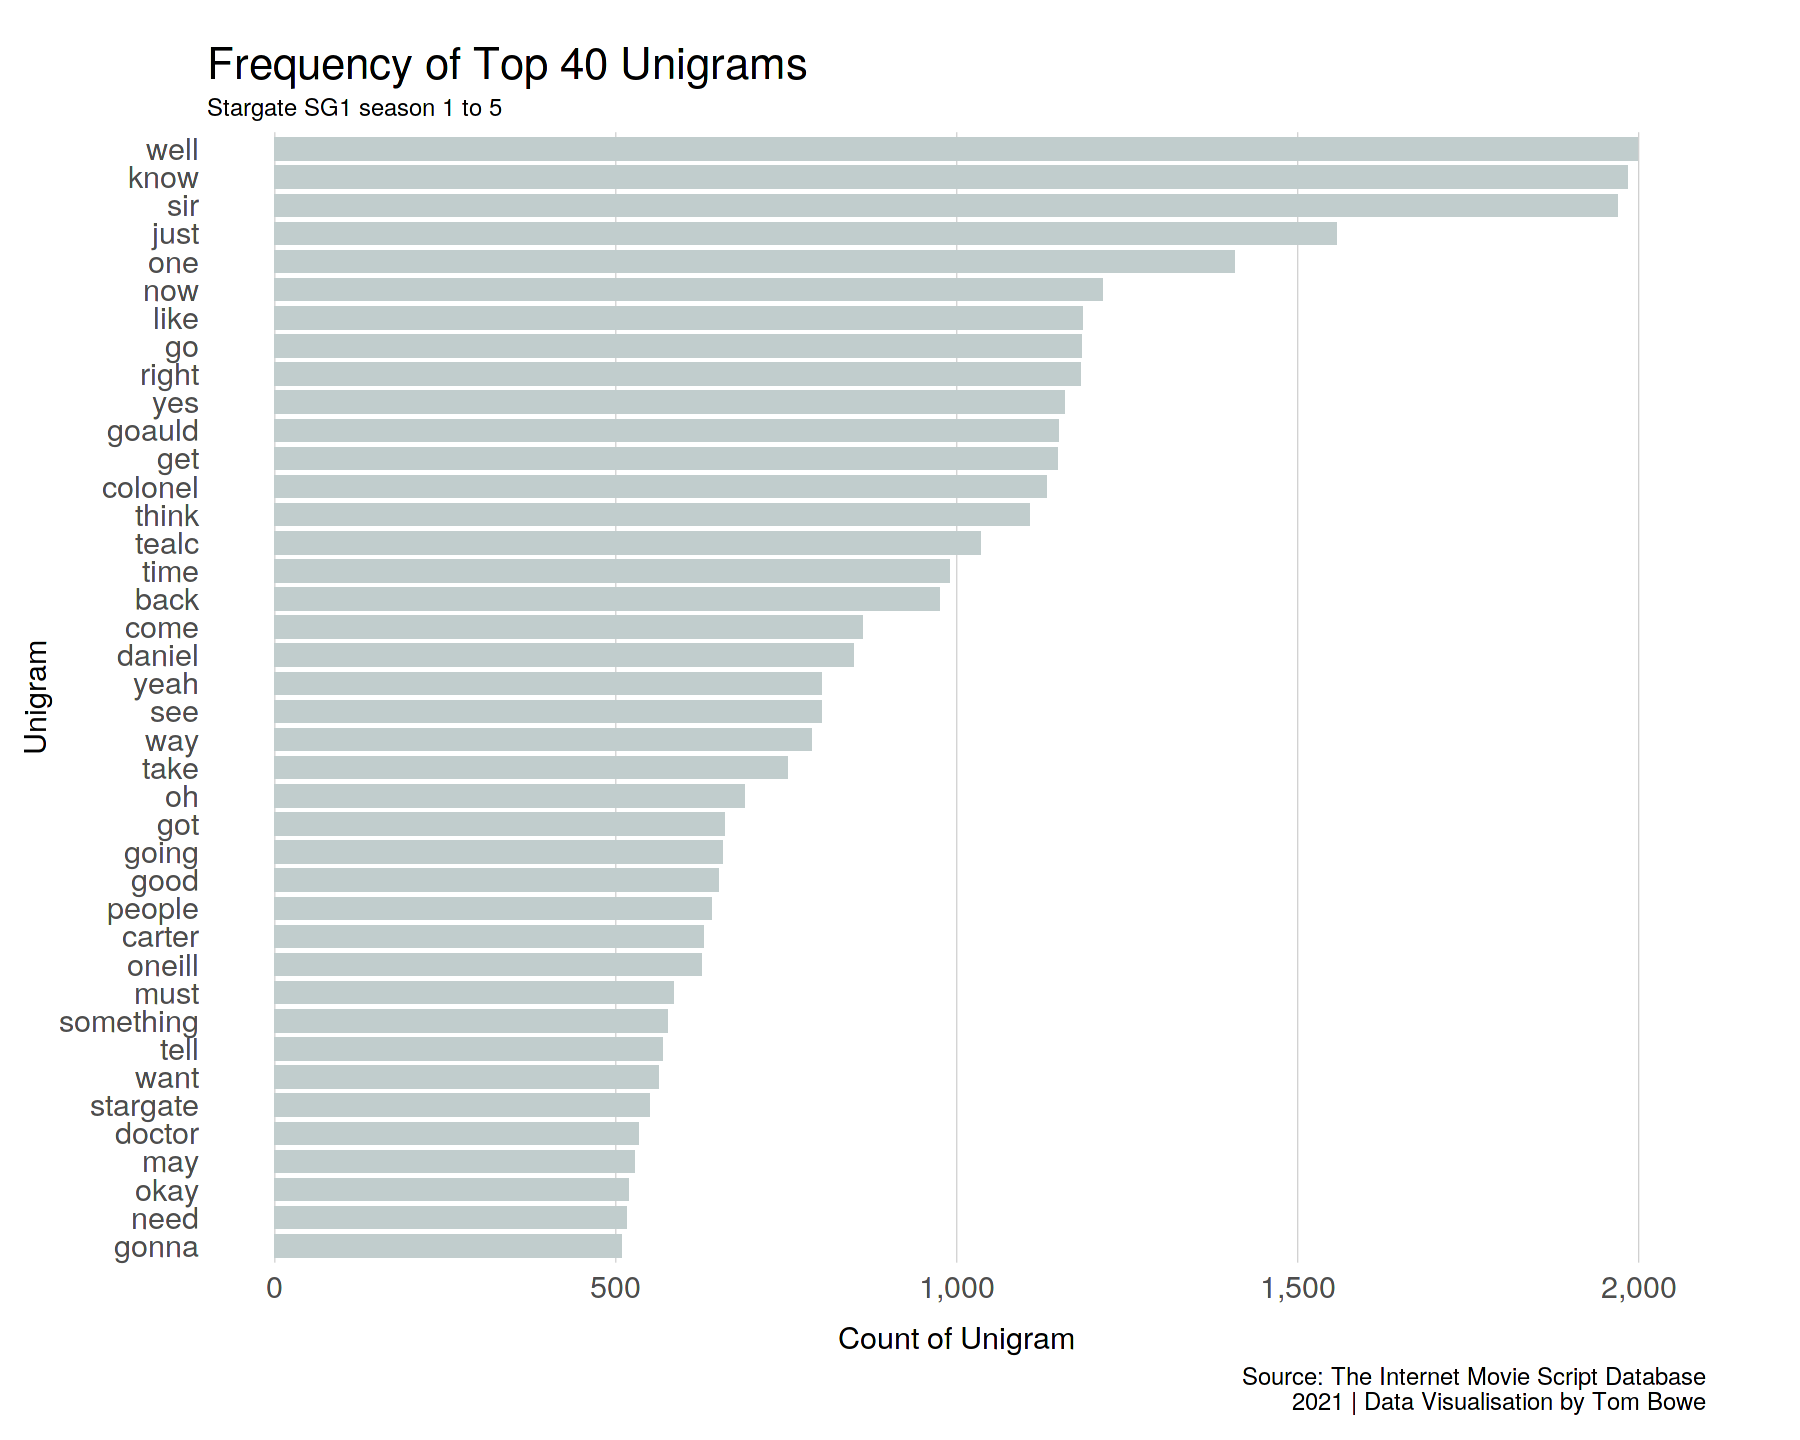

In [15]:
# Visualise:
fig_height(12)
ggplot(slice(count(sg1tokenised, content, sort = TRUE), 1:40), aes(x = reorder(content, n), y = n)) +
  scale_y_continuous(labels = comma) +
  geom_bar(stat = "identity",
           fill = "azure3",
           width = .8) +
  theme_tb() +
  theme_tb_vert() +
  coord_flip() +
  labs(
    y = "Count of Unigram",
    x = "Unigram",
    title = "Frequency of Top 40 Unigrams",
    subtitle = "Stargate SG1 season 1 to 5",
    caption = capt
  )

## Frequency of the Top Unigrams by the Main Characters
Now lets see how this varies between our favourite characters:

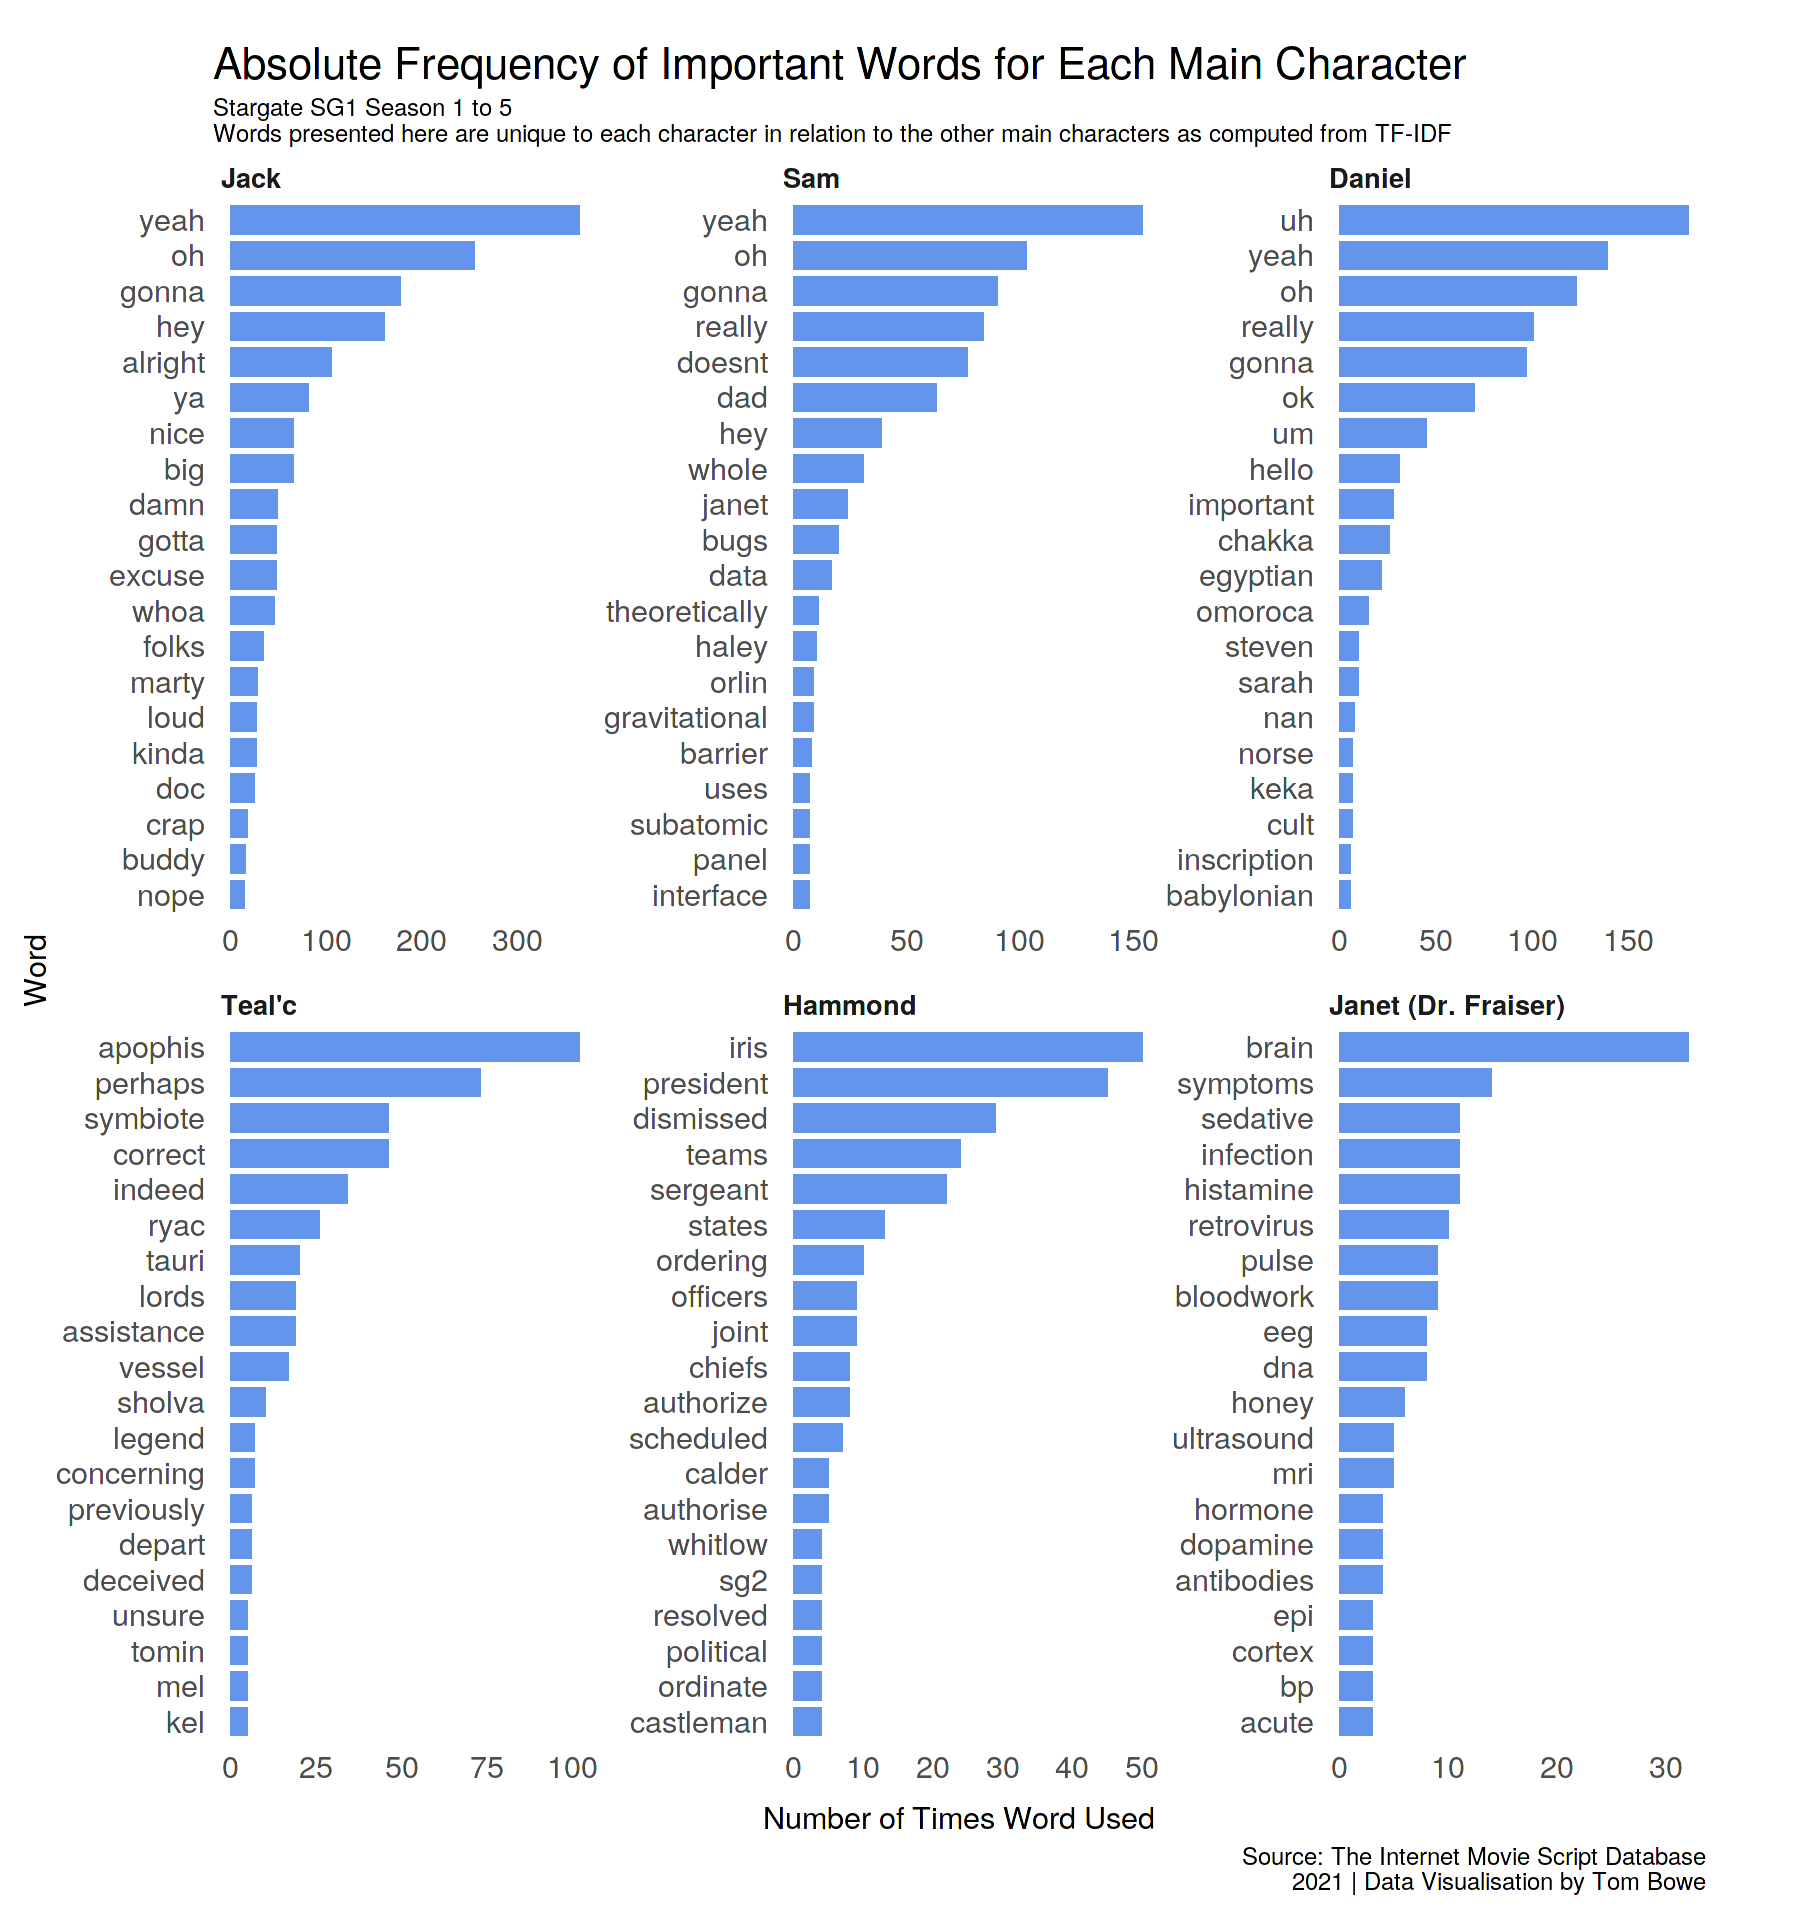

In [16]:
words <-
  select(sg1tokenised, character, content) %>%
  count(character, content, sort = TRUE) %>%
  ungroup()

all_words <-
  group_by(words, character) %>%
  summarise(total = sum(n), .groups = 'drop')

words_goodies <-
  left_join(words, all_words, by = c("character" = "character")) %>%
  subset(character %in% c(top_6_characters)) %>%
  bind_tf_idf(content, character, n)

words_baddies <-
  left_join(words, all_words, by = c("character" = "character")) %>%
  bind_tf_idf(content, character, n)

# Baddies
wordsplt_apophis <-
  subset(words_baddies, character == "apophis") %>% arrange(desc(tf_idf)) %>% slice(1:20)
wordsplt_maybourne <-
  subset(words_baddies, character == "maybourne") %>% arrange(desc(tf_idf)) %>% slice(1:20)
wordsplt_hathor <-
  subset(words_baddies, character == "hathor") %>% arrange(desc(tf_idf)) %>% slice(1:20)
wordsplt_jaffa <-
  subset(words_baddies, character == "jaffa") %>% arrange(desc(tf_idf)) %>% slice(1:20)

# Goodies
wordsplt_jack <-
  subset(words_goodies, character == "jack") %>% arrange(desc(tf_idf)) %>% slice(1:20)
wordsplt_sam <-
  subset(words_goodies, character == "sam") %>% arrange(desc(tf_idf)) %>% slice(1:20)
wordsplt_tealc <-
  subset(words_goodies, character == "tealc") %>% arrange(desc(tf_idf)) %>% slice(1:20)
wordsplt_daniel <-
  subset(words_goodies, character == "daniel") %>% arrange(desc(tf_idf)) %>% slice(1:20)
wordsplt_hammond <-
  subset(words_goodies, character == "hammond") %>% arrange(desc(tf_idf)) %>% slice(1:20)
wordsplt_janet <-
  subset(words_goodies, character == "janet") %>% arrange(desc(tf_idf)) %>% slice(1:20)

wordsplt_goodies <-
  rbind(
    wordsplt_jack,
    wordsplt_sam,
    wordsplt_tealc,
    wordsplt_daniel,
    wordsplt_hammond,
    wordsplt_janet
  ) %>%
  mutate(character = str_replace_all(character, "sam", "Sam")) %>%
  mutate(character = str_replace_all(character, "jack", "Jack")) %>%
  mutate(character = str_replace_all(character, "daniel", "Daniel")) %>%
  mutate(character = str_replace_all(character, "tealc", "Teal'c")) %>%
  mutate(character = str_replace_all(character, "hammond", "Hammond")) %>%
  mutate(character = str_replace_all(character, "janet", "Janet (Dr. Fraiser)")) %>%
  transform(character = factor(
    character,
    levels = c(
      "Jack",
      "Sam",
      "Daniel",
      "Teal'c",
      "Hammond",
      "Janet (Dr. Fraiser)"
    )
  ))

wordsplt_baddies <-
  rbind(wordsplt_apophis,
        wordsplt_maybourne,
        wordsplt_hathor,
        wordsplt_jaffa) %>%
  mutate(character = str_replace_all(character, "apophis", "Apophis")) %>%
  mutate(character = str_replace_all(character, "maybourne", "Maybourne")) %>%
  mutate(character = str_replace_all(character, "hathor", "Hathor")) %>%
  mutate(character = str_replace_all(character, "jaffa", "Jaffa (Multiple)")) %>%
  transform(character = factor(
    character,
    levels = c("Apophis", "Maybourne", "Hathor", "Jaffa (Multiple)")
  ))

# Visualise:
fig_height(16)
ggplot(wordsplt_goodies, aes(x = reorder_within(content, n, character), y = n)) +
  geom_bar(stat = "identity", fill = "cornflowerblue", width = 0.8) +
  theme_tb() +
  scale_x_reordered() +
  facet_wrap(~ character, scales = "free") +
  coord_flip() +
  labs(
    y = "Number of Times Word Used",
    x = "Word",
    title = "Absolute Frequency of Important Words for Each Main Character",
    subtitle = "Stargate SG1 Season 1 to 5\nWords presented here are unique to each character in relation to the other main characters as computed from TF-IDF",
    caption = capt
  )

## Visualise the Frequency of the Top Unigrams by the Baddies
Then I can do the same but for the baddies as we can be sure they have a far different vocabulary:

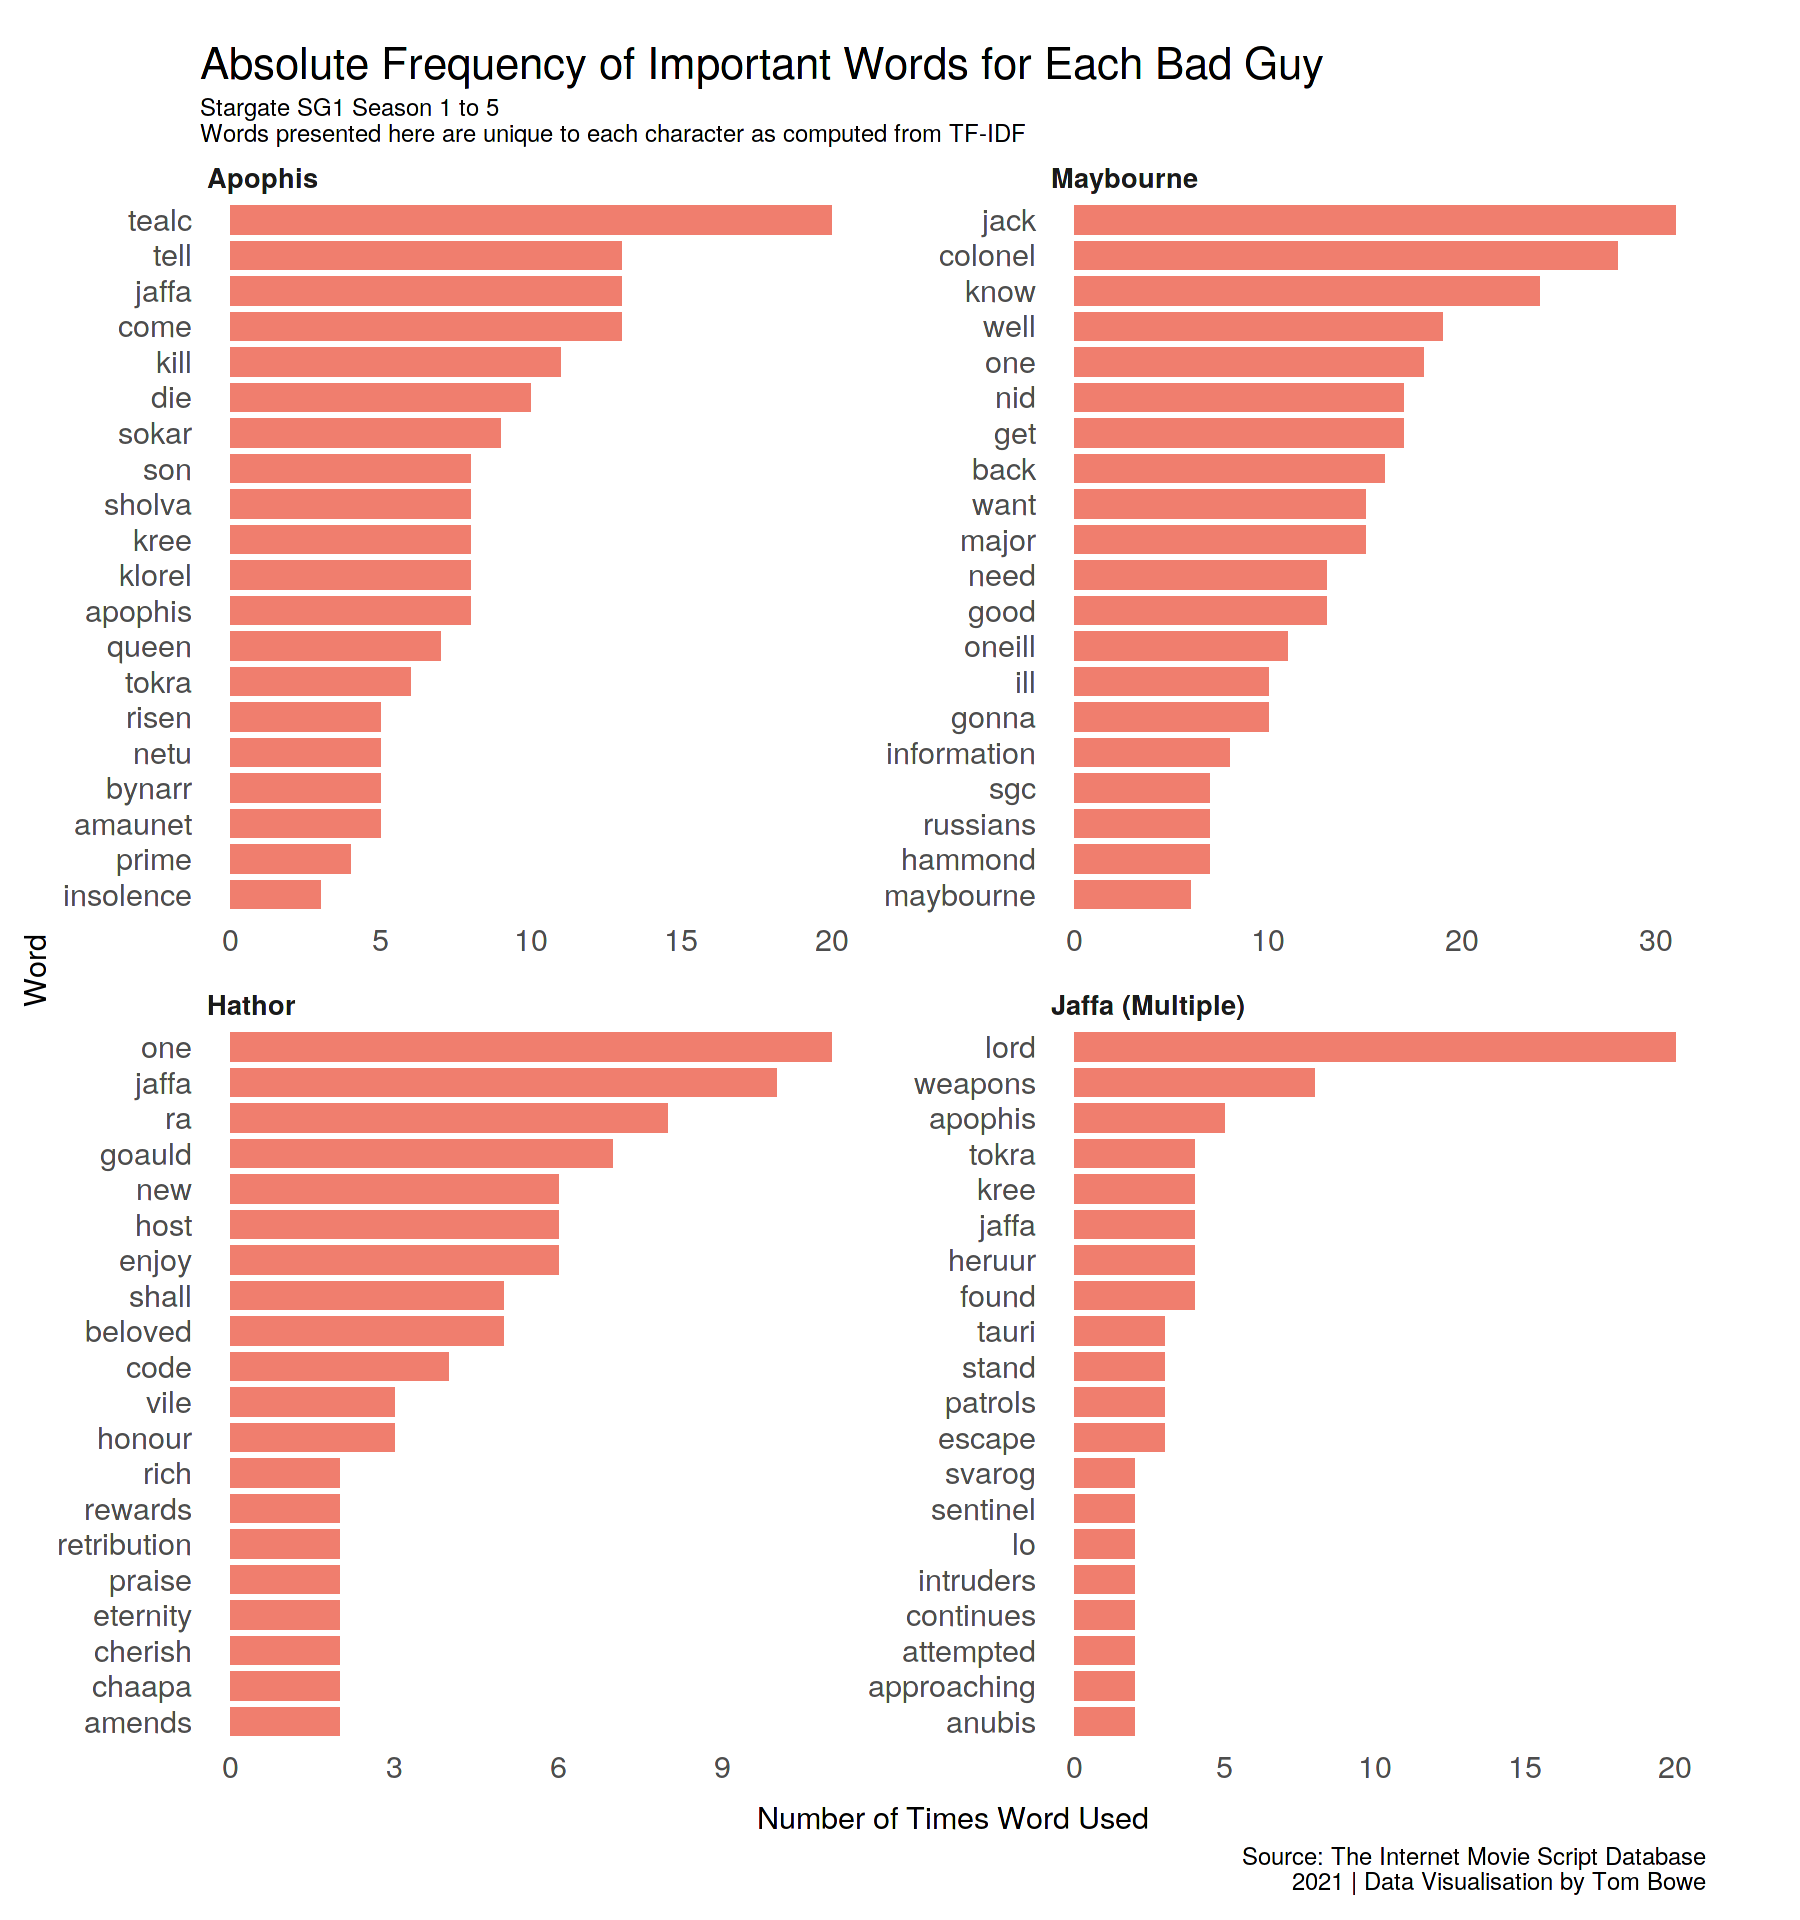

In [17]:
# Visualise:
fig_height(16)
ggplot(wordsplt_baddies, aes(x = reorder_within(content, n, character), y = n)) +
  geom_bar(stat = "identity", fill = "#F07E6E", width = 0.8) +
  theme_tb() +
  scale_x_reordered() +
  facet_wrap(~ character, scales = "free") +
  coord_flip() +
  labs(y = "Number of Times Word Used", 
       x = "Word",
       title = "Absolute Frequency of Important Words for Each Bad Guy",
       subtitle = "Stargate SG1 Season 1 to 5\nWords presented here are unique to each character as computed from TF-IDF",
       caption = capt)

## Indeed
I note Teal'c isn't the only person to say indeed, but he eclipses them all in his frequency. Looking at the trend it increases towards the end which I would hazzard a guess was a combination of him developing his character, and giving the fans what they wanted. I found it interesting that he never said it once during all of season 1.

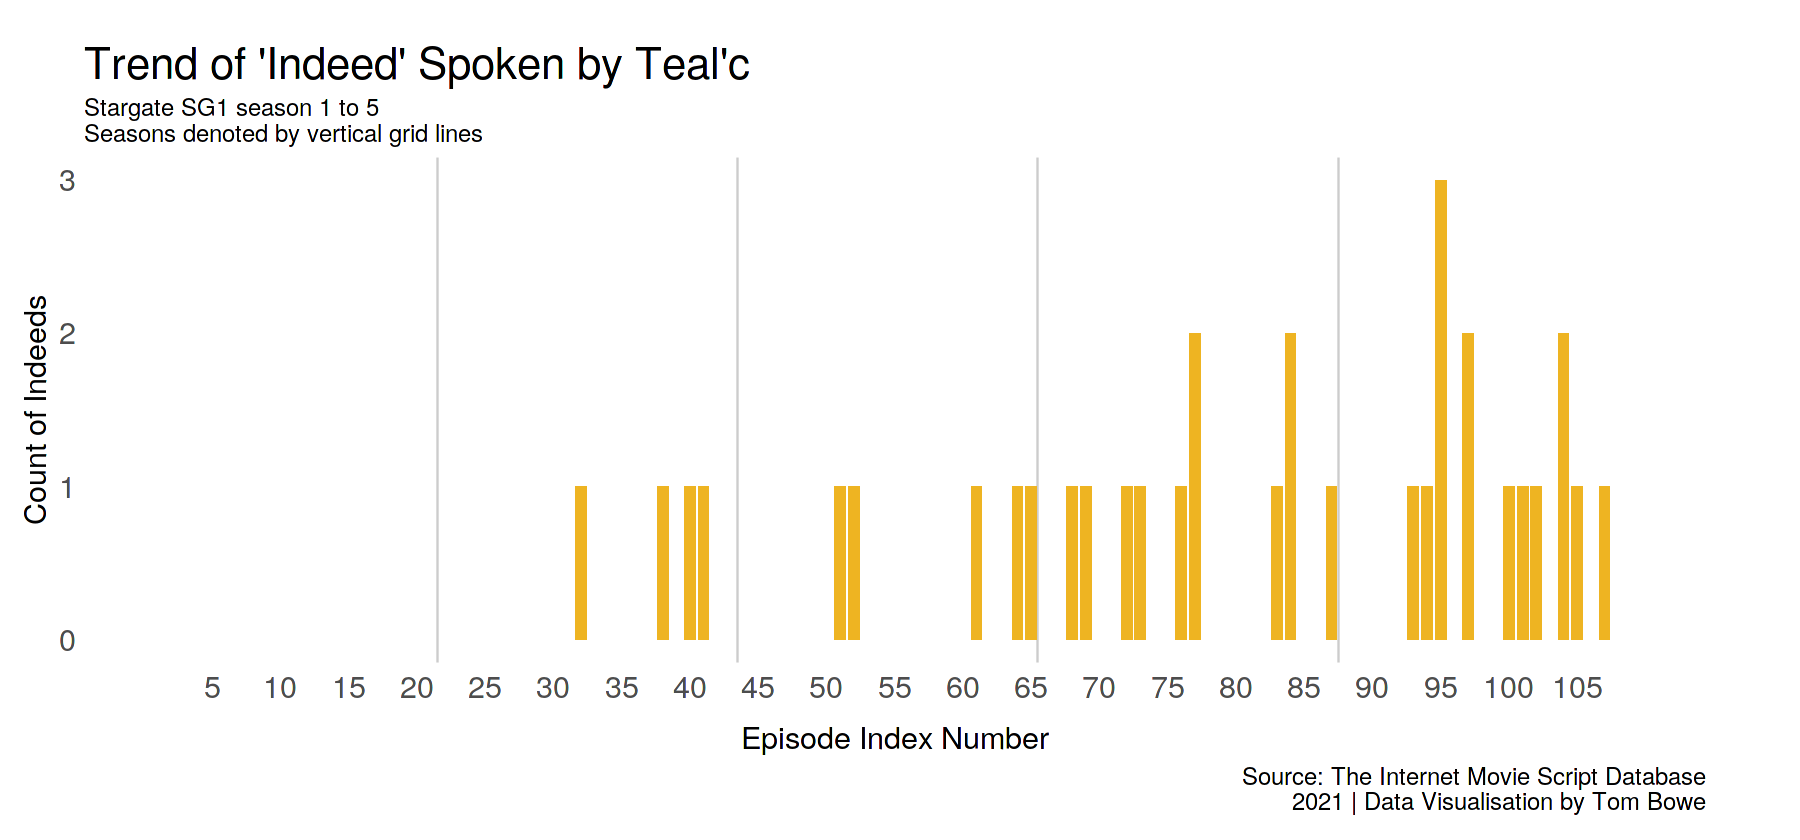

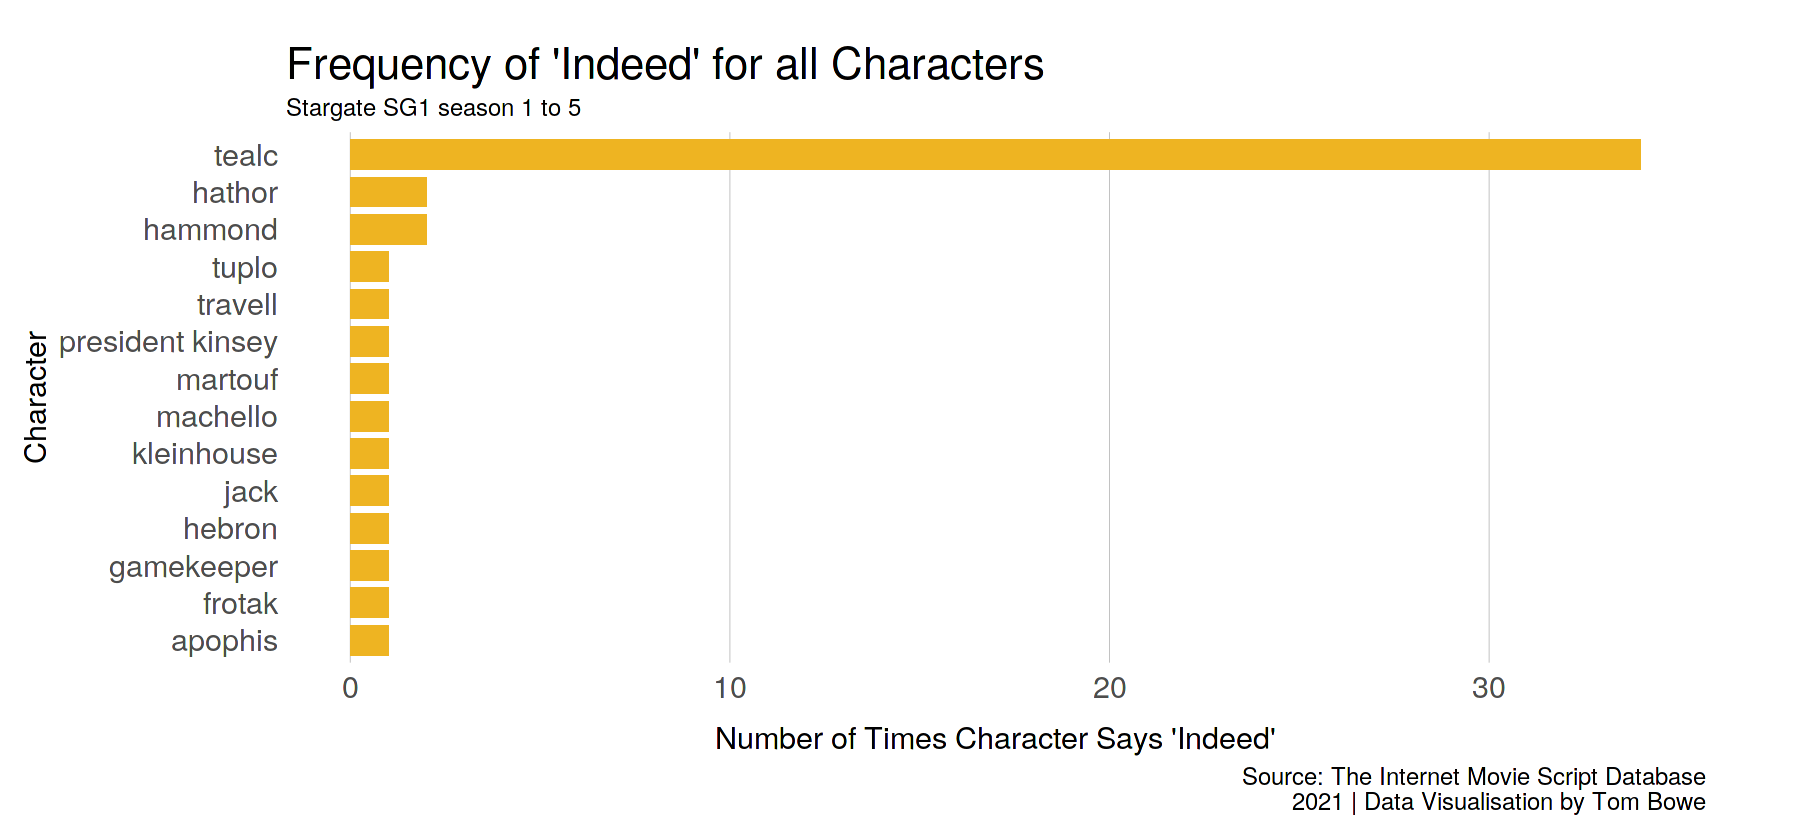

In [18]:
# Arrange the data:
indeed <- subset(sg1tokenised, content == "indeed") %>%
  group_by(character) %>%
  tally(sort = TRUE)

indeedtrend <-
  subset(sg1tokenised, character == "tealc" & content == "indeed")

# Visualise:
fig_height(7)
ggplot(indeedtrend, aes(x = episode_index)) +
  geom_vline(xintercept = 21.5,
             col = 1,
             alpha = .2) +
  geom_vline(xintercept = seq(43.5, 87.5, 22),
             col = 1,
             alpha = .2) +
  geom_bar(fill = "goldenrod2", width = 0.8) +
  scale_x_continuous(breaks = seq(from = 5, to = 105, by = 5),
                     lim = c(1, 109)) +
  theme_tb() +
  labs(
    y = "Count of Indeeds",
    x = "Episode Index Number",
    title = "Trend of 'Indeed' Spoken by Teal'c",
    subtitle = "Stargate SG1 season 1 to 5\nSeasons denoted by vertical grid lines",
    caption = capt
  )


# Visualise:
fig_height(7)
ggplot(indeed, aes(x = reorder(character, n), y = n)) +
  scale_y_continuous(labels = comma) +
  geom_bar(stat = "identity",
           fill = "goldenrod2",
           width = 0.8) +
  theme_tb() +
  theme_tb_vert() +
  coord_flip() +
  labs(
    y = "Number of Times Character Says 'Indeed'",
    x = "Character",
    title = "Frequency of 'Indeed' for all Characters",
    subtitle = "Stargate SG1 season 1 to 5",
    caption = capt
  )

## Frequency of the Top Overall Bigrams
Moving on now and looking at the most common overall bigrams. These are commonly combined word duos that are spoken by any of the characters in the show. Keep in mind that I have removed stop words so things like "let go" might encompass "let me/it/us go", as well as just "let go"... you get the idea.

Far and away "yes sir" was the most common bigram which reflects the show's military themes and likely made up primarily of when characters interact with Jack O'Neill which would be quite often. I would love to confirm this frequency but it is difficult to gauge who was talking to who from the scripts on IMSDb.

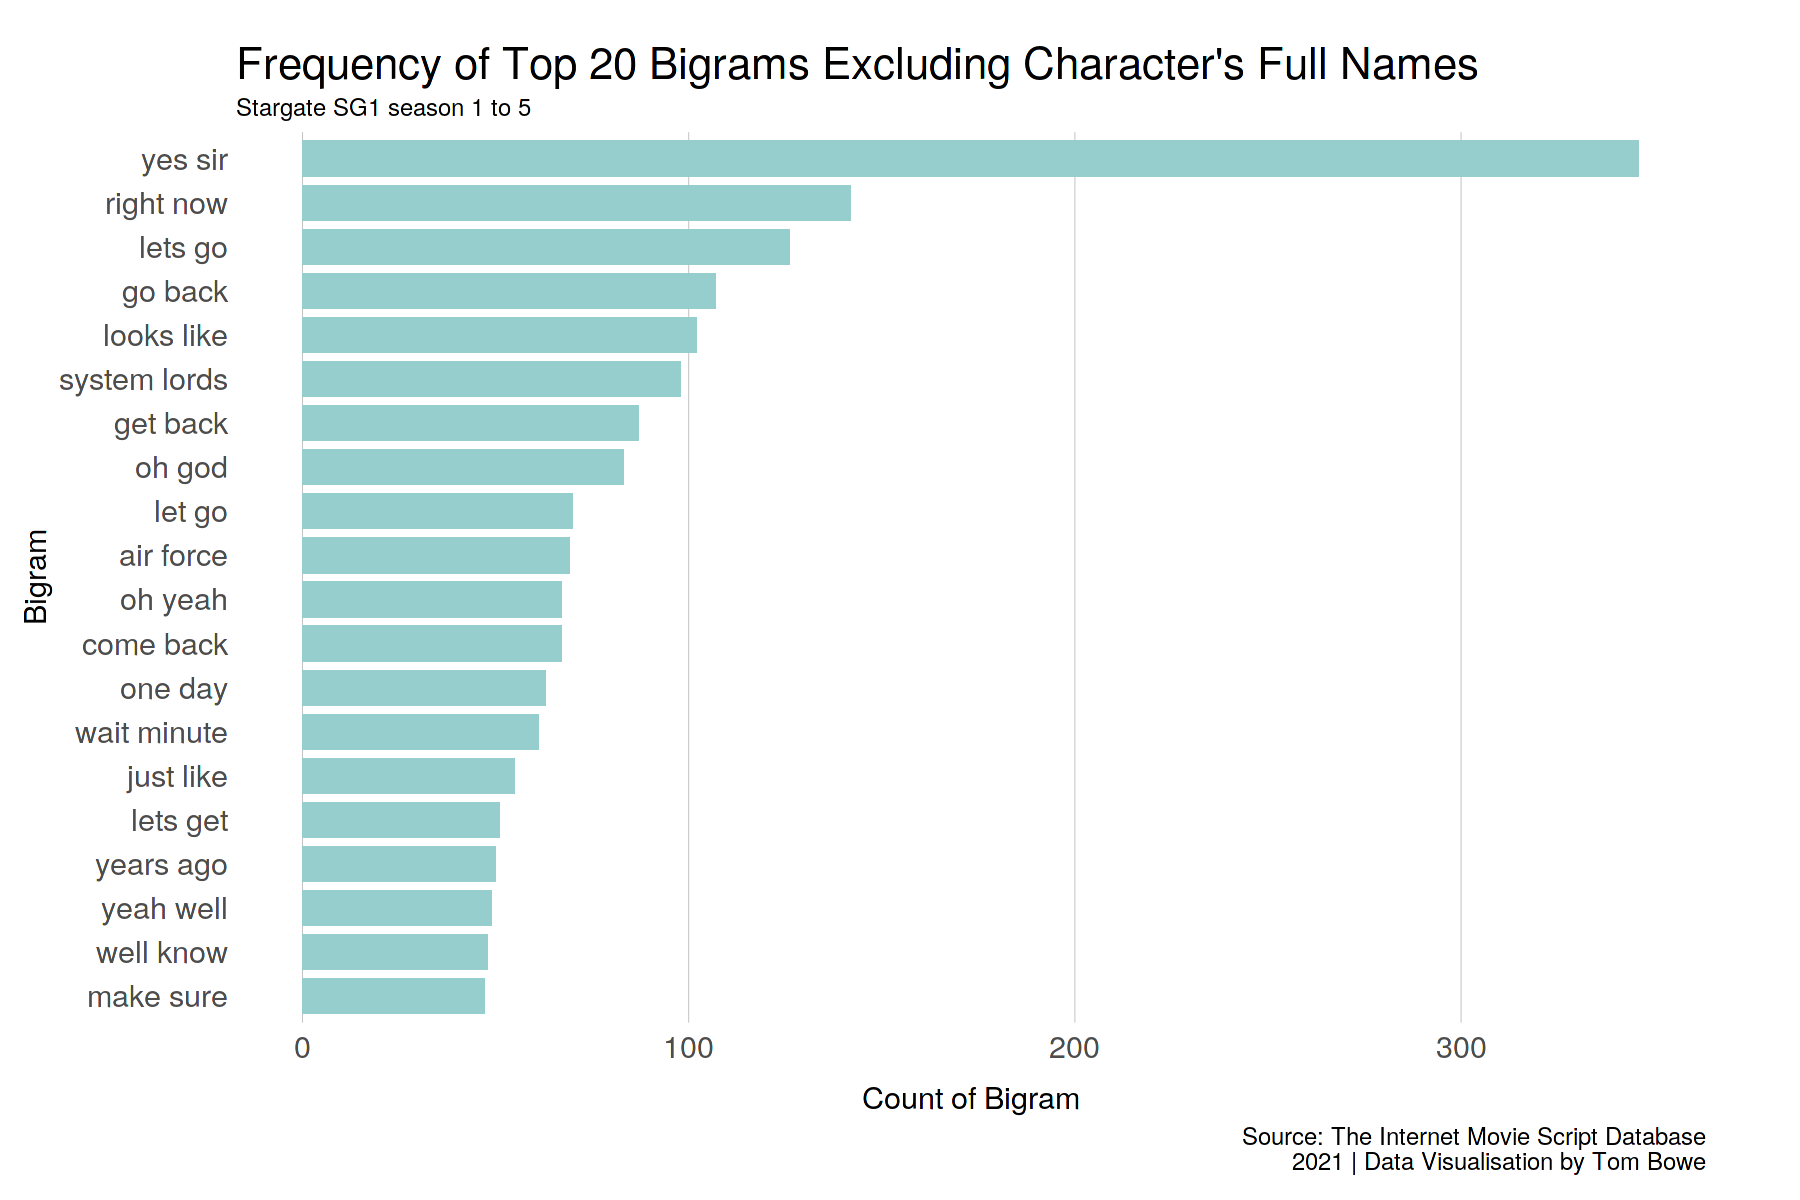

In [19]:
# Visualise:
fig_height(10)
ggplot(bigrams, aes(x = reorder(word, freq), y = freq)) +
  scale_y_continuous(labels = comma) +
  geom_bar(stat = "identity",
           fill = "paleturquoise3",
           width = .8) +
  theme_tb() +
  theme_tb_vert() +
  coord_flip() +
  labs(
    y = "Count of Bigram",
    x = "Bigram",
    title = "Frequency of Top 20 Bigrams Excluding Character's Full Names",
    subtitle = "Stargate SG1 season 1 to 5",
    caption = capt
  )

## Which Chevrons Were Locked/Encoded the Most?
Each chevron # is a bigram, and although I didn't use the bigram tokeniser function to do this analysis, it still belongs here. So which chevron on the stargate did we see the most?

Predictably, 7 featured the most while 8 was only locked once in Season 2 Episode 16 "The Fifth Race" when O'Neill travels to a different galaxy using the additional chevron.

Chevron number 3 was the least popular to note in dialogue as the gate was dialing, and also an interesting note was the distinct lack of chevron encoding/locking in season 3.

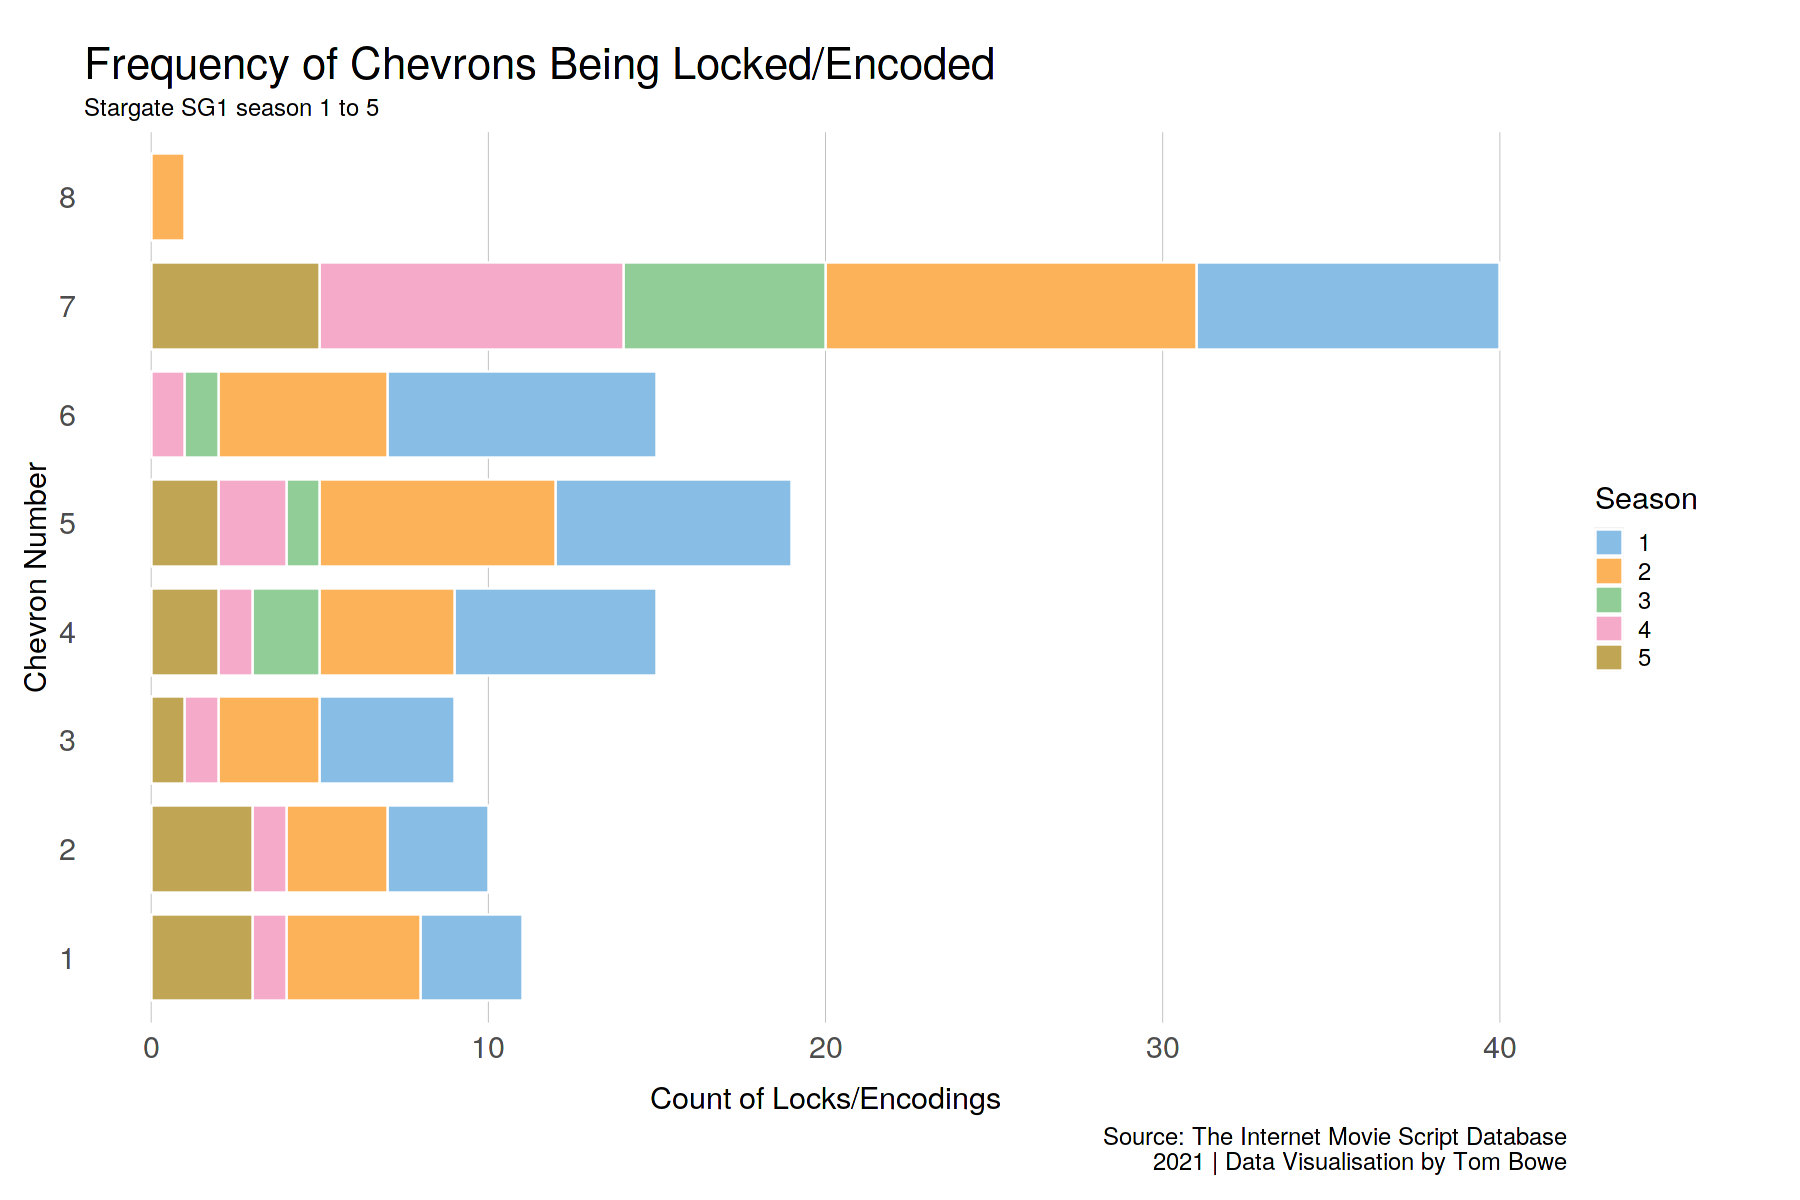

In [20]:
# Arrange the data:
chevronlocked <-
  subset(
    sg1tokenised,
    content %in% c(
      "chevron",
      "one",
      "two",
      "three",
      "four",
      "five",
      "six",
      "seven",
      "eight",
      "nine"
    )
  ) %>%
  group_by(index, season_number) %>%
  mutate(content = paste0(content, collapse = " ")) %>%
  unique() %>%
  subset(grepl("chevron", content)) %>%
  separate_rows(content, sep = " ") %>%
  subset(content != "chevron") %>%
  mutate(content = str_replace_all(content, "one", "1")) %>%
  mutate(content = str_replace_all(content, "two", "2")) %>%
  mutate(content = str_replace_all(content, "three", "3")) %>%
  mutate(content = str_replace_all(content, "four", "4")) %>%
  mutate(content = str_replace_all(content, "five", "5")) %>%
  mutate(content = str_replace_all(content, "six", "6")) %>%
  mutate(content = str_replace_all(content, "seven", "7")) %>%
  mutate(content = str_replace_all(content, "eight", "8")) %>%
  group_by(season_number, content) %>%
  tally() %>%
  mutate(season_number = as.character(season_number))

# Visualise:
fig_height(10)
ggplot(chevronlocked, aes(x = content, y = n, fill = season_number)) +
  scale_y_continuous(labels = comma) +
  geom_bar(stat = "identity",
           colour = "white",
           width = .8) +
  theme_tb() +
  theme_tb_vert() +
  scale_fill_few(palette = "Light", name = "Season") +
  coord_flip() +
  labs(
    y = "Count of Locks/Encodings",
    x = "Chevron Number",
    title = "Frequency of Chevrons Being Locked/Encoded",
    subtitle = "Stargate SG1 season 1 to 5",
    caption = capt
  )

## Frequency of the Top Overall Trigrams
From these trigrams I am also getting a bit of an insight into a common 6-gram I.e. "what the hell are you doing".

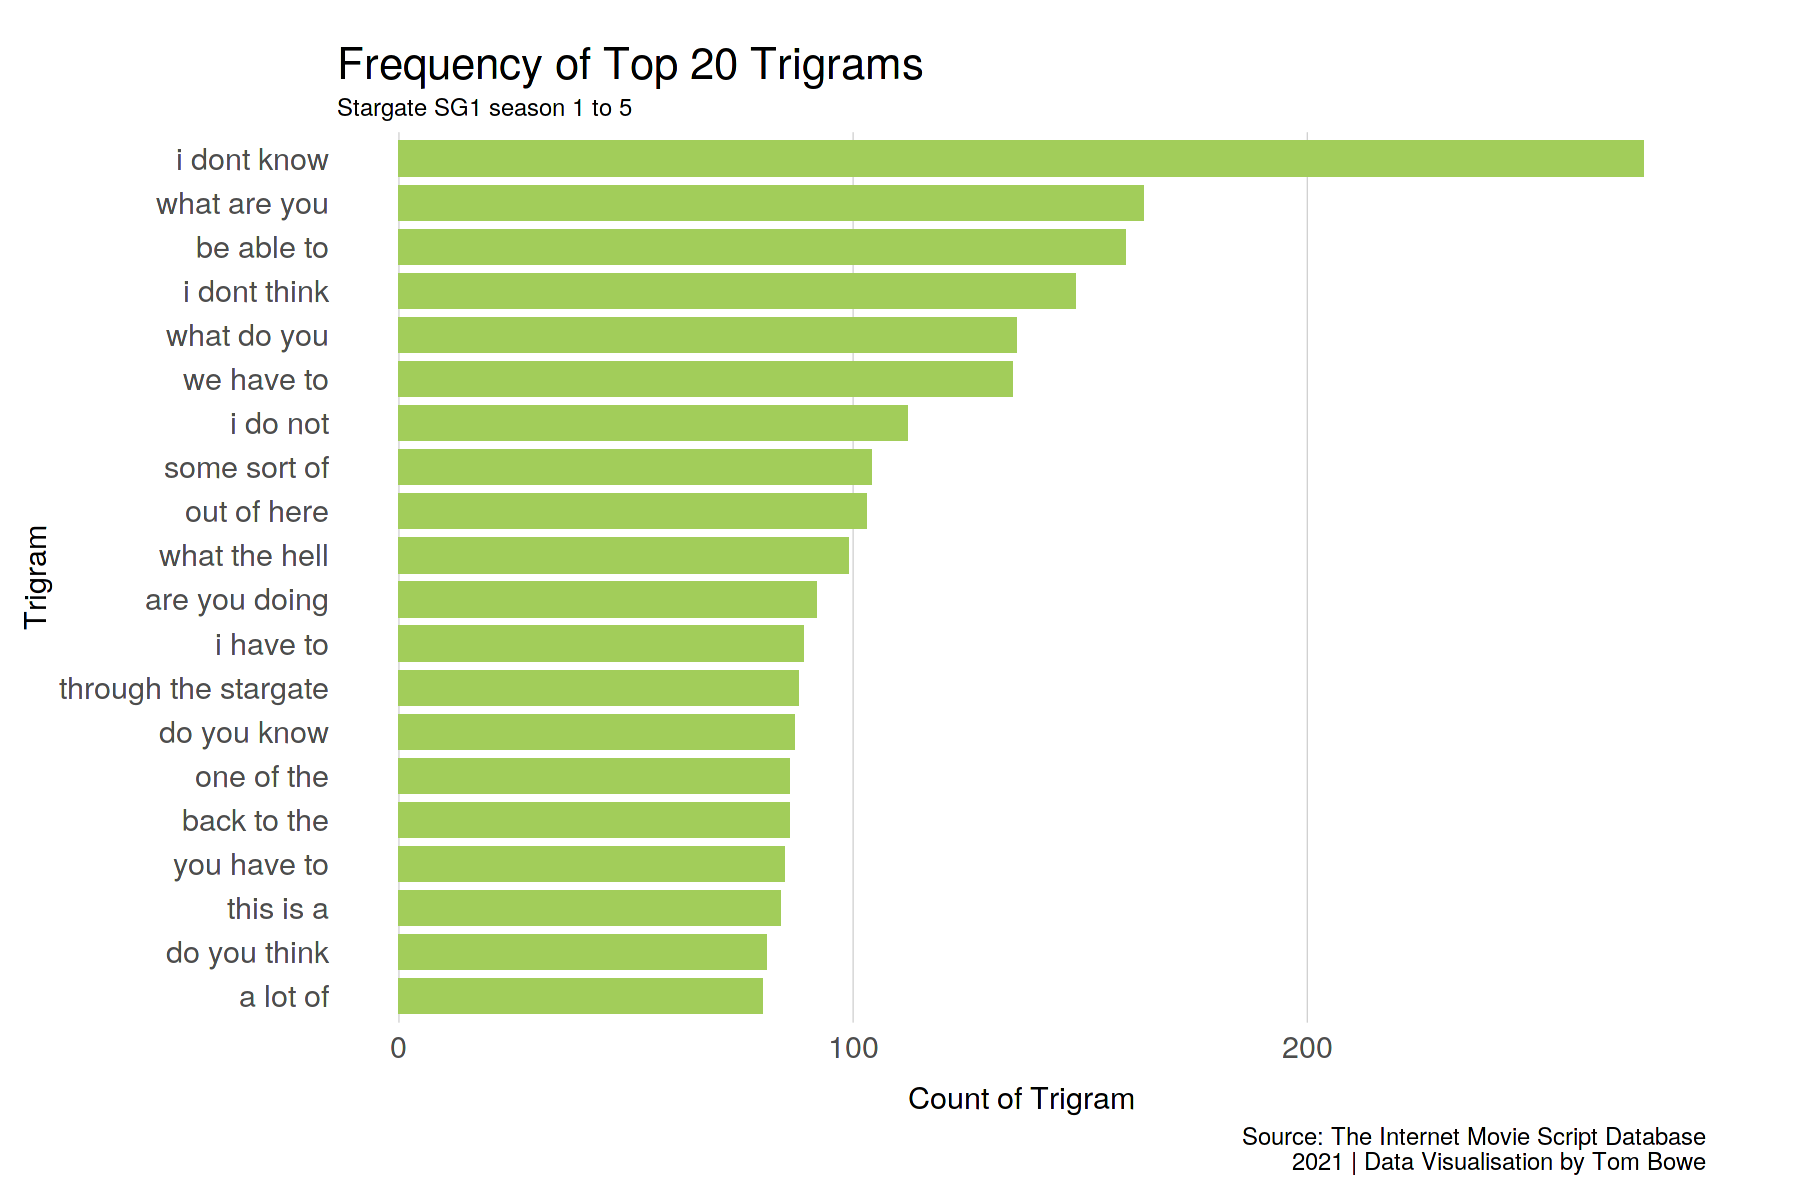

In [21]:
# Visualise:
fig_height(10)
ggplot(trigrams, aes(x = reorder(word, freq), y = freq)) +
  scale_y_continuous(labels = comma) +
  geom_bar(stat = "identity",
           fill = "darkolivegreen3",
           width = .8) +
  theme_tb() +
  theme_tb_vert() +
  coord_flip() +
  labs(
    y = "Count of Trigram",
    x = "Trigram",
    title = "Frequency of Top 20 Trigrams",
    subtitle = "Stargate SG1 season 1 to 5",
    caption = capt
  )

## Frequency of the Top Overall Quadrigrams
I'm starting to get the impression that SG1 don't seem to know what they are doing a lot of the time!

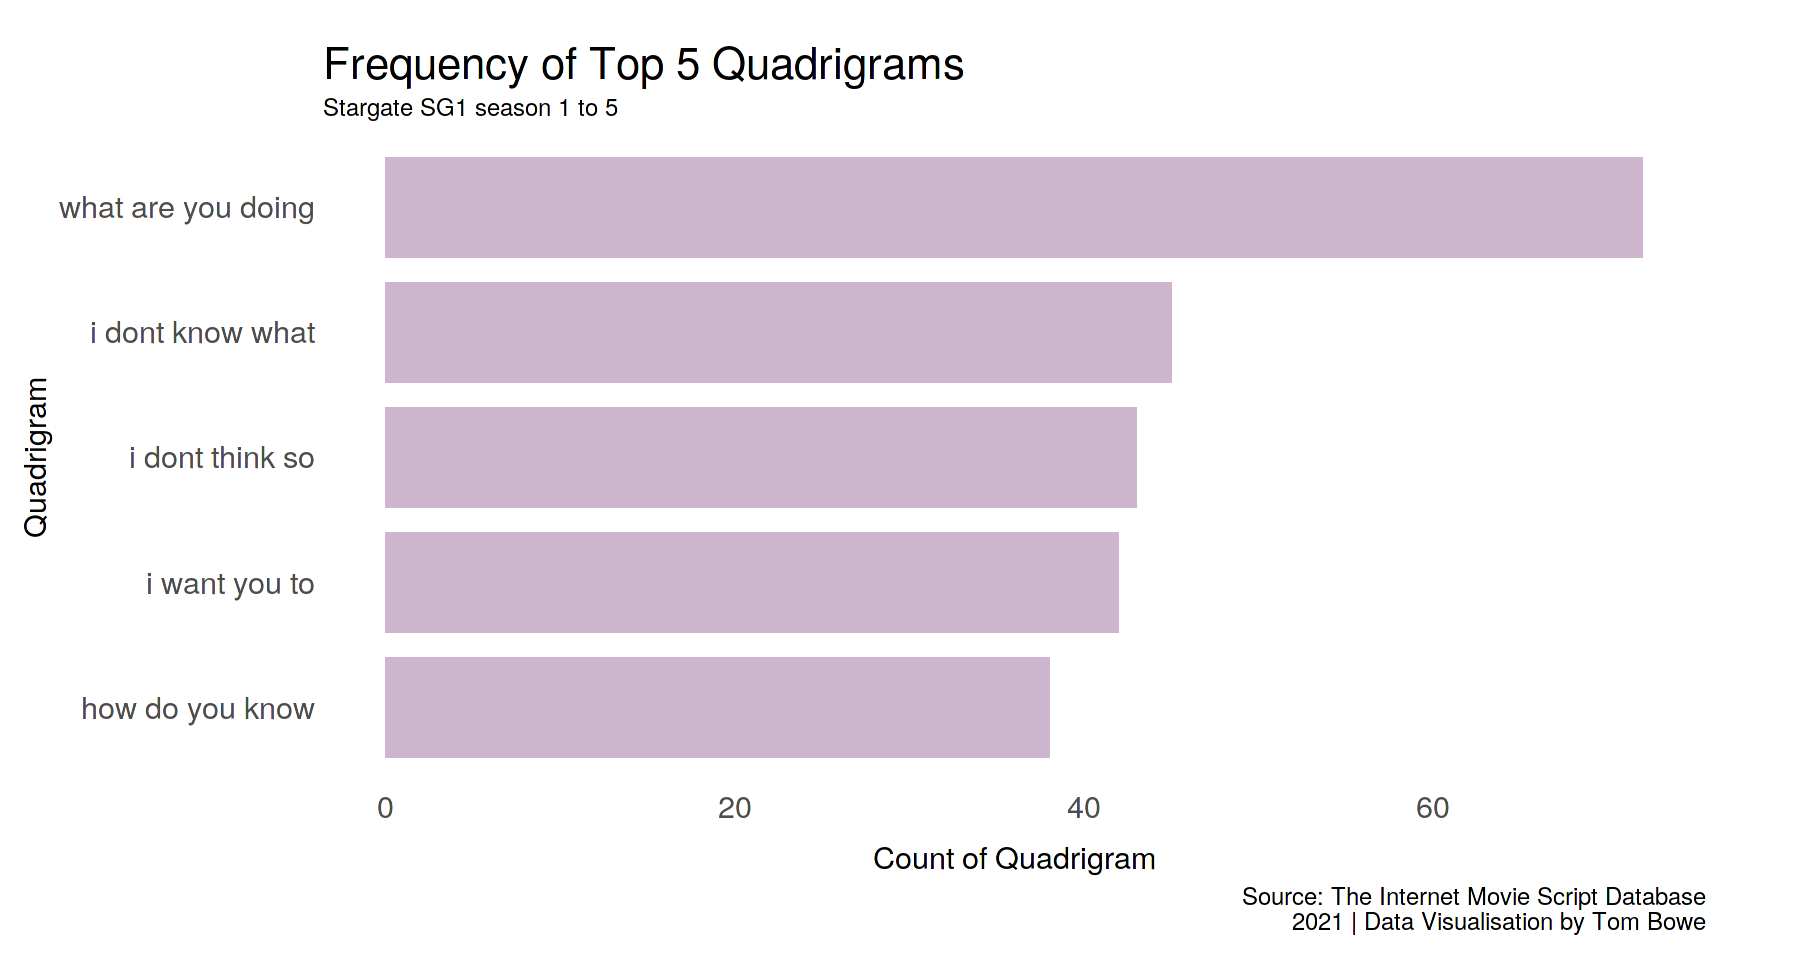

In [22]:
# Visualise:
fig_height(8)
ggplot(quadrigrams, aes(x = reorder(word, freq), y = freq)) +
  scale_y_continuous(labels = comma) +
  geom_bar(stat = "identity",
           fill = "thistle3",
           width = 0.8) +
  theme_tb() +
  coord_flip() +
  labs(
    y = "Count of Quadrigram",
    x = "Quadrigram",
    title = "Frequency of Top 5 Quadrigrams",
    subtitle = "Stargate SG1 season 1 to 5",
    caption = capt
  )

## Jack O'Neill One Liners
As with Teal'c and "Indeed" I am keen to visualise the frequency of Jack O'Neill one liners. I also stretched this to be common components of one liners such as anything to do with C4, or using the word Honkin' to describe anything. I note in the text the transcribers often switch between "*aw* for crying out loud", or "*oh* for crying out loud", I consider these the same thing so I accomodate appropriately:

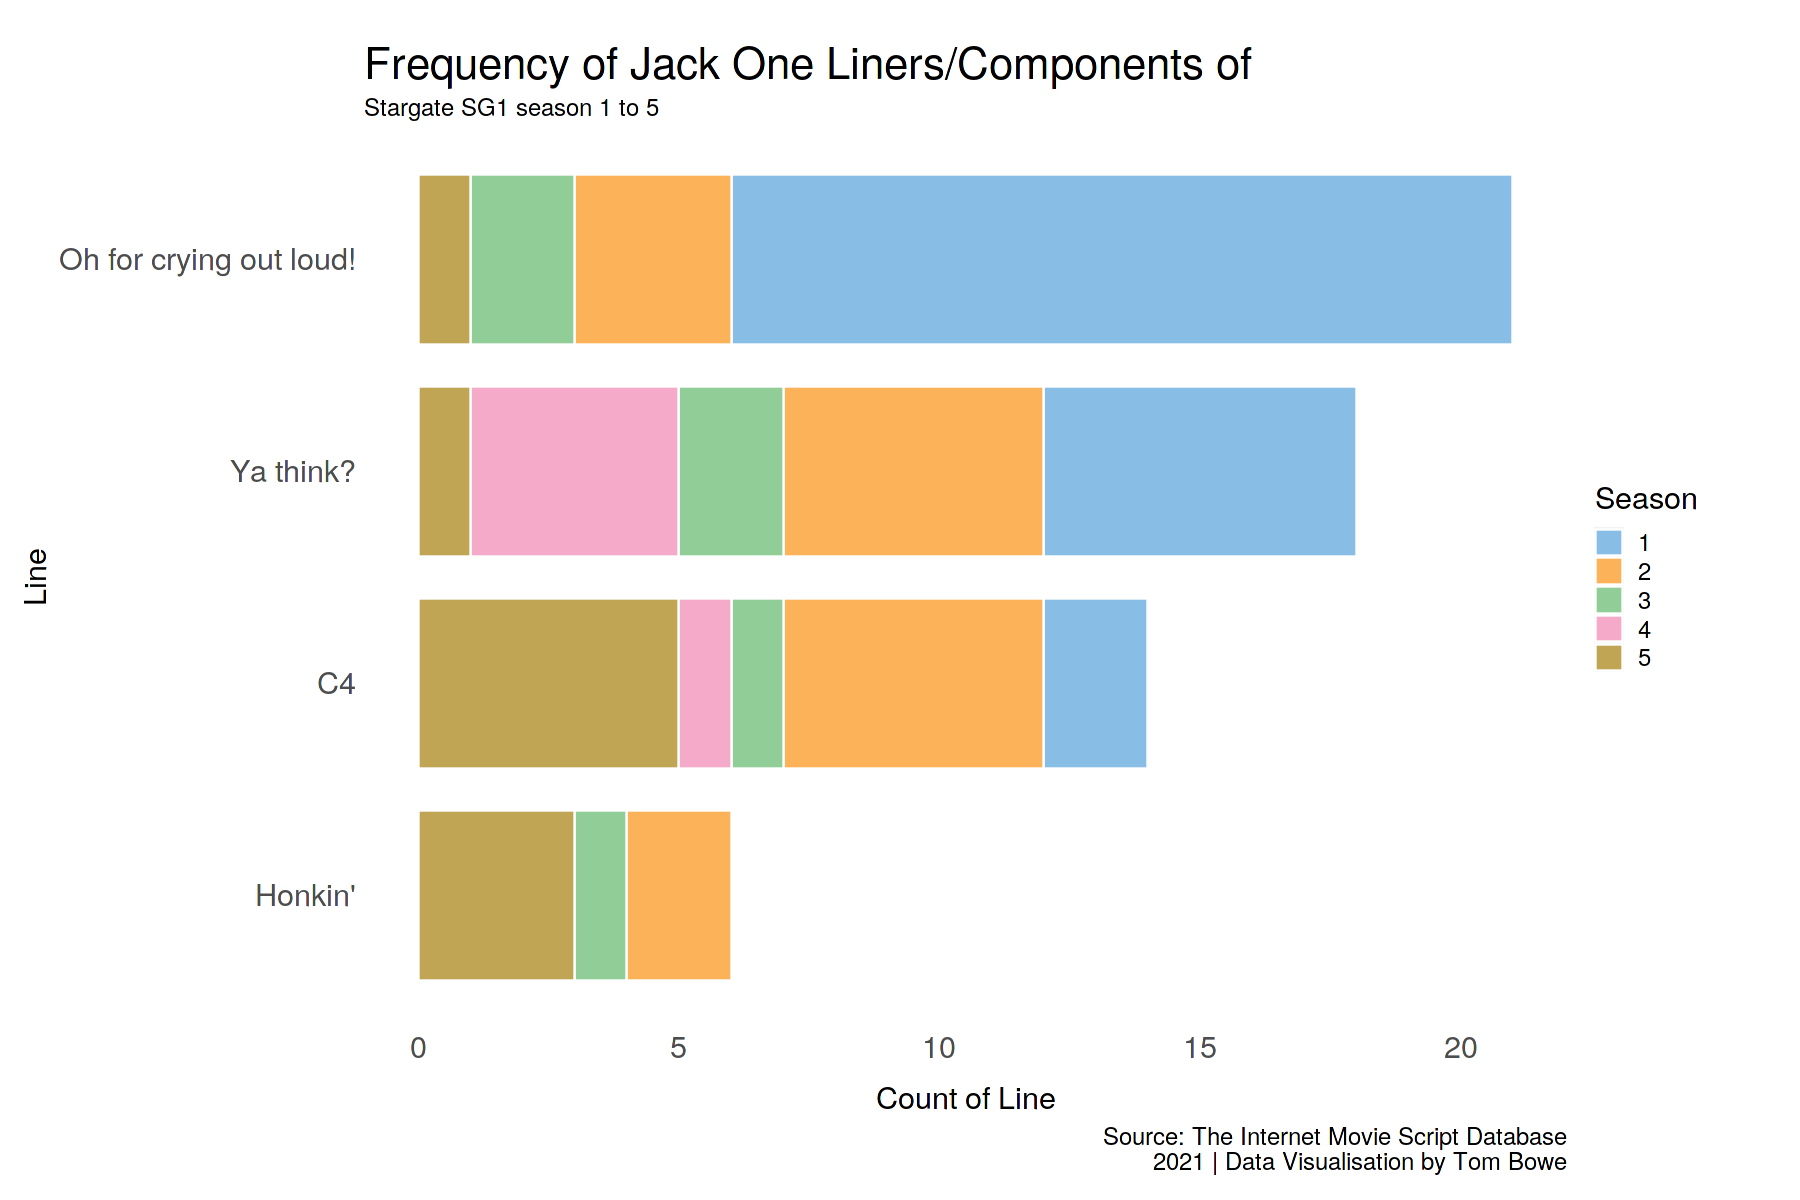

In [23]:
# Arrange the data:
oneliners <-
  subset(sg, grepl("c4", content)) %>%
  bind_rows(subset(sg, grepl("honkin", content)),
            subset(sg, grepl("ya think", content)),
            subset(sg, grepl("for crying out loud", content))) %>%
  mutate(
    line = case_when(
      str_detect(content, "honkin") == TRUE ~ "Honkin'",
      str_detect(content, "c4") == TRUE ~ "C4",
      str_detect(content, "ya think") == TRUE ~ "Ya think?",
      str_detect(content, "for crying out loud") == TRUE ~ "Oh for crying out loud!",
      TRUE ~ "Other"
    )
  )
onelinersgrouped <-
  subset(oneliners, character == "jack") %>%
  group_by(line, season_number) %>% tally() %>%
  mutate(season_number = as.character(season_number))

# Visualise:
fig_height(10)
ggplot(onelinersgrouped, aes(
  x = reorder(line, n, sum),
  y = n,
  fill = season_number
)) +
  geom_bar(stat = "identity",
           colour = "white",
           width = 0.8) +
  theme_tb() +
  scale_fill_few(palette = "Light", name = "Season") +
  coord_flip() +
  labs(
    y = "Count of Line",
    x = "Line",
    title = "Frequency of Jack One Liners/Components of",
    subtitle = "Stargate SG1 season 1 to 5",
    caption = capt
  )

# Sentiment Analysis
I approach the sentiment analysis via 3 methods:

1. A binary method using the BING lexicon where each word is rated as either positive or negative and I count how many of each to get a sentiment score. 
2. A rated valence method using the AFINN lexicon where each word is given a score of between -5 and +5 which I can summarise to get a sentiment score.
3. A more granular method of word categorisation using the NRC lexicon. Each word is attributed either Anger, Joy, Sadness, Trust, etc.

First I create the data frames for each lexicon we will use then we proceed with the analysis.

In [24]:
# Create the BING Lexicon data frame:
sg1bing <- 
  rename(sg1tokenised, word = content) %>%
  inner_join(get_sentiments("bing"))
# Create the AFINN Lexicon data frame:
sg1afinn <- 
  rename(sg1tokenised, word = content) %>%
  inner_join(afinn, "word")
# Create the NRV Lexicon data frame
sg1nrc <- 
  rename(sg1tokenised, word = content) %>%
  inner_join(nrc, "word")

Joining, by = "word"



### Summary of the Sentiment of All Episodes Available Using the BING Lexicon

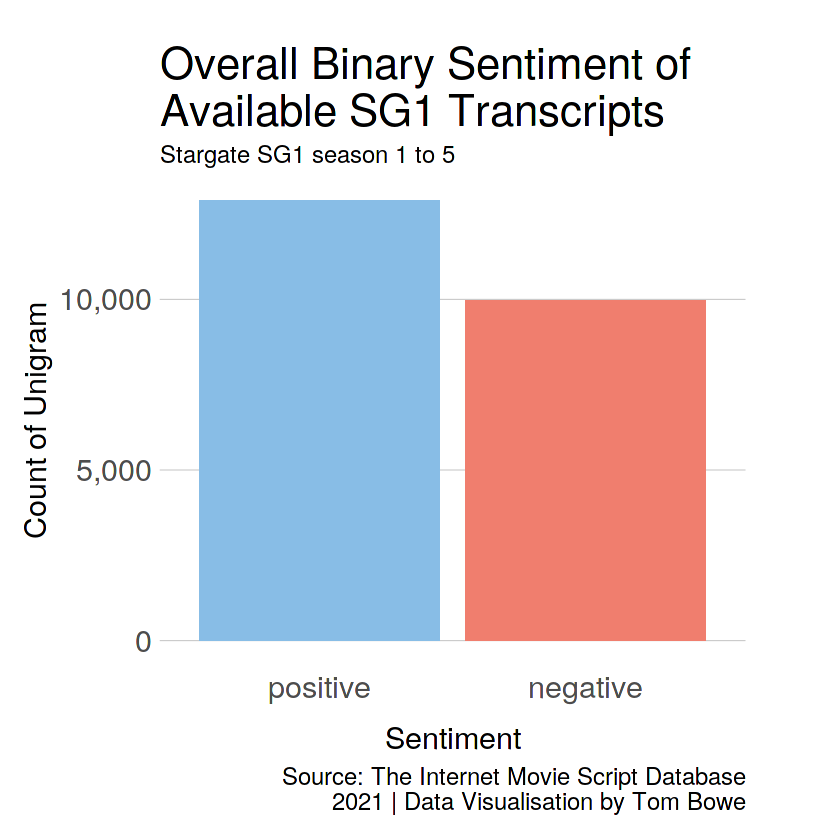

In [25]:
# Arrange the data:
sg1bingsummary <-
  count(sg1bing, sentiment, sort = TRUE)

# Visualise:
options(repr.plot.width = 7, repr.plot.height = 7)
ggplot(sg1bingsummary, aes(
  x = reorder(sentiment, -n),
  y = n,
  fill = sentiment
)) +
  scale_y_continuous(labels = comma) +
  geom_bar(stat = "identity") +
  scale_fill_manual(values = c("#F07E6E", "#88BDE6"), name = "Sentiment") +
  theme_tb() +
  theme_tb_hori() +
  theme(legend.position = "none") +
  labs(
    y = "Count of Unigram",
    x = "Sentiment",
    title = "Overall Binary Sentiment of \nAvailable SG1 Transcripts",
    subtitle = "Stargate SG1 season 1 to 5",
    caption = capt
  )

### Most Frequent Unigrams and Their Sentiment Based on the BING Lexicon

In [26]:
# Export the data:
tealc <-
  subset(sg1bing, character == "tealc") %>%
  count(word, sentiment, sort = TRUE) %>%   
  slice(1:60)
write.csv(tealc, "tealc_sentiment.csv")
apophis <- 
  subset(sg1bing, character == "apophis") %>%
  count(word, sentiment, sort = TRUE) %>% 
  slice(1:60)
write.csv(apophis, "apophis_sentiment.csv")

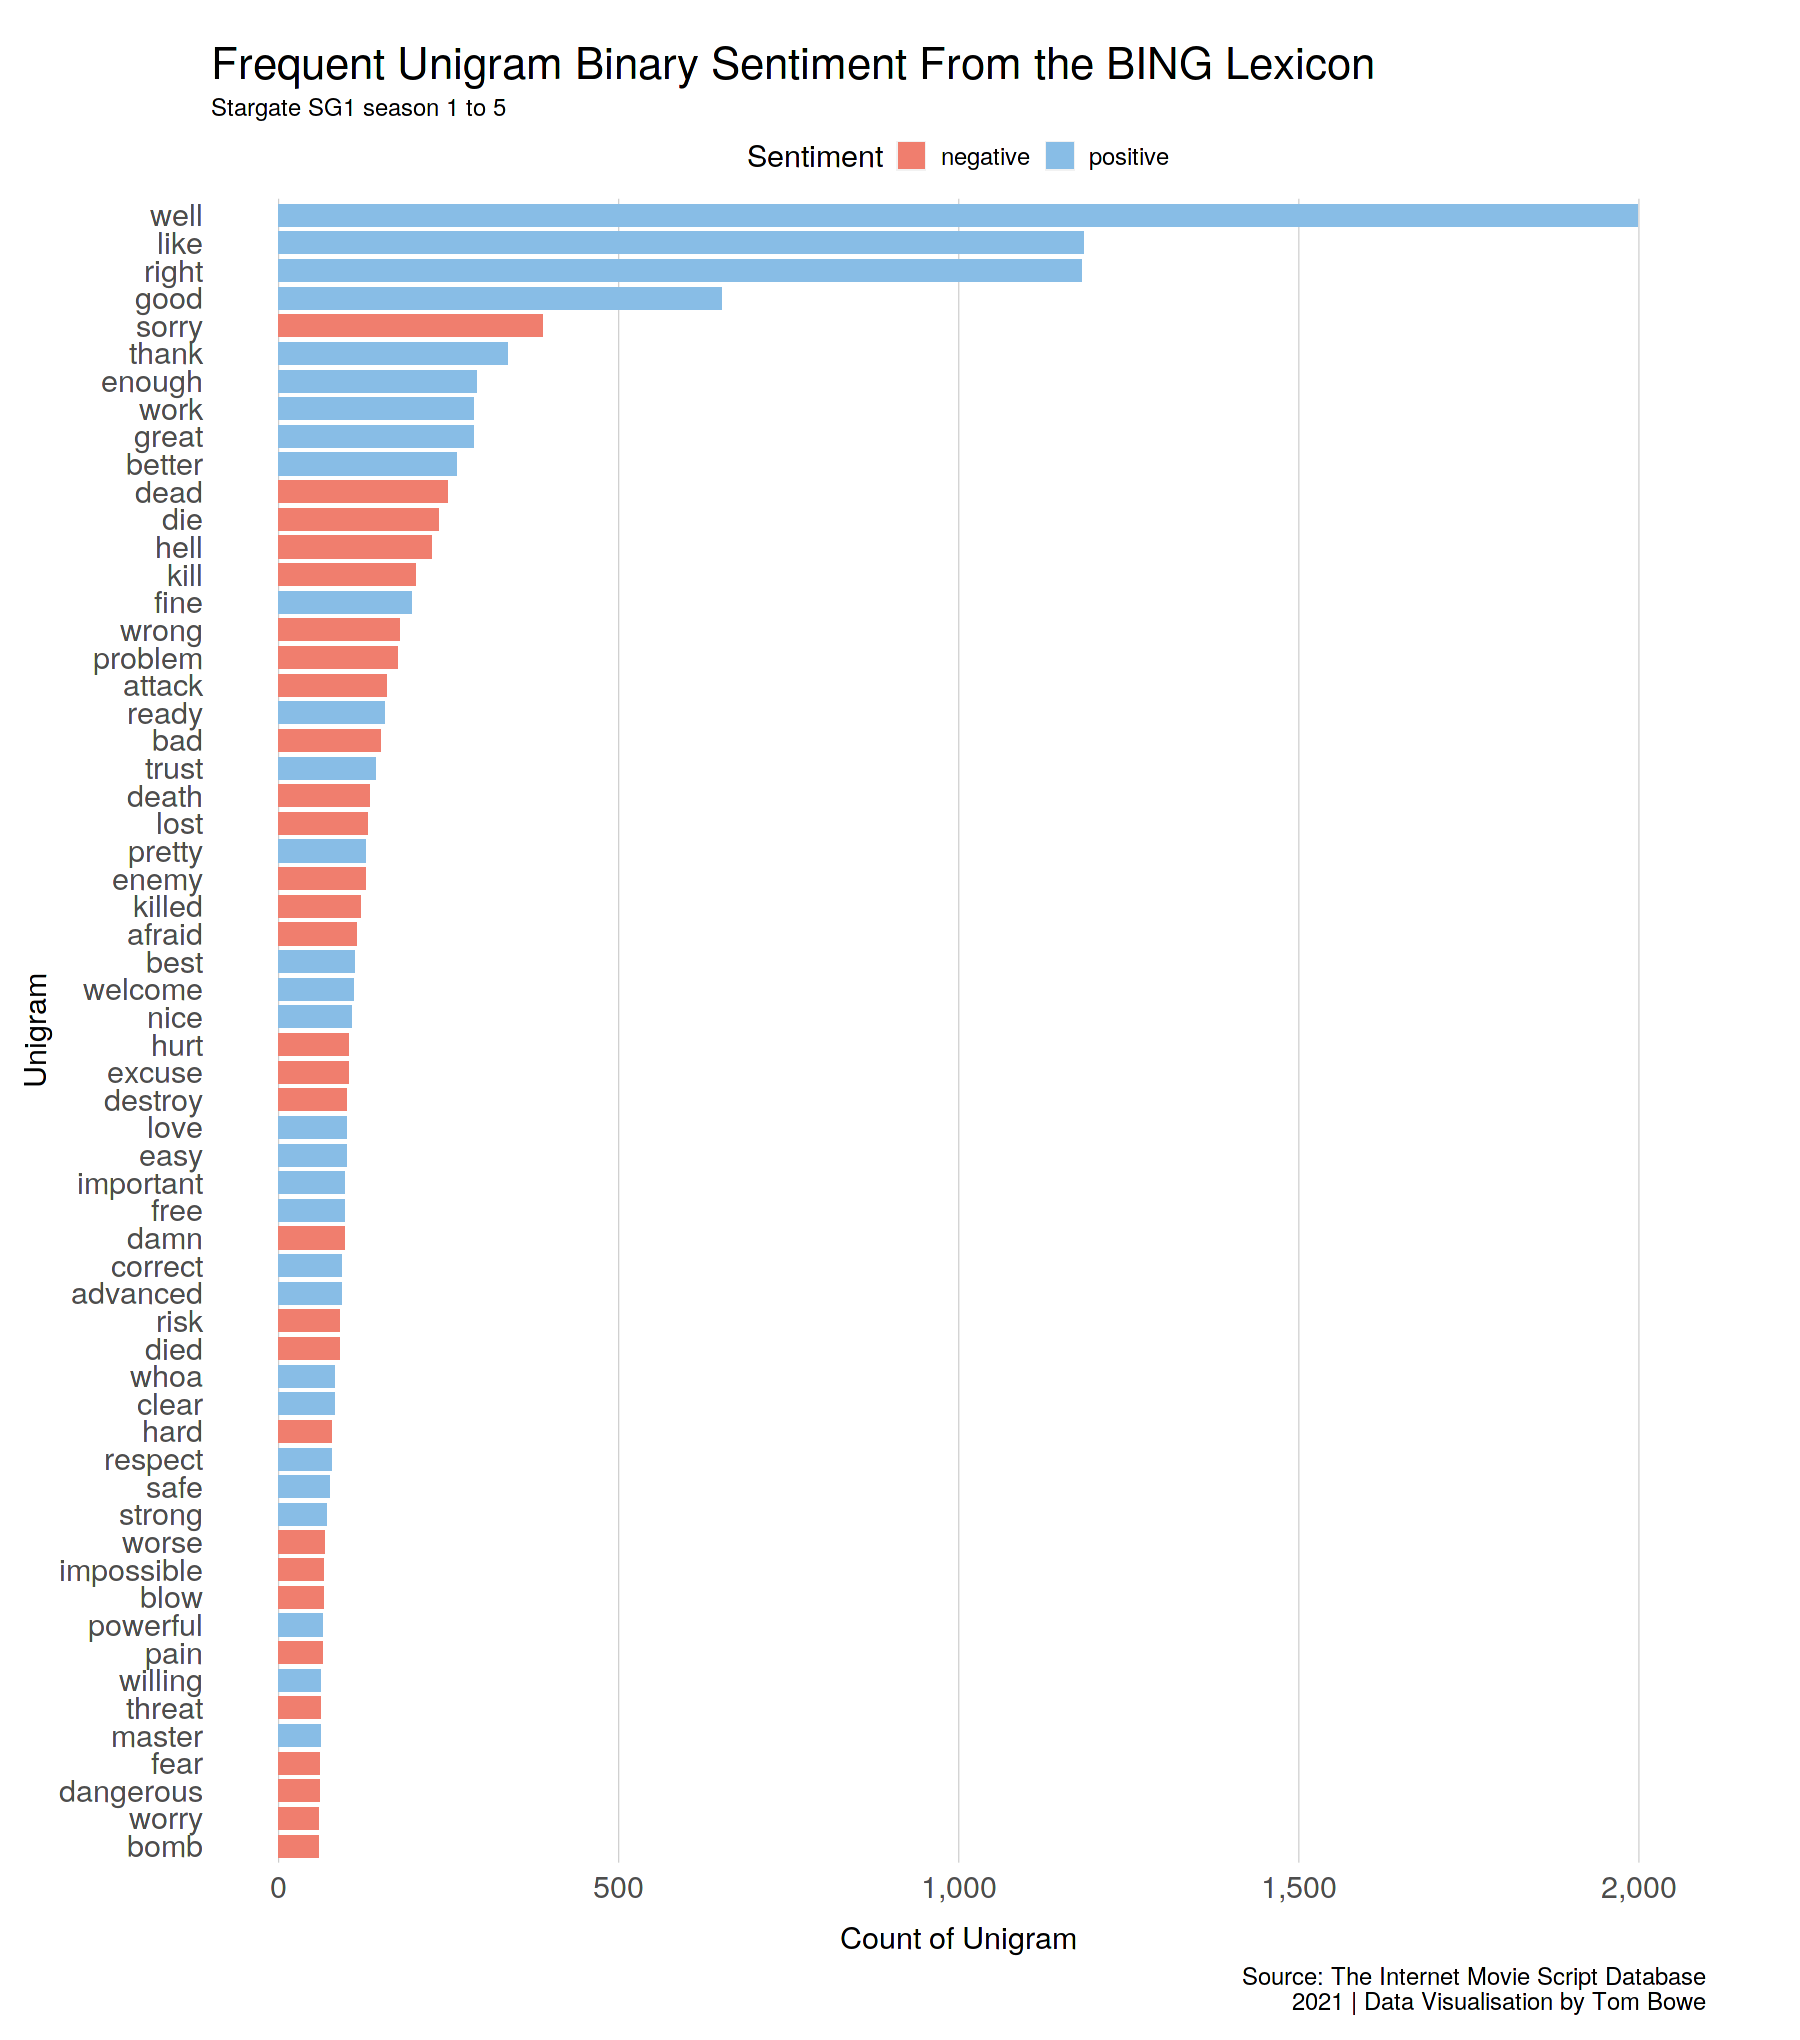

In [27]:
# Arrange the data:
sg1bingdetail <-
  count(sg1bing, word, sentiment, sort = TRUE) %>% slice(1:60)

# Visualise:
fig_height(17)
ggplot(sg1bingdetail, aes(
  x = reorder(word, n),
  y = n,
  fill = sentiment
)) +
  scale_y_continuous(labels = comma) +
  geom_bar(stat = "identity",
           width = 0.8) +
  scale_fill_manual(values = c("#F07E6E", "#88BDE6"), name = "Sentiment") +
  theme_tb() +
  theme_tb_vert() +
  theme(legend.position = "top") +
  coord_flip() +
  labs(
    y = "Count of Unigram",
    x = "Unigram",
    title = "Frequent Unigram Binary Sentiment From the BING Lexicon",
    subtitle = "Stargate SG1 season 1 to 5",
    caption = capt
  )

### Sentiment Trend For All Available Episodes Based on the BING Lexicon
I am able to now visualise the overall sentiment for each episode for all available seasons as a trend. The undulations of positive and negative are clearly visible.

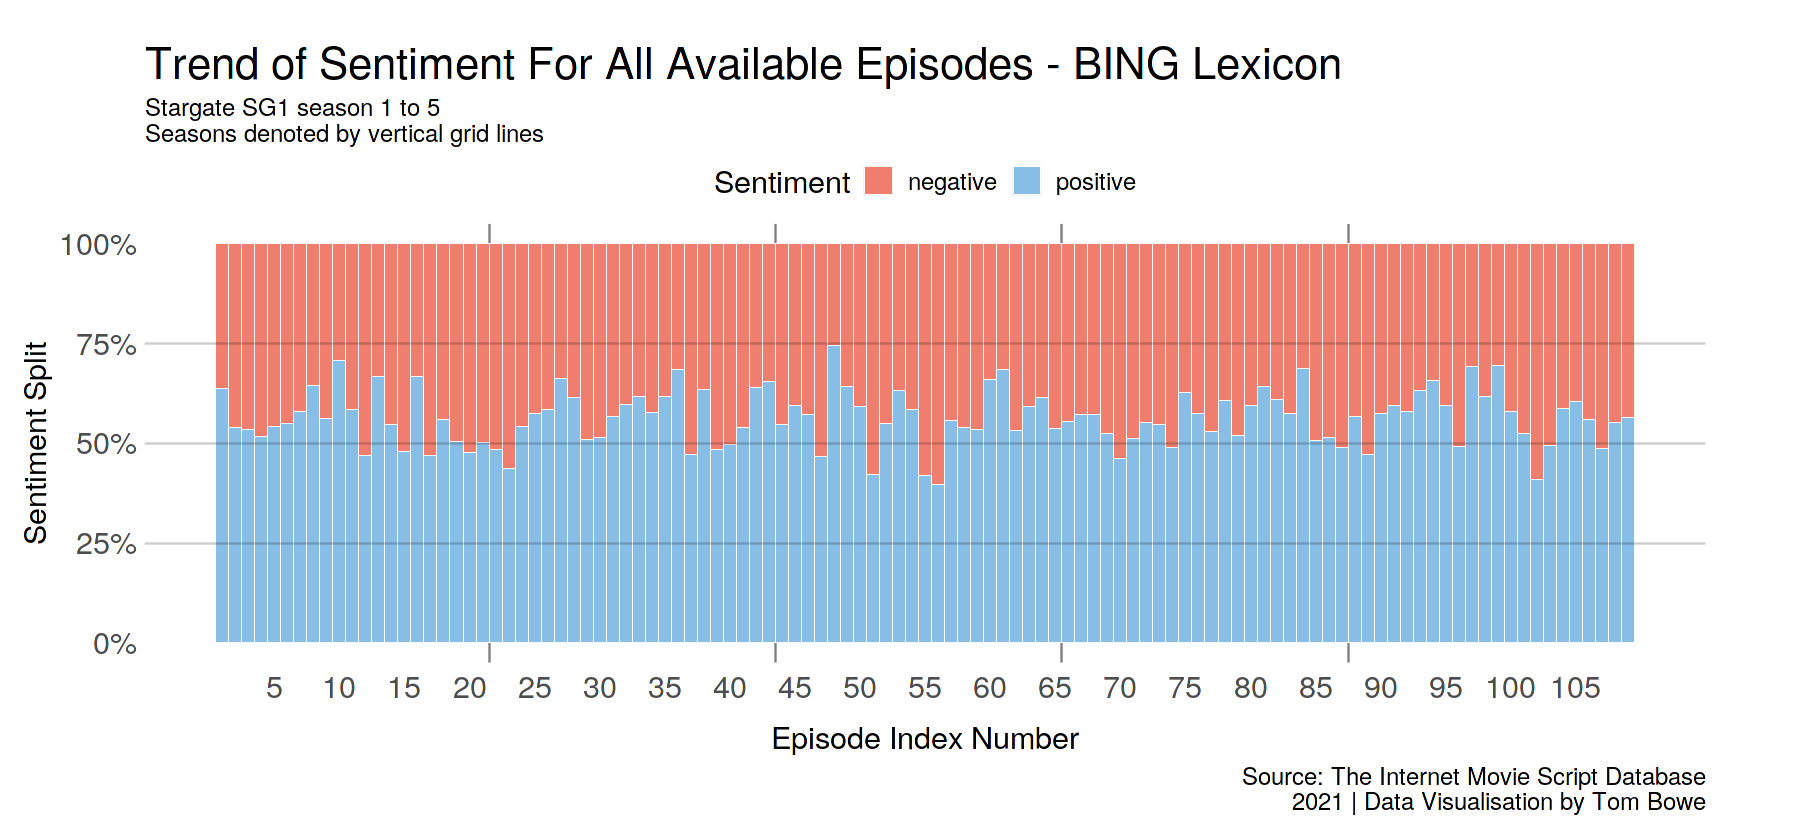

In [28]:
# Arrange the data:
sg1bingtrend <-
  count(sg1bing,
        season_number,
        episode_number,
        episode_index,
        sentiment,
        sort = FALSE)

# Visualise:
fig_height(7)
ggplot(sg1bingtrend, aes(x = episode_index, y = n, fill = sentiment)) +
  geom_vline(xintercept = 21.5,
             col = 1,
             alpha = .5) +
  geom_vline(xintercept = seq(43.5, 87.5, 22),
             col = 1,
             alpha = .5) +
  geom_bar(
    position = "fill",
    stat = "identity",
    colour = "white",
    size = 0.2,
    width = 1
  ) +
  geom_hline(yintercept = 0.25,
             col = 1,
             alpha = 0.2) +
  geom_hline(yintercept = 0.5,
             col = 1,
             alpha = 0.2) +
  geom_hline(yintercept = 0.75,
             col = 1,
             alpha = 0.2) +
  scale_fill_manual(values = c("#F07E6E", "#88BDE6"), name = "Sentiment") +
  scale_x_continuous(breaks = seq(from = 5, to = 105, by = 5)) +
  scale_y_continuous(labels = percent_format()) +
  theme_tb() +
  theme(legend.position = "top") +
  labs(
    y = "Sentiment Split",
    x = "Episode Index Number",
    title = "Trend of Sentiment For All Available Episodes - BING Lexicon",
    subtitle = "Stargate SG1 season 1 to 5
Seasons denoted by vertical grid lines",
    caption = capt
  )

### Sentiment Trend For All Available Episodes Using the AFINN Lexicon
I note a very similar trend using the AFINN lexicon when compared to the BING lexicon which is a good sign.

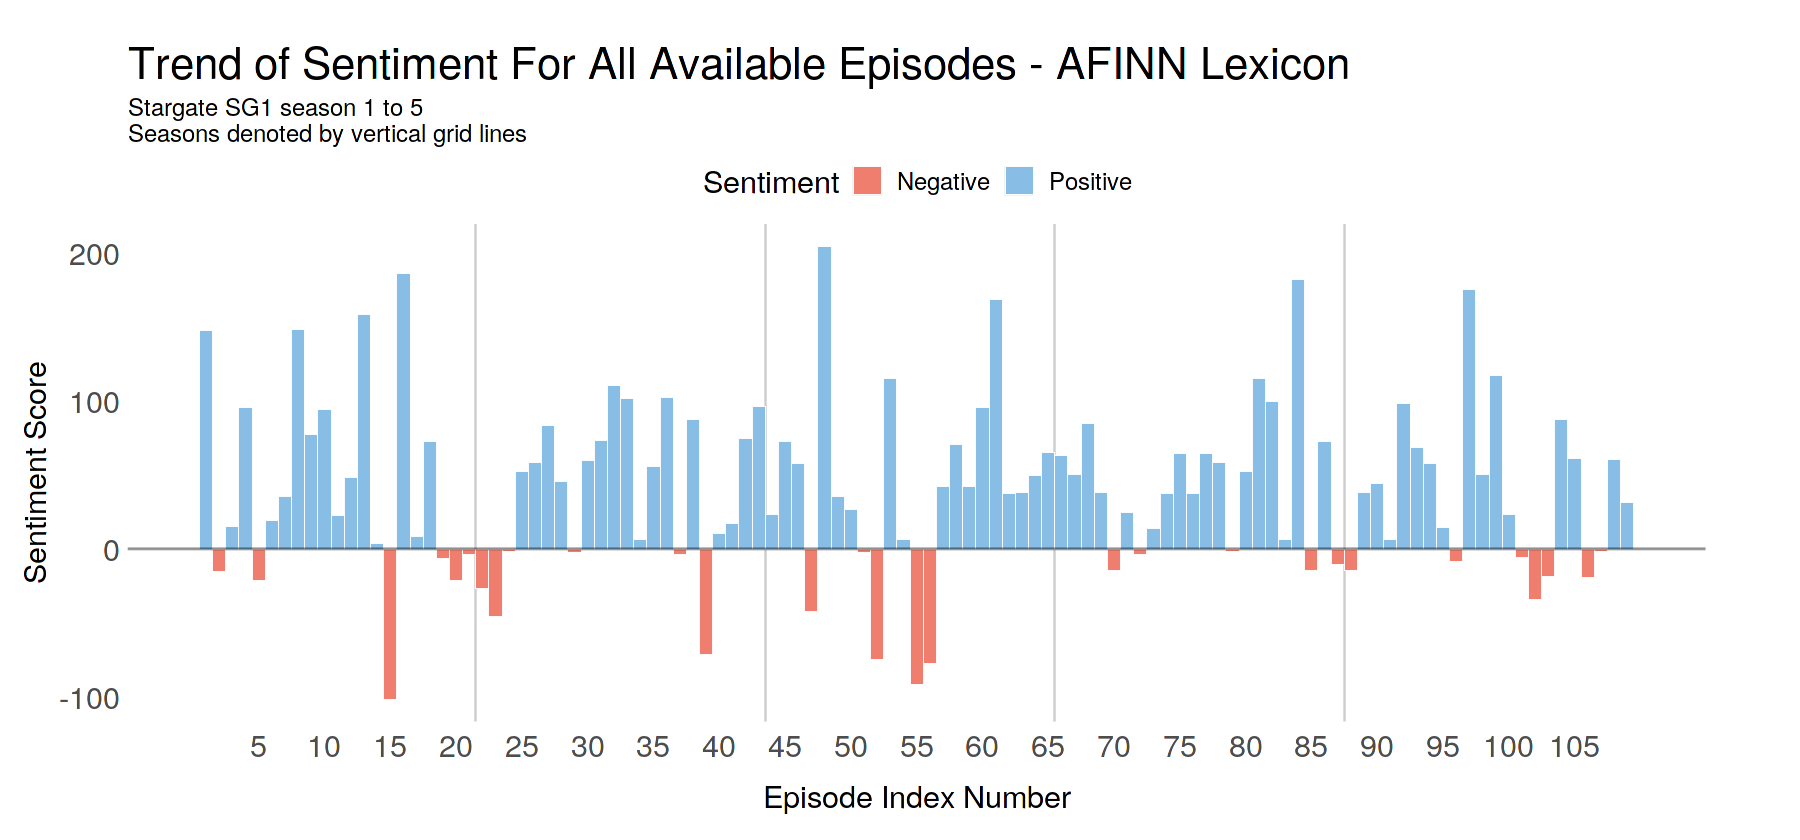

In [29]:
# Arrange the data:
sg1afinntrend <- 
  group_by(sg1afinn, episode_index) %>%
  summarise(weight = sum(value), .groups = 'drop') %>%
  mutate(sentiment = ifelse(weight < 0, "Negative","Positive"))

# Visualise:
fig_height(7)
  ggplot(sg1afinntrend, aes(x = episode_index, y = weight, fill = sentiment)) +
  geom_vline(xintercept = 21.5,
             col = 1,
             alpha = .2) +
  geom_vline(xintercept = seq(43.5, 87.5, 22),
             col = 1,
             alpha = .2) +
  geom_bar(stat = "identity", colour = "white", size = 0.2, width = 1) +
  geom_hline(yintercept = 0.25, col = 1, alpha = 0.2) +
  geom_hline(yintercept = 0.5, col = 1, alpha = 0.2) +
  geom_hline(yintercept = 0.75, col = 1, alpha = 0.2) +
  scale_fill_manual(values = c("#F07E6E", "#88BDE6"), name = "Sentiment") +
  scale_x_continuous(breaks = seq(from = 5, to = 105, by = 5)) +
  theme_tb() +
  theme(legend.position = "top") +
  labs(y = "Sentiment Score", 
       x = "Episode Index Number", 
       title = "Trend of Sentiment For All Available Episodes - AFINN Lexicon", 
       subtitle = "Stargate SG1 season 1 to 5\nSeasons denoted by vertical grid lines")

### Sentiment Trend by Member of SG1 Using the AFINN Lexicon
A heatmap is used to track the individual sentiment of SG1 team members over time from S01E01 to S05E22. Note the extremely positive sentiment for Carter in season 4 episode 19. In this episode she is trying to inspire a gifted Air Force cadet.

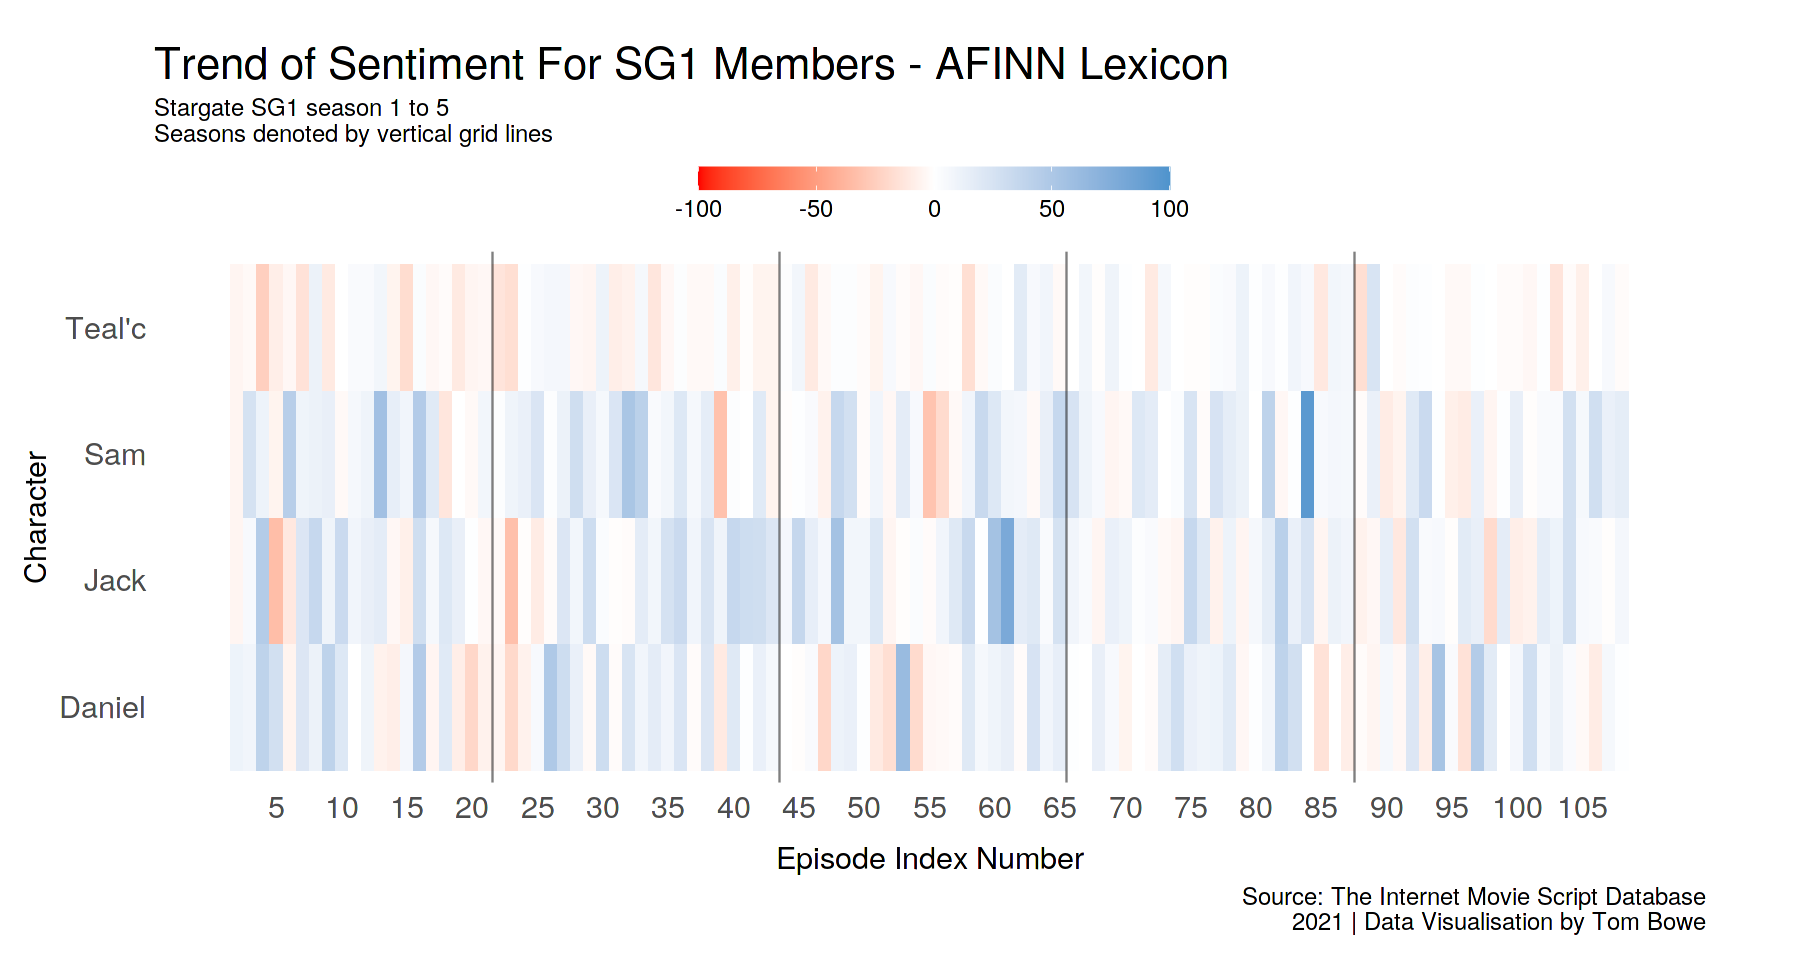

In [30]:
# Arrange the data:
hm <-
  group_by(sg1afinn, character, episode_index) %>%
  summarise(weight = sum(value),
            n = n(),
            .groups = 'drop') %>%
  subset(character %in% c("jack", "tealc", "sam", "daniel")) %>%
  mutate(character = str_replace_all(character, "jack", "Jack")) %>%
  mutate(character = str_replace_all(character, "daniel", "Daniel")) %>%
  mutate(character = str_replace_all(character, "sam", "Sam")) %>%
  mutate(character = str_replace_all(character, "tealc", "Teal'c"))

# Visualise
fig_height(8)
ggplot(data = hm, aes(y = character, x = episode_index, fill = weight)) +
  geom_tile() +
  scale_fill_gradient2(
    midpoint = 0,
    low = "red",
    mid = "white",
    high = "steelblue3",
    name = "Sentiment",
    limits = c(-100, 100)
  ) +
  geom_vline(xintercept = 21.5,
             col = 1,
             alpha = .5) +
  geom_vline(xintercept = seq(43.5, 87.5, 22),
             col = 1,
             alpha = .5) +
  theme_tb() +
  theme(
    legend.position = "top",
    legend.key.size = unit(0.5, "cm"),
    legend.key.width = unit(2, "cm"),
    legend.title = element_blank()
  ) +
  scale_x_continuous(breaks = seq(from = 5, to = 105, by = 5),
                     lim = c(1, 109)) +
  labs(
    y = "Character",
    x = "Episode Index Number",
    title = "Trend of Sentiment For SG1 Members - AFINN Lexicon",
    subtitle = "Stargate SG1 season 1 to 5\nSeasons denoted by vertical grid lines",
    caption = capt
  )

### What Made "Learning Curve" so Positive?
One episode that stands out from both methods is S03E05 "Learning Curve" where Jack develops a friendship with one of the Orbanian children and tries to save her from the Averium ritual which would basically turn her into a vegetable. The episode revolves around intelligence and the fact that kids should be having fun so I can see why it may garner a high positive rating.

I still want to quickly drill down and see exactly what words are contributing though:

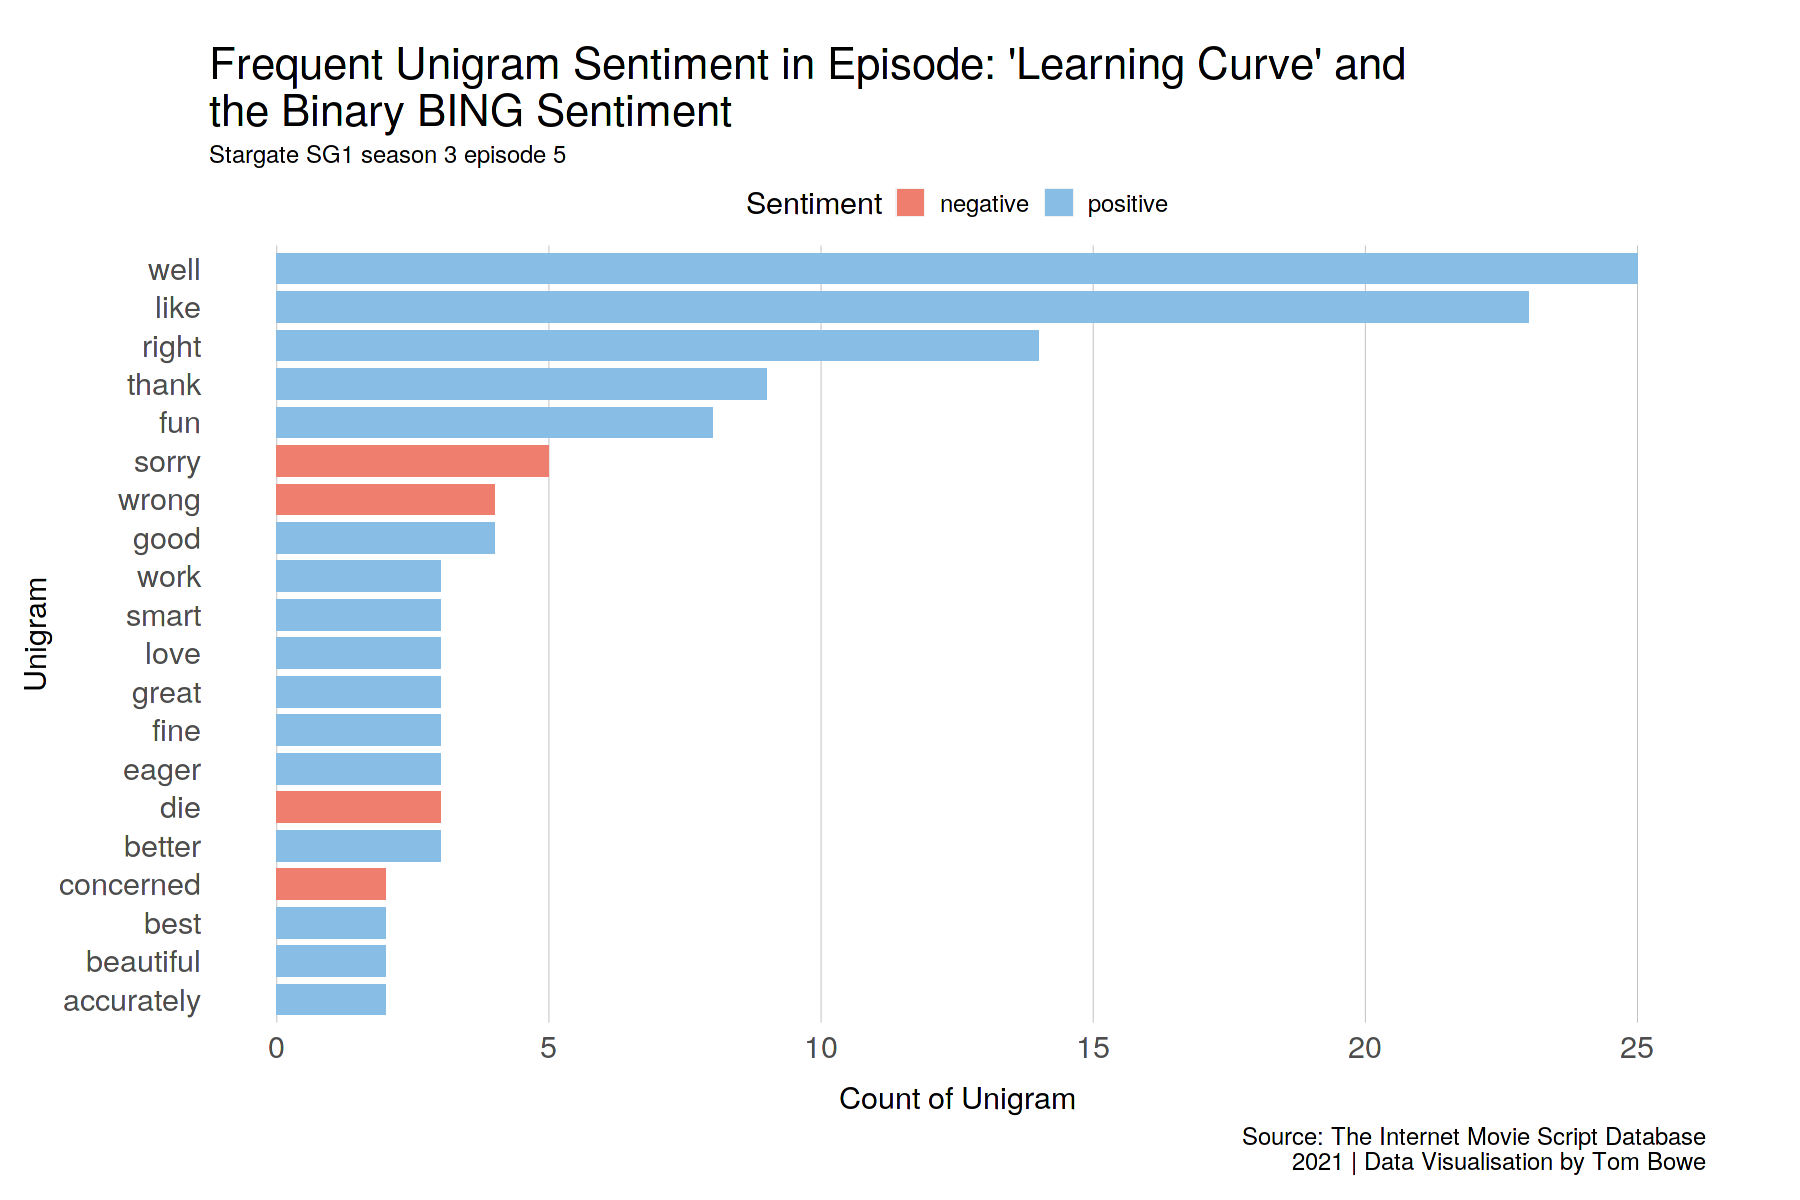

In [31]:
# Arrange the data:
sg1binglearn <-
  subset(sg1bing, episode_number == 5 & season_number == 3) %>%
  count(word, sentiment, sort = TRUE) %>%
  slice(1:20)

# Visualise:
fig_height(10)
ggplot(sg1binglearn, aes(
  x = reorder(word, n),
  y = n,
  fill = sentiment
)) +
  geom_bar(stat = "identity",
           width = 0.8) +
  scale_fill_manual(values = c("#F07E6E", "#88BDE6"), name = "Sentiment") +
  theme(legend.position = "top") +
  theme_tb() +
  theme_tb_vert() +
  coord_flip() +
  labs(
    y = "Count of Unigram",
    x = "Unigram",
    title = "Frequent Unigram Sentiment in Episode: 'Learning Curve' and\nthe Binary BING Sentiment",
    subtitle = "Stargate SG1 season 3 episode 5",
    caption = capt
  )

### What Made "Cor-Ai" so Negative?
An episode that stands out for its negativity in using the AFINN lexicon was "Cor-Ai" where SG1 travel to a planet that Teal'c once visited in his past life. He is accused of various crimes and the reasons for the accusations are given in great detail on multiple occasions.

I will drill down into the weighted scores of each of the most influential words in this episode that contributed to the very negative sentiment and see what I can find:

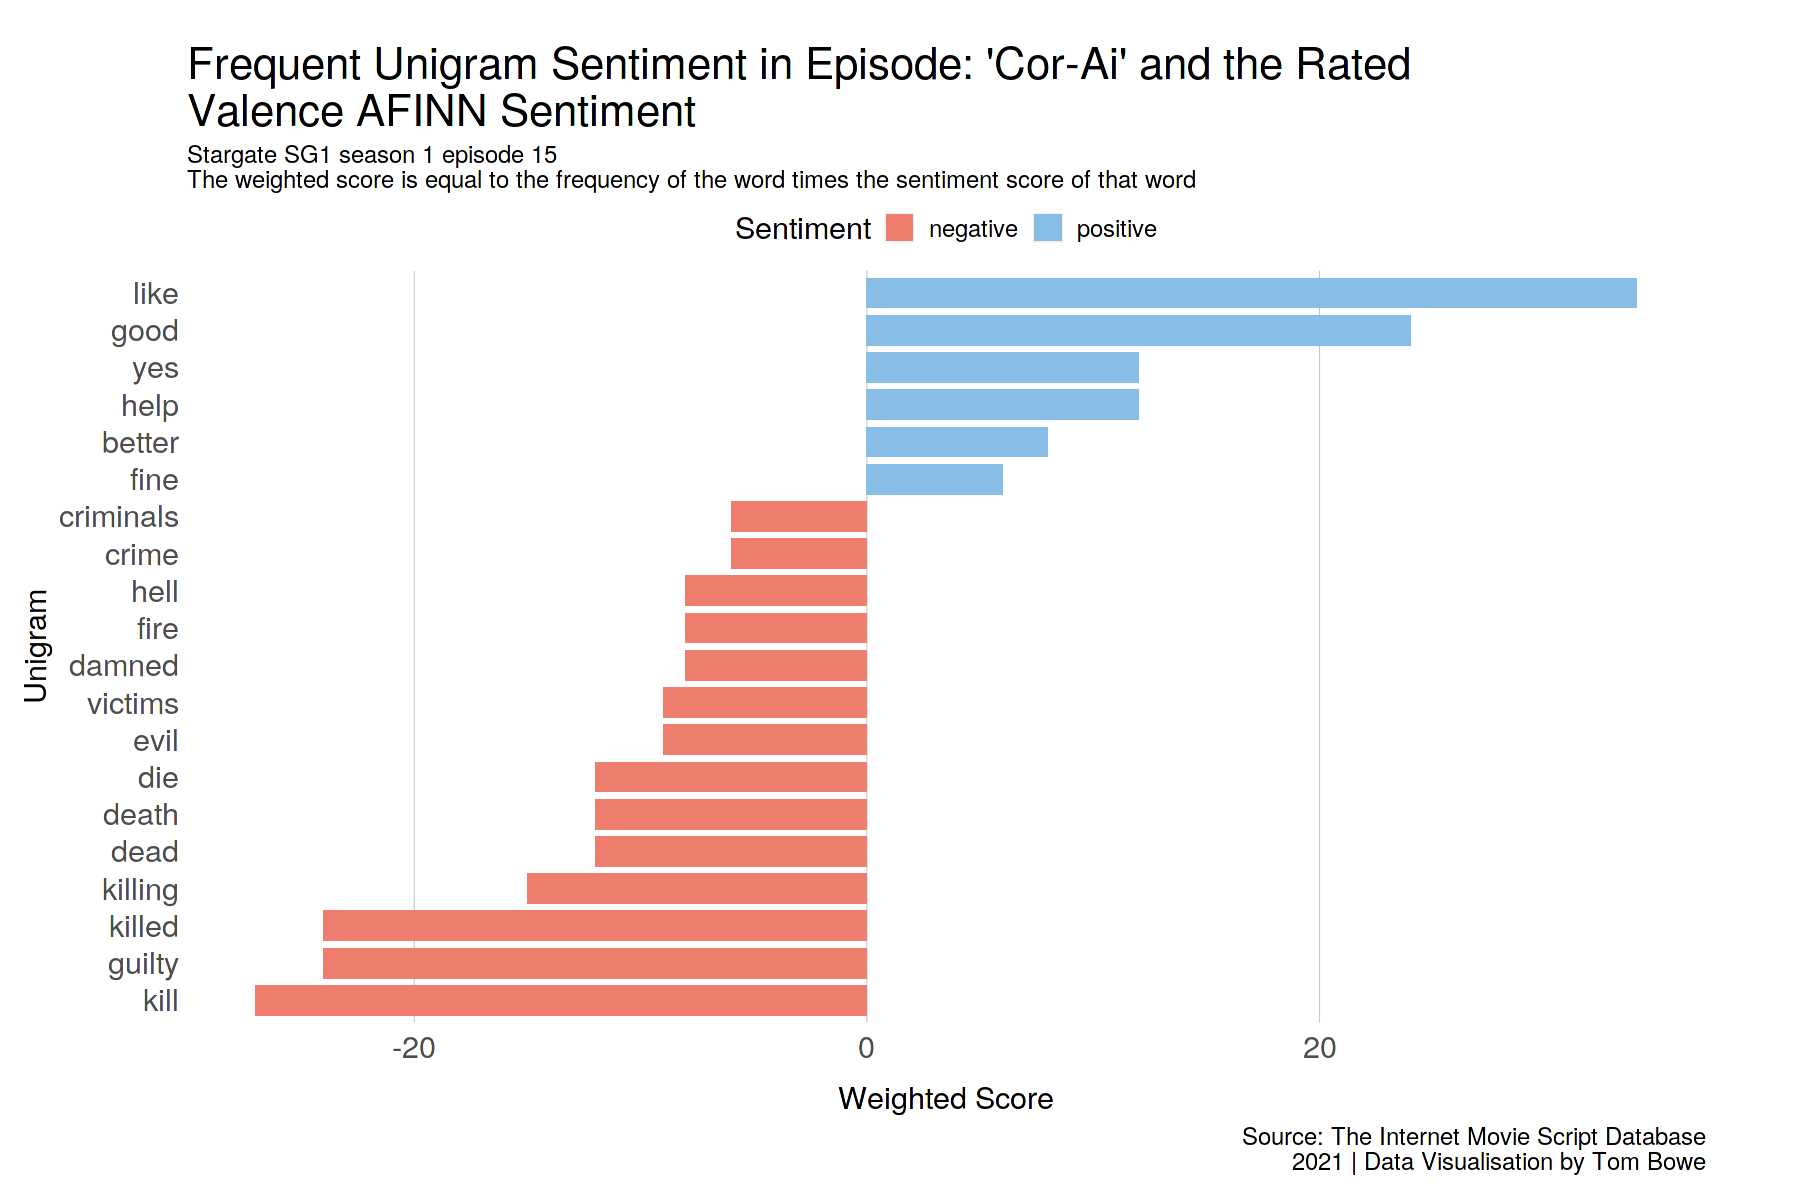

In [32]:
# Arrange the data:
sg1afinncorai <-
  subset(sg1afinn, episode_number == 15 & season_number == 1) %>%
  count(word, value) %>%
  mutate(weight = n * value) %>%
  arrange(desc(abs(weight))) %>%
  mutate(sentiment = ifelse(weight < 0, "negative", "positive")) %>%
  slice(1:20)

# Visualise:
fig_height(10)
ggplot(sg1afinncorai, aes(
  x = reorder(word, weight),
  y = weight,
  fill = sentiment
)) +
  geom_bar(stat = "identity",
           width = 0.8) +
  scale_fill_manual(values = c("#F07E6E", "#88BDE6"), name = "Sentiment") +
  theme(legend.position = "top") +
  theme_tb() +
  theme_tb_vert() +
  coord_flip() +
  labs(
    y = "Weighted Score",
    x = "Unigram",
    title = "Frequent Unigram Sentiment in Episode: 'Cor-Ai' and the Rated \nValence AFINN Sentiment",
    subtitle = "Stargate SG1 season 1 episode 15
The weighted score is equal to the frequency of the word times the sentiment score of that word",
    caption = capt
  )

### What Made Sam Carter in "Prodigy" so Positive?
Previously I visualised the trend in sentiment for each member of SG1 using the AFINN Lexicon. I noted that in "Prodigy" Sam was particularly positive, more positive than any other SG1 team member for all the available episodes. I am keen to see what made this so positive so I subset my data for dialogue by Sam, and for this particular episode and draw a plot similar to the one above.

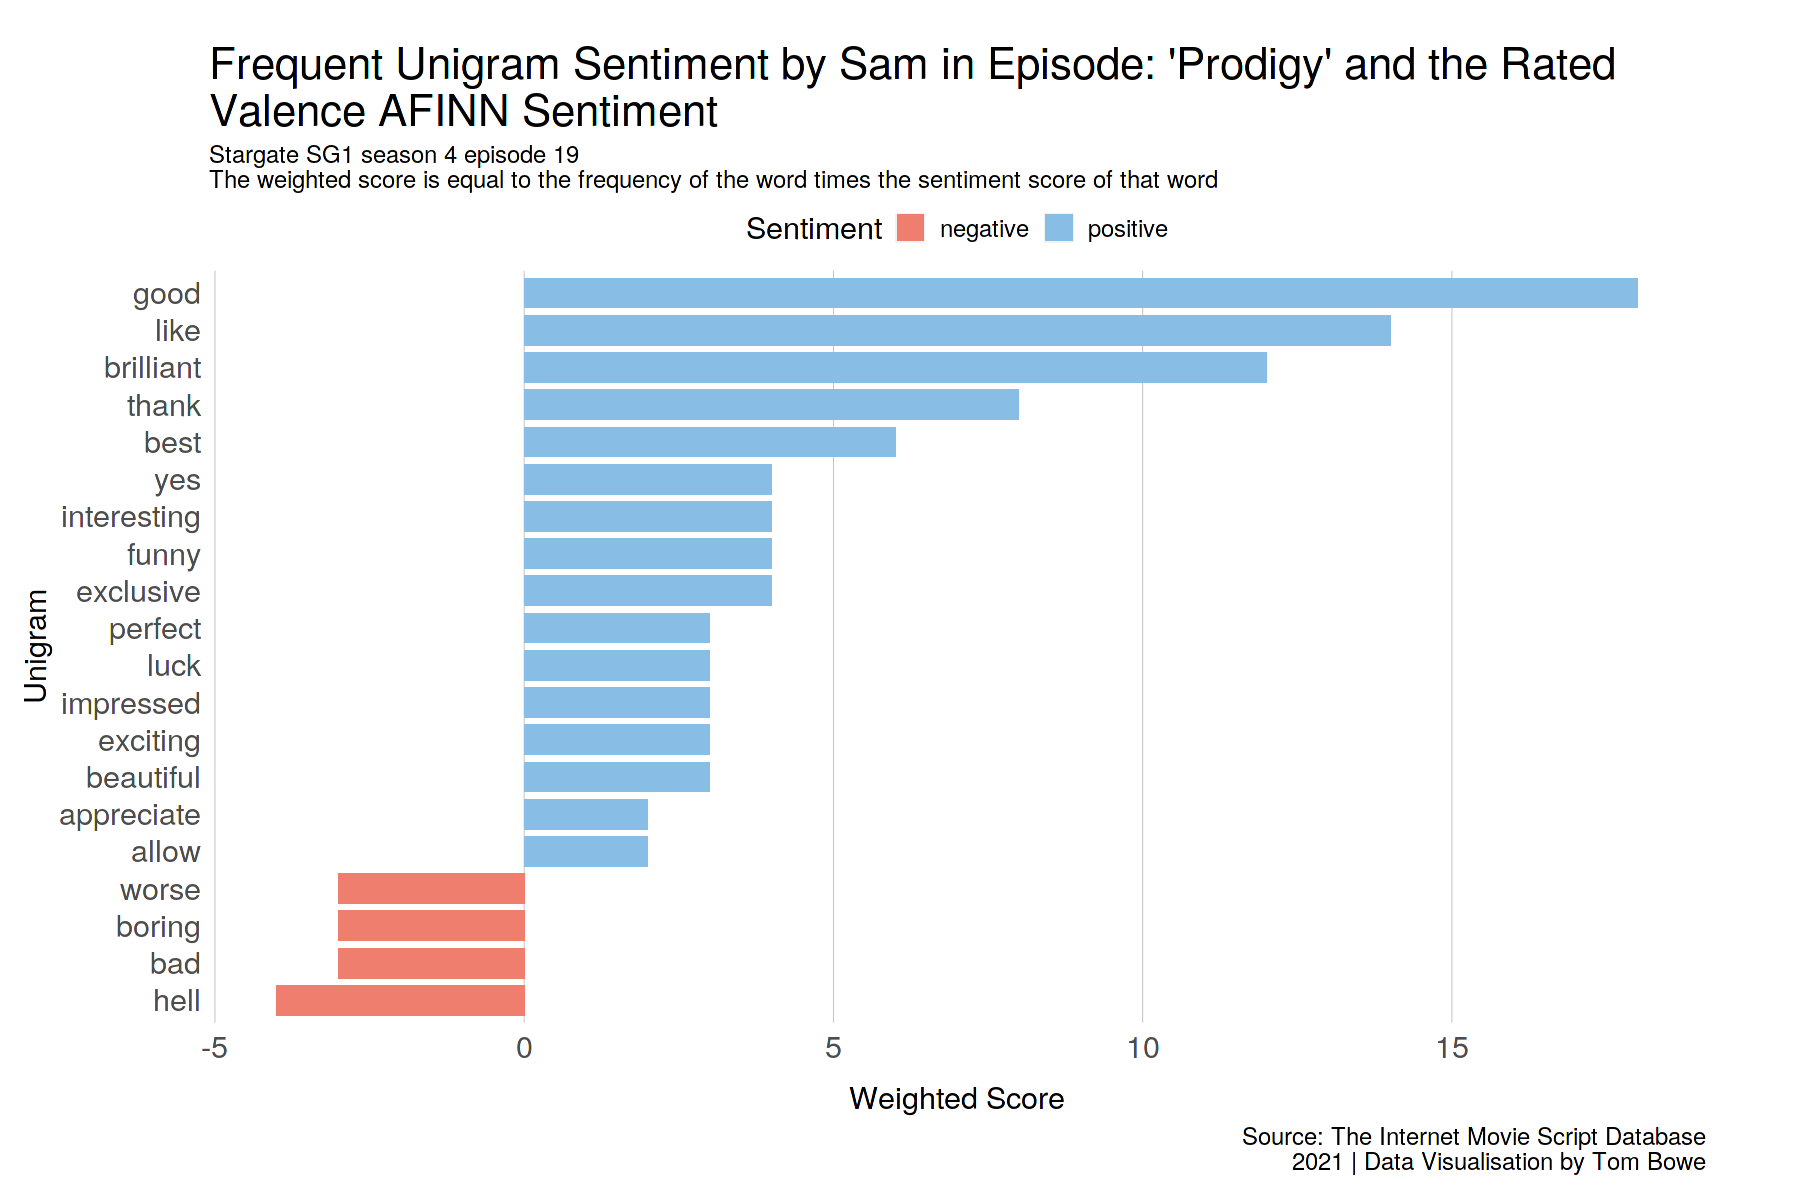

In [33]:
# Arrange the data:
sg1afinnprodigy <-
  subset(sg1afinn,
         episode_number == 19 & season_number == 4 & character == "sam") %>%
  count(word, value) %>%
  mutate(weight = n * value) %>%
  arrange(desc(abs(weight))) %>%
  mutate(sentiment = ifelse(weight < 0, "negative", "positive")) %>%
  slice(1:20)

# Visualise:
fig_height(10)
ggplot(sg1afinnprodigy, aes(
  x = reorder(word, weight),
  y = weight,
  fill = sentiment
)) +
  geom_bar(stat = "identity",
           width = 0.8) +
  scale_fill_manual(values = c("#F07E6E", "#88BDE6"), name = "Sentiment") +
  theme(legend.position = "top") +
  theme_tb() +
  theme_tb_vert() +
  coord_flip() +
  labs(
    y = "Weighted Score",
    x = "Unigram",
    title = "Frequent Unigram Sentiment by Sam in Episode: 'Prodigy' and the Rated\nValence AFINN Sentiment",
    subtitle = "Stargate SG1 season 4 episode 19\nThe weighted score is equal to the frequency of the word times the sentiment score of that word",
    caption = capt
  )

### Outlier Detection - Character Sentiment
Here I use a funnel plot to distil which characters were the most negative and most positive. Funnel plots are fun visualisations that allow us to cut through any random variation which may occur due to small sample sizes, I.e. characters that didn't speak much, and find out exactly who the most negative characters are, statistically speaking. If the point representing the character is present beyond the bounds of the dotted confidence interval (CI) lines then there is a >99% chance that this was not due to random variation, and therefore a significant outlier when compared to all other characters.

I note that Teal'c is a significantly negative character as he appears well above the upper 99% confidence interval. He is often educating the rest of SG1 on the negative traits of the Goa'uld, and is of course notorious for his inability to make a joke.

Apophis is naturally an outlier and the Jaffa (which generally is referring to Serpent Guard etc) I am sure never said a positive thing the entire duration of the show. Interestingly Dr. Janet Fraiser is quite negative which I guess is because of her context I.e. always trying to save someone/something from dying. Maybourne was surprisingly positive but I guess sarcasm and annoying aren't picked up as easily using this approach to sentiment analysis.

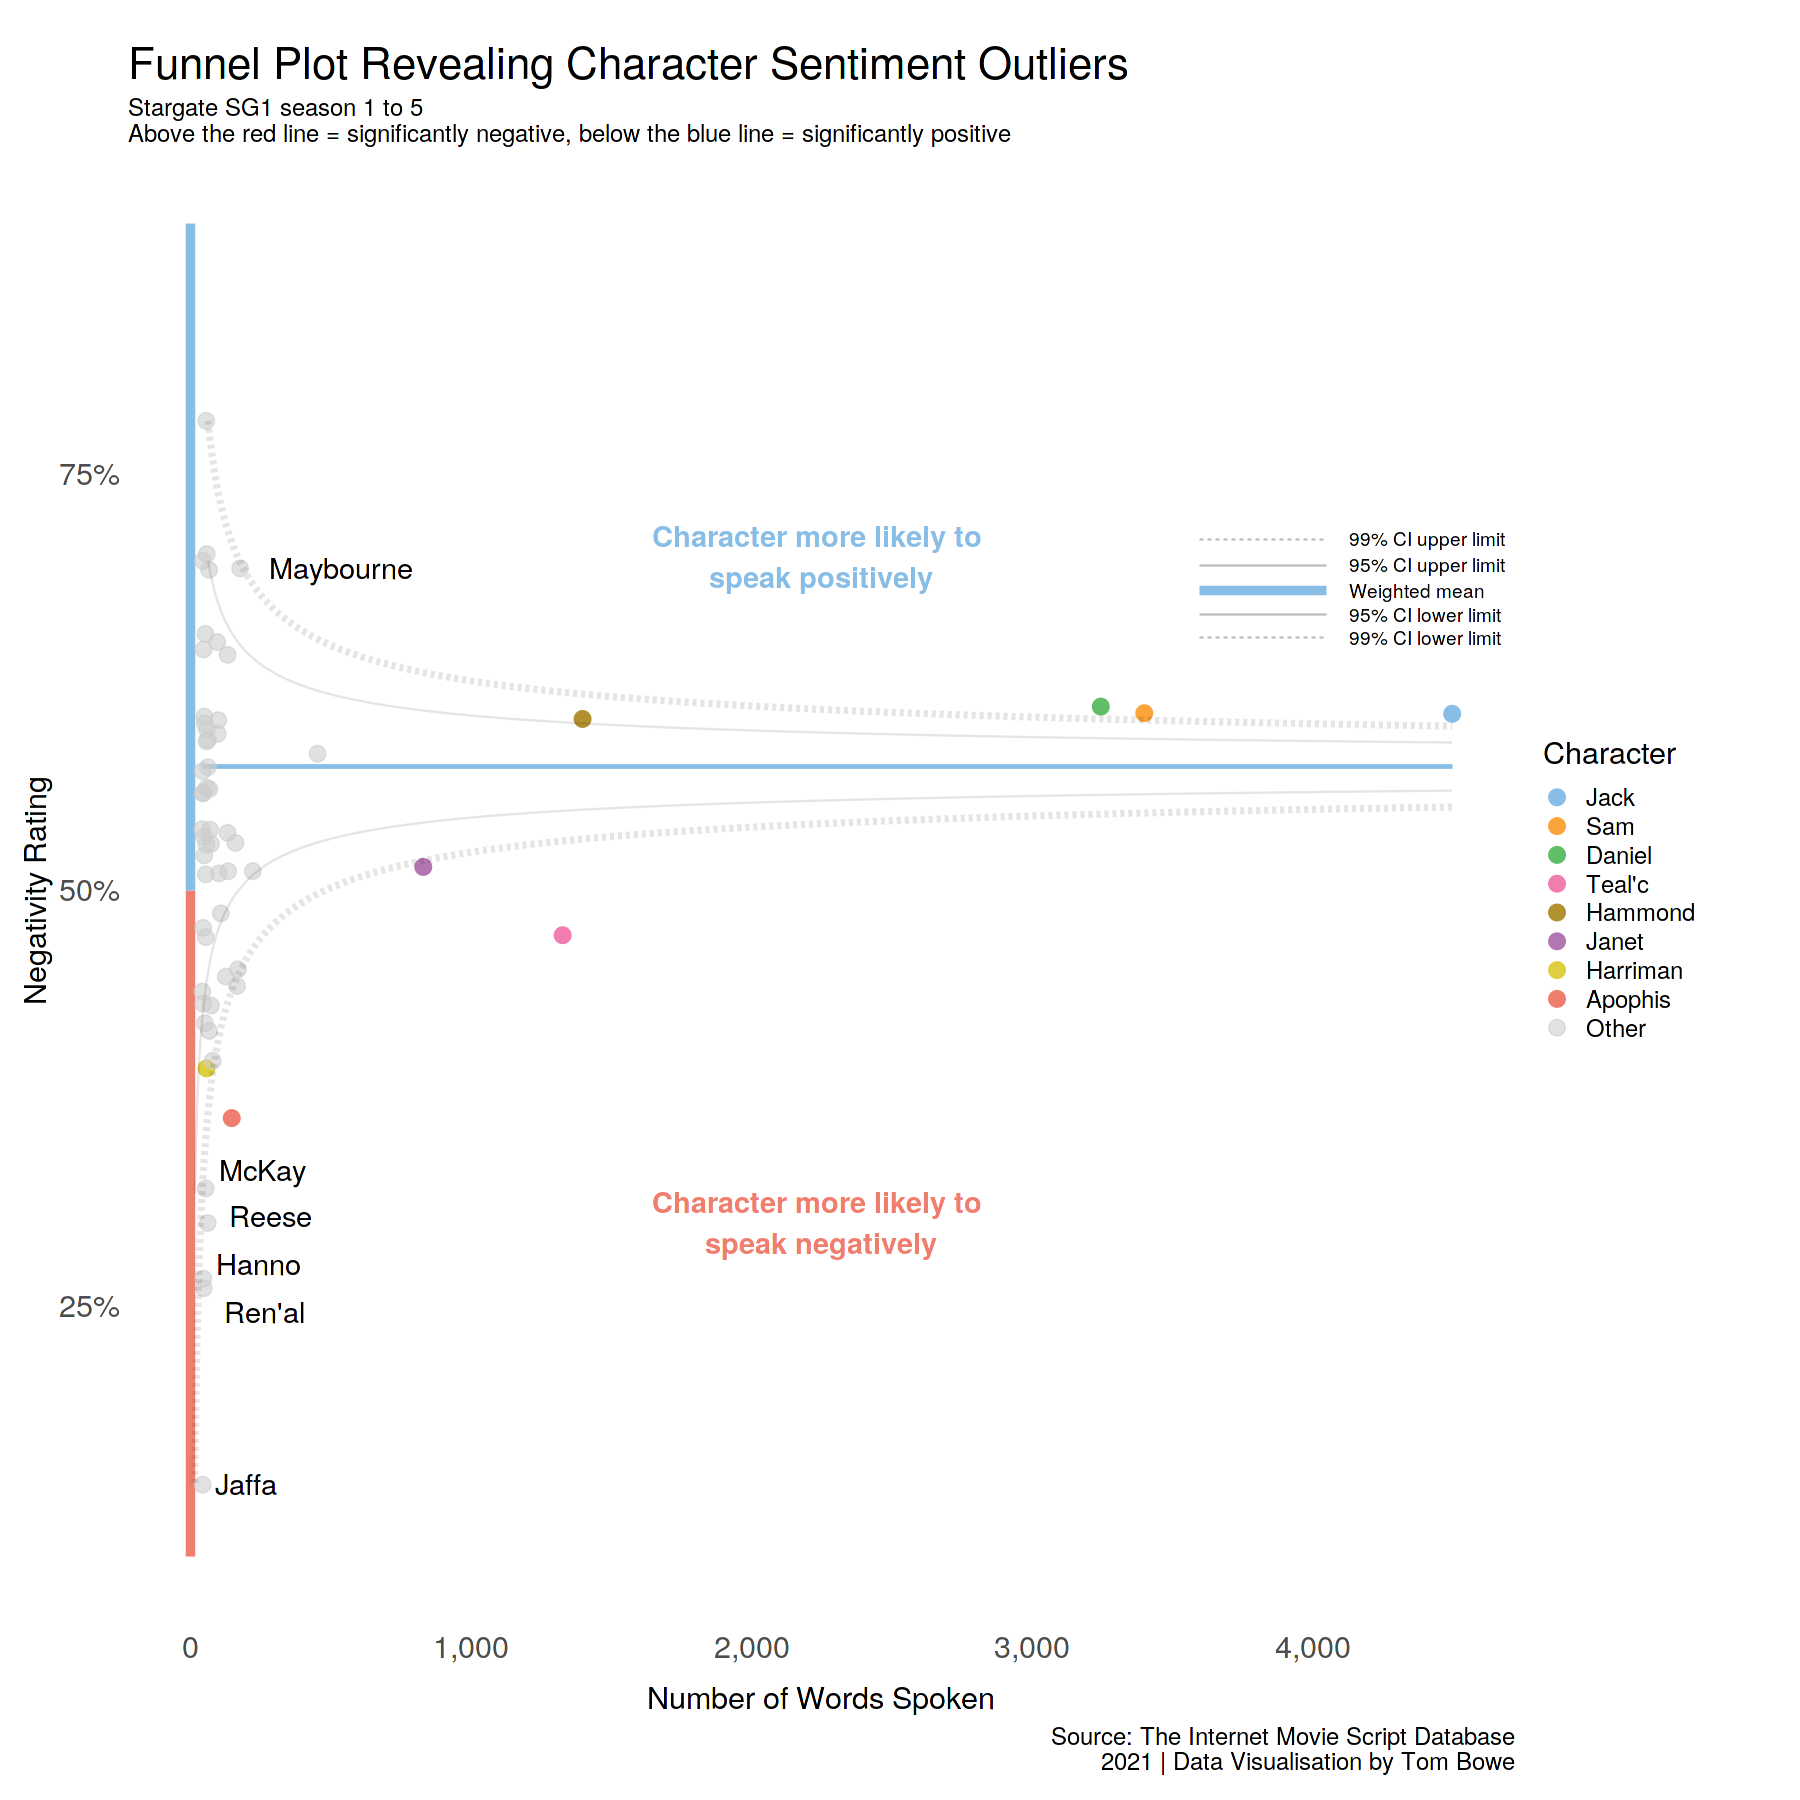

In [43]:
## Arrange the data:

# Calculate total number
sg1bingtotal <- 
  count(sg1bing, character) %>%
  rename(number = n)

# Calculate population size
sg1bingoutliers <- 
  count(sg1bing, character, sentiment) %>% 
  subset(sentiment == "positive") %>%
  select(character, n) %>%
  rename(positive = n) %>%
  inner_join(sg1bingtotal, "character") %>%
  mutate(p = positive/number) %>%
  mutate(p.se = sqrt((p*(1-p)) / (number))) %>%
  select(character, p, number, p.se) %>%
  subset(p.se > 0) %>%
  mutate(p.fem = weighted.mean(p, 1/p.se^2)) %>%
  mutate(character = as.character(character)) %>%
  subset(number > 40 & character != "man") %>%
  mutate(character = str_replace_all(character, "sam", "Sam")) %>%
  mutate(character = str_replace_all(character, "jack", "Jack")) %>%
  mutate(character = str_replace_all(character, "daniel", "Daniel")) %>%
  mutate(character = str_replace_all(character, "tealc", "Teal'c")) %>%
  mutate(character = str_replace_all(character, "hammond", "Hammond")) %>%
  mutate(character = str_replace_all(character, "janet", "Janet")) %>%
  mutate(character = str_replace_all(character, "apophis", "Apophis")) %>%
  mutate(character = str_replace_all(character, "hanno", "Hanno")) %>%
  mutate(character = str_replace_all(character, "harriman", "Harriman")) %>%
  mutate(character = str_replace_all(character, "ren al", "Ren'al")) %>%
  mutate(character = str_replace_all(character, "jaffa", "Jaffa")) %>%
  mutate(character = str_replace_all(character, "mckay", "McKay")) %>%
  mutate(character = str_replace_all(character, "reese", "Reese")) %>%
  mutate(character = str_replace_all(character, "maybourne", "Maybourne")) %>%
  mutate(character = str_replace_all(character, "joe", "Joe Faxon")) %>%
  mutate(char_col = case_when(
    (character %in% c("Sam","Jack","Daniel","Teal'c","Hammond","Janet","Apophis","Harriman")) == TRUE ~ character,
     TRUE ~ "Other")) %>%
  transform(char_col=factor(char_col,levels=c("Jack","Sam","Daniel","Teal'c","Hammond","Janet","Harriman","Apophis","Other")))

write.csv(sg1bingoutliers, "sg1_sentiment_funnelplot.csv")

# Set boundaries of the chart
boundx <- max(sg1bingoutliers$number)
minboundx <- min(sg1bingoutliers$number)
boundy <- max(sg1bingoutliers$p)
minboundy <- min(sg1bingoutliers$p)

# Create dataframes to draw the legend
u99leg <- data.frame(x1 = (boundx/5)*4, x2 = (boundx/5)*4.5, y1 = boundy/1.1, y2 = boundy/1.1)
u95leg <- data.frame(x1 = (boundx/5)*4, x2 = (boundx/5)*4.5, y1 = boundy/1.125, y2 = boundy/1.125)
wmeanleg <- data.frame(x1 = (boundx/5)*4, x2 = (boundx/5)*4.5, y1 = boundy/1.15, y2 = boundy/1.15)
l95leg <- data.frame(x1 = (boundx/5)*4, x2 = (boundx/5)*4.5, y1 = boundy/1.175, y2 = boundy/1.175)
l99leg <- data.frame(x1 = (boundx/5)*4, x2 = (boundx/5)*4.5, y1 = boundy/1.2, y2 = boundy/1.2)

# Define weighted mean (fixed effect model)
p.fem <- weighted.mean(sg1bingoutliers$p, 1/sg1bingoutliers$p.se^2)

# Lower and upper limits for 95% and 99.9% CI, based on FEM estimator
number.seq <- seq(0, boundx, 0.1)
number.ll95 <- p.fem - 1.96 * sqrt((p.fem*(1-p.fem)) / (number.seq)) 
number.ul95 <- p.fem + 1.96 * sqrt((p.fem*(1-p.fem)) / (number.seq)) 
number.ll999 <- p.fem - 3.29 * sqrt((p.fem*(1-p.fem)) / (number.seq)) 
number.ul999 <- p.fem + 3.29 * sqrt((p.fem*(1-p.fem)) / (number.seq))

# Seperate the upper and lower CI lines so as to draw them to the upper and lower bound of the chart to minimise the unused space on the chart
# Draw upper CI lines
dfCIu <- data.frame(number.ul95, number.ul999, number.seq) %>%
subset(number.ul95 < boundy & 
       number.ul999 < boundy)
# Draw the weighted mean line
dfwm <- data.frame(x1 = minboundx, x2 = boundx, y1 = p.fem, y2 = p.fem)
# Draw the lower CI lines
dfCIl <- data.frame(number.ll95, number.ll999, number.seq) %>%
subset(number.ll95 > minboundy &
       number.ll999 > minboundy)

## Visualise appropriately:
fig_height(15)

othercol <- rgb(204, 204, 204, max = 255, alpha = 150, names = "othercol")

# Create a dynamic weighted mean line colour dependent on if the sentiment is positive, negative, or neutral
meancol <- case_when(
      (p.fem > 0.5) == TRUE ~ "#88BDE6", # Red
      (p.fem < 0.5) == TRUE ~ "#F07E6E", # Blue
      (p.fem == 0) == TRUE ~ "dark gray",
      TRUE ~ "dark gray"
    )

# Draw the plot
  ggplot(sg1bingoutliers, aes(x = number, y = p, label = character)) +
# Draw the weighted mean line as a segment
  geom_segment(aes(x=x1, y=y1, xend=x2, yend=y2, label = NULL), 
               data = dfwm, 
               colour = meancol,
               size = 1) +

# Draw the positive line
  geom_segment(aes(x=0, y=0.1, xend=0, yend=.5, label = NULL), 
               data = l99leg, 
               colour = "#F07E6E",
               size = 2) + ggplot2::annotate("text", 
                                             x = boundx/2, 
                                             y = .7, 
                                             hjust = 0.5, 
                                             fontface = 2, 
                                             colour = "#88BDE6", 
                                             label = "Character more likely to \nspeak positively", 
                                             size = 6) +

# Draw the negative line
  geom_segment(aes(x=0, y=0.5, xend=0, yend=0.9, label = NULL), 
               data = l99leg, 
               colour = "#88BDE6",
               size = 2) + ggplot2::annotate("text", 
                                             x = boundx/2, 
                                             y = .3, 
                                             hjust = 0.5, 
                                             fontface = 2, 
                                             colour = "#F07E6E", 
                                             label = "Character more likely to \nspeak negatively", 
                                             size = 6) + 

# Draw the character points and assign aesthetics
  geom_point(aes(colour = char_col), size = 4) +
  scale_colour_manual(values = c("#88BDE6","#FAA43A","#60BD68","#F17CB0","#B2912F","#B276B2","#DECF3F","#F07E6E",othercol), name = "Character") +
# Draw the confidence interval lines
  geom_line(aes(x = number.seq, y = number.ll95, label = NULL),
            colour = 1,
            alpha = .1,
            data = dfCIl
            ) +
  geom_line(aes(x = number.seq, y = number.ul95, label = NULL), 
            colour = 1,
            alpha = .1,
            data = dfCIu
            ) +
  geom_line(aes(x = number.seq, y = number.ll999, label = NULL),
            linetype = "dashed",
            size = 1.5,
            colour = 1,
            alpha = .1,
            data = dfCIl
            ) +
  geom_line(aes(x = number.seq, y = number.ul999, label = NULL),
            linetype = "dashed",
            size = 1.5,
            colour = 1,
            alpha = .1,
            data = dfCIu
            ) +

# Customise axis
  scale_y_continuous(limits = c(.1, .9), labels = percent_format(accuracy = 1L)) + 
  scale_x_continuous(labels = comma) +

# Return theme
  theme_tb() +

# Draw the data labels as specified
  geom_text_repel(data = subset(sg1bingoutliers, character %in% c("Reese","McKay","Maybourne","Jaffa","Joe Faxon","Hanno","Ren'al")), 
                  size = 6, box.padding = 0.5, segment.alpha = 0, hjust = -0.2) +

# Draw the legend
  geom_segment(aes(x=x1, y=y1, xend=x2, yend=y2, label = NULL), 
               data = u99leg, 
               colour = "grey", 
               linetype = "dashed") + ggplot2::annotate("text", x = u99leg$x2*1.02, y = u99leg$y2, hjust = 0, label = "99% CI upper limit") +
  geom_segment(aes(x=x1, y=y1, xend=x2, yend=y2, label = NULL), 
               data = u95leg, 
               colour = "grey") + ggplot2::annotate("text", x = u95leg$x2*1.02, y = u95leg$y2, hjust = 0, label = "95% CI upper limit") +
  geom_segment(aes(x=x1, y=y1, xend=x2, yend=y2, label = NULL), 
               data = wmeanleg, 
               colour = meancol,
               size = 2) + ggplot2::annotate("text", x = wmeanleg$x2*1.02, y = wmeanleg$y2, hjust = 0, label = "Weighted mean") +
  geom_segment(aes(x=x1, y=y1, xend=x2, yend=y2, label = NULL), 
               data = l95leg, 
               colour = "grey") + ggplot2::annotate("text", x = l95leg$x2*1.02, y = l95leg$y2, hjust = 0, label = "95% CI lower limit") +
  geom_segment(aes(x=x1, y=y1, xend=x2, yend=y2, label = NULL), 
               data = l99leg, 
               colour = "grey",
               linetype = "dashed") + ggplot2::annotate("text", x = l99leg$x2*1.02, y = l99leg$y2, hjust = 0, label = "99% CI lower limit") +

# Details of all labels axis labels, titles, caption, etc
  labs(y = "Negativity Rating", 
       x = "Number of Words Spoken", 
       title = "Funnel Plot Revealing Character Sentiment Outliers",
       subtitle = "Stargate SG1 season 1 to 5\nAbove the red line = significantly negative, below the blue line = significantly positive",
       caption = capt)

### Detailed Sentiment Overview for Main Characters Using the NRC Lexicon
The NRC lexicon breaks the sentiment down into a more granular fashion when compared to BING which is binary. I can assess sentiments like joy, or sadness as well as negative and positive. For this analysis I remove neg and pos as I consider this complete from BING and AFINN, and I subset for some of our favourite characters. I count the number of words for each sentiment in the lexicon and create a rate from the total number of words spoken by each character. This creates a relative comparison. I then order everything from largest to smallest overall sentiment, and then each character within. 

Also, please note: I could have faceted by character and encoded sentiment with colour, but the approach I've taken allows me to immediately see who was the most or least angry etc. Faceting by character just compares the frequency of each sentiment for a character and I note that this distribution is often quite similar from a relative perspective. I don’t care if Jack was angry more than he was joyful, I want to know who the most joyful was and who the angriest was.

I immediately note that Trust is the most common sentiment, headed up by Sam and Hammond. Our Goa'uld characters are the most joyful, with Hathor a clear outlier here; if destroying entire civilisations brings you joy then this makes sense.

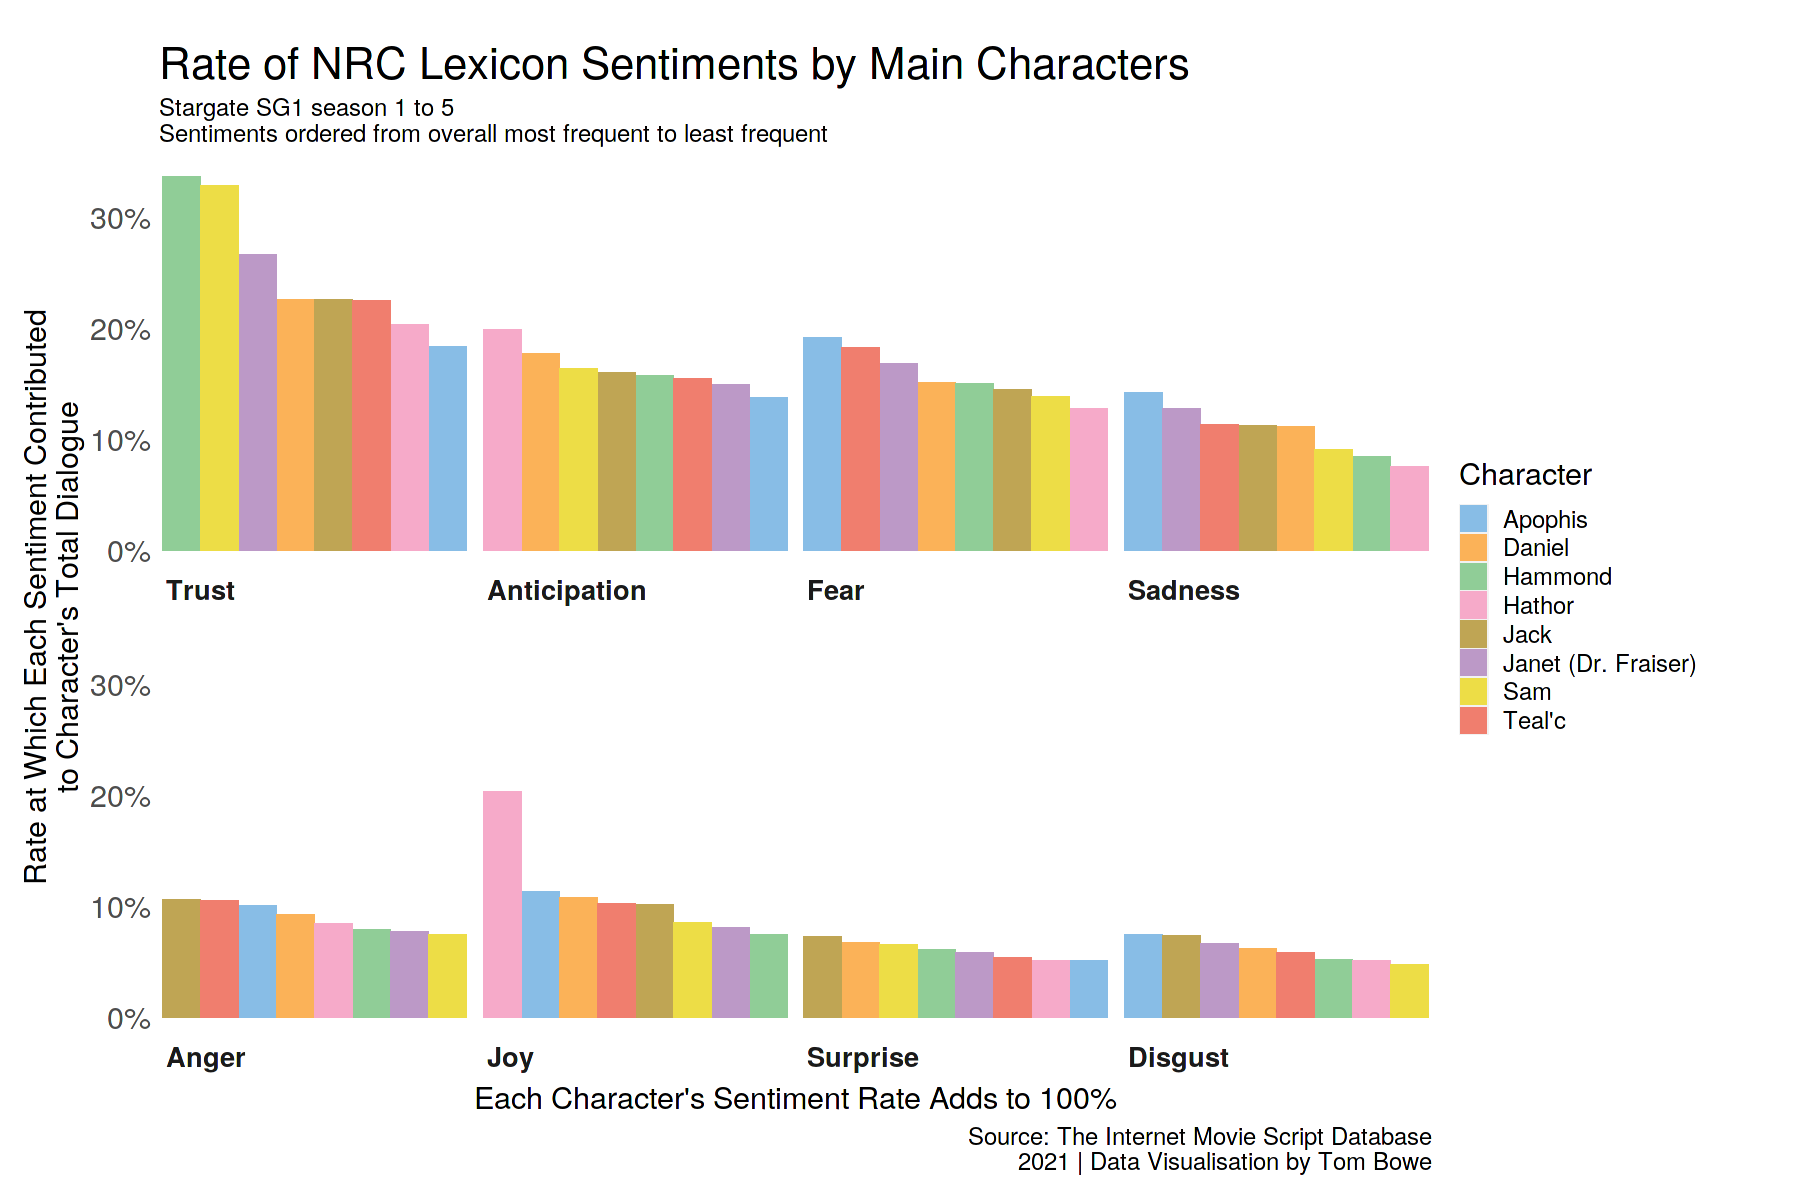

In [35]:
# Arrange the data:
nrcmc <-
  subset(sg1nrc, (!(sentiment %in% c(
    "positive", "negative"
  )))) %>%
  count(character, sentiment)
sg1nrctotal <-
  subset(sg1nrc, (!(sentiment %in% c(
    "positive", "negative"
  )))) %>%
  count(character)
sg1nrcrel <-
  subset(sg1nrc, (!(sentiment %in% c(
    "positive", "negative"
  )))) %>%
  count(character, sentiment) %>%
  select(character, sentiment, n) %>%
  inner_join(sg1nrctotal, "character") %>%
  mutate(p = n.x / n.y) %>%
  subset(
    character %in% c(
      "jack",
      "sam",
      "daniel",
      "tealc",
      "apophis",
      "hammond",
      "janet",
      "hathor"
    )
  ) %>%
  mutate(character = str_replace_all(character, "sam", "Sam")) %>%
  mutate(character = str_replace_all(character, "jack", "Jack")) %>%
  mutate(character = str_replace_all(character, "daniel", "Daniel")) %>%
  mutate(character = str_replace_all(character, "tealc", "Teal'c")) %>%
  mutate(character = str_replace_all(character, "hammond", "Hammond")) %>%
  mutate(character = str_replace_all(character, "janet", "Janet (Dr. Fraiser)")) %>%
  mutate(character = str_replace_all(character, "apophis", "Apophis")) %>%
  mutate(character = str_replace_all(character, "hathor", "Hathor")) %>%
  mutate(sentiment = str_replace_all(sentiment, "trust", "Trust")) %>%
  mutate(sentiment = str_replace_all(sentiment, "anticipation", "Anticipation")) %>%
  mutate(sentiment = str_replace_all(sentiment, "fear", "Fear")) %>%
  mutate(sentiment = str_replace_all(sentiment, "sadness", "Sadness")) %>%
  mutate(sentiment = str_replace_all(sentiment, "anger", "Anger")) %>%
  mutate(sentiment = str_replace_all(sentiment, "joy", "Joy")) %>%
  mutate(sentiment = str_replace_all(sentiment, "surprise", "Surprise")) %>%
  mutate(sentiment = str_replace_all(sentiment, "disgust", "Disgust")) %>%
  transform(sentiment = factor(
    sentiment,
    levels = c(
      "Trust",
      "Anticipation",
      "Fear",
      "Sadness",
      "Anger",
      "Joy",
      "Surprise",
      "Disgust"
    )
  ))

# Visualise:
fig_height(10)
ggplot(sg1nrcrel, aes(
  x = reorder_within(character, -p, sentiment),
  y = p,
  fill = character
)) +
  geom_bar(stat = "identity", width = 1) +
  theme_tb() +
  theme(axis.text.x = element_blank()) +
  scale_x_reordered() +
  scale_y_continuous(labels = percent_format(accuracy = 1L)) +
  scale_fill_few(palette = "Light", name = "Character") +
  facet_wrap(
    ~ sentiment,
    scales = "free_x",
    nrow = 2,
    strip.position = "bottom"
  ) +
  labs(
    y = "Rate at Which Each Sentiment Contributed\nto Character's Total Dialogue",
    x = "Each Character's Sentiment Rate Adds to 100%",
    title = "Rate of NRC Lexicon Sentiments by Main Characters",
    subtitle = "Stargate SG1 season 1 to 5\nSentiments ordered from overall most frequent to least frequent",
    caption = capt
  )